In [2]:
# Install and load R pakcages that are necessary for the analysis - Packages are collections of R functions, data, 
# and compiled code in a well-defined format. Remove the hash sign to download and install the packages.

#source('http://bioconductor.org/biocLite.R')
#biocLite('phyloseq')
library("phyloseq")
packageVersion("phyloseq")

#biocLite("biomformat")
library("biomformat")
packageVersion("biomformat")

#install.packages("ggplot2")
library("ggplot2")
packageVersion("ggplot2")

#install.packages("vegan")
library("vegan")
packageVersion('vegan')

#install.packages("grid")
library("grid")
packageVersion('grid')

#install.packages("magrittr")
library(magrittr)
packageVersion('magrittr')

library(dplyr)

library(plyr)

library(broom)

library('stringr')

[1] ‘1.19.1’

[1] ‘1.2.0’

[1] ‘2.2.1’

Loading required package: permute
Loading required package: lattice
This is vegan 2.4-6


[1] ‘2.4.6’

[1] ‘3.4.1’

[1] ‘1.5’


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: ‘plyr’

The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



# Load Data into PhyloSeq object

In [8]:
#add biome table, tree and metadata
biom_data <- import_biom(BIOMfilename = "table-with-taxonomy-json.biom", 
                         treefilename = "tree.nwk")
mapping_file <- import_qiime_sample_data(mapfilename = "sample-metadata.tsv")

In [9]:
# Merge the OTU and mapping data into a phyloseq object
phylo <- merge_phyloseq(biom_data, mapping_file)
#Add names to biom table and check phyloseq objects
colnames(tax_table(phylo))= c("Kingdom","Phylum","Class","Order","Family","Genus", "Species")
rank_names(phylo)

[1] "Kingdom" "Phylum"  "Class"   "Order"   "Family"  "Genus"   "Species"

In [10]:
# Start to explore the data a bit 
#number of samples
print ('Number of Samples in our Biom Table')
nsamples(phylo)
# number of sequence variants
print ('Number of Sequence variants we have.')
ntaxa(phylo)
#summary statistics of sampling depth
print ('Sequencing depth.')
depths <- sample_sums(phylo)
summary(depths)

# We see that we have a sample with a very low sequencing depth of 19 we will remove this sample

[1] "Number of Samples in our Biom Table"


[1] 80

[1] "Number of Sequence variants we have."


[1] 2563

[1] "Sequencing depth."


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     19   48560   56604   59171   66430  185952 

In [11]:
#identify the one sample with very low sequencing depth from above
head(sort(sample_sums(phylo)),1)

51291 
   19

In [41]:
phylo=subset_samples(phylo,Description!='51291')

#summary statistics of sampling depth
print ('Sequencing depth.')
depths <- sample_sums(phylo)
summary(depths)
# look at  sample sum to make sure we got rid of the sample

[1] "Sequencing depth."


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  26648   49505   56702   59920   66746  185952 

# I like to look at the big picture first ( alpha and beta diversity before diving into specifics ( taxa barplots, differential taxa abundance). We will rarefy the data to allow for proper comparisons between samples of different sequencing depth.

In [58]:
#subset only groups we are interested in via talk with hiro
group12367=subset_samples(phylo, grouping == '1' | grouping=='2' | grouping=='3' |grouping=='6'| grouping=='7' )
sample_data(group12367)$Sample=as.factor(sample_data(group12367)$Sample)

#summary statistics of sampling depth
print ('Sequencing depth.')
depths <- sample_sums(group12367)
summary(depths)
# look at  sample sum to make sure we got rid of the sample

[1] "Sequencing depth."


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  26648   51536   58703   59489   68898   94518 

In [59]:
# Rarefy datasset to even depth and set the seed of R‘s random number generator, which is useful for creating 
# simulations or random objects that can be reproduced. You can see this in action by using rnorm(5) multiple times 
# with and without the seed.
#set.seed(123) 
#phylorare=rarefy_even_depth(group12367, rngseed=1, sample.size=0.9*min(sample_sums(group12367)), replace=F)

set.seed(123)
for (i in 1:100) {
  # Subsample
    
  group12367rarefy <- rarefy_even_depth(group12367, sample.size = 24000, verbose = FALSE, replace = TRUE)
}

# Alpha diversity (Microbial richness)

In [ ]:
#pdf('plot_richness_Name.pdf',width=12, height=10)


#, "Shannon"
pAlpha=plot_richness(group12367rarefy, x = "Name", color='Name' ,measures=c("Observed")) 

pAlpha+ geom_boxplot()+ggtitle(' Alpha Diversity:  Name')+theme_bw()+
theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))
dev.off()

#seem to be getting an increased al-pha diversity
pdf('plot_richness_prebiotic.pdf',width=12, height=10)


pAlpha=plot_richness(group12367rarefy, x = "prebiotic", color='prebiotic' ,measures=c("Observed")) 
pAlpha+ geom_boxplot()+ggtitle(' Alpha Diversity: Vehicle and Prebiotic')+theme_bw()+
theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))
#dev.off()

In [61]:
# Anova of alphadiversity between groups above
library("data.table"); packageVersion("data.table")
# if experiemnt works then ad below
# Store as a new data variable
alphadt = data.table(pAlpha$data)
# Subset to just the Observed SVs
alphadt <- alphadt[(variable == "Observed")]

#install.packages('FSA')
library(FSA)
print('Kruskall wallis folllowed by dunns for Observed SVs per group')
dunnTest(rank(value) ~ Name,
              data=alphadt,
              method="bh")    

print('Kruskall wallis folllowed by dunns for Observed SVs Prebiotic')
dunnTest(value ~ prebiotic,
              data=alphadt,
              method="bh")   



[1] ‘1.10.4.3’

[1] "Kruskall wallis folllowed by dunns for Observed SVs per group"


Dunn (1964) Kruskal-Wallis multiple comparison
  p-values adjusted with the Benjamini-Hochberg method.



                                                                                                      Comparison
1                                                      Group 01 - Vehicle - PB - Group 02 - Ellagic Acid 55mg/kg
2                                                       Group 01 - Vehicle - PB - Group 03 - Urolithin A 55mg/kg
3                                               Group 02 - Ellagic Acid 55mg/kg - Group 03 - Urolithin A 55mg/kg
4                                Group 01 - Vehicle - PB - Group 06 - Microbe mix 3 200uL + Ellagic Acid 55mg/kg
5                        Group 02 - Ellagic Acid 55mg/kg - Group 06 - Microbe mix 3 200uL + Ellagic Acid 55mg/kg
6                         Group 03 - Urolithin A 55mg/kg - Group 06 - Microbe mix 3 200uL + Ellagic Acid 55mg/kg
7                                Group 01 - Vehicle - PB - Group 07 - Microbe mix 4 200uL + Ellagic Acid 55mg/kg
8                        Group 02 - Ellagic Acid 55mg/kg - Group 07 - Microbe mix 4 200uL + Ella

[1] "Kruskall wallis folllowed by dunns for Observed SVs Prebiotic"


Dunn (1964) Kruskal-Wallis multiple comparison
  p-values adjusted with the Benjamini-Hochberg method.



    Comparison          Z   P.unadj     P.adj
1      EA - UA -1.1684989 0.2426056 0.3639083
2 EA - vehicle  0.7188645 0.4722244 0.4722244
3 UA - vehicle  1.5378431 0.1240870 0.3722610

## Nothing really above, but this is time series data perhaps we should look at this in a linear regression form 

In [62]:
# Break up d by state, then fit the specified model to each piece and
# return a list
summary(alphadt$Name)
models <- dlply(alphadt, "Name", function(df) # the Name can be changed to whatever category you are interested in
  lm(rank(value) ~ Timepoint, data = df))


# Print the summary of each model

cbind(
  state = attr(models, "split_labels"),
  bind_rows(lapply(models, function(x) cbind(
    intercept = tidy(x)$estimate[1],
    beta = tidy(x)$estimate[2],
    glance(x))))
)

Group 01 - Vehicle - PB 
                                                   10 
                      Group 02 - Ellagic Acid 55mg/kg 
                                                   10 
                       Group 03 - Urolithin A 55mg/kg 
                                                    9 
Group 06 - Microbe mix 3 200uL + Ellagic Acid 55mg/kg 
                                                   10 
Group 07 - Microbe mix 4 200uL + Ellagic Acid 55mg/kg 
                                                   10

Name                                                  intercept beta    
1 Group 01 - Vehicle - PB                               2.275000  1.075000
2 Group 02 - Ellagic Acid 55mg/kg                       2.650000  0.950000
3 Group 03 - Urolithin A 55mg/kg                        1.376471  1.164706
4 Group 06 - Microbe mix 3 200uL + Ellagic Acid 55mg/kg 1.900000  1.200000
5 Group 07 - Microbe mix 4 200uL + Ellagic Acid 55mg/kg 2.200000  1.100000
  r.squared adj.r.squared sigma    statistic p.value    df logLik    AIC     
1 0.2853395 0.1960069     2.689970 3.194127  0.11171408 2  -22.96897 51.93793
2 0.2187879 0.1211364     2.838353 2.240497  0.17280900 2  -23.50591 53.01182
3 0.4270588 0.3452101     2.216061 5.217659  0.05628506 2  -18.80111 43.60222
4 0.3490909 0.2677273     2.590849 4.290503  0.07207739 2  -22.59352 51.18705
5 0.2933333 0.2050000     2.699537 3.320755  0.10587957 2  -23.00447 52.00894
  BIC      deviance df.residual
1 52.84569 57.88750 8          
2 53.91957 64.45000 8          
3 44.19390 34.37647 7          
4 52.09481 53.70000 8          
5 52.91670 58.30000 8

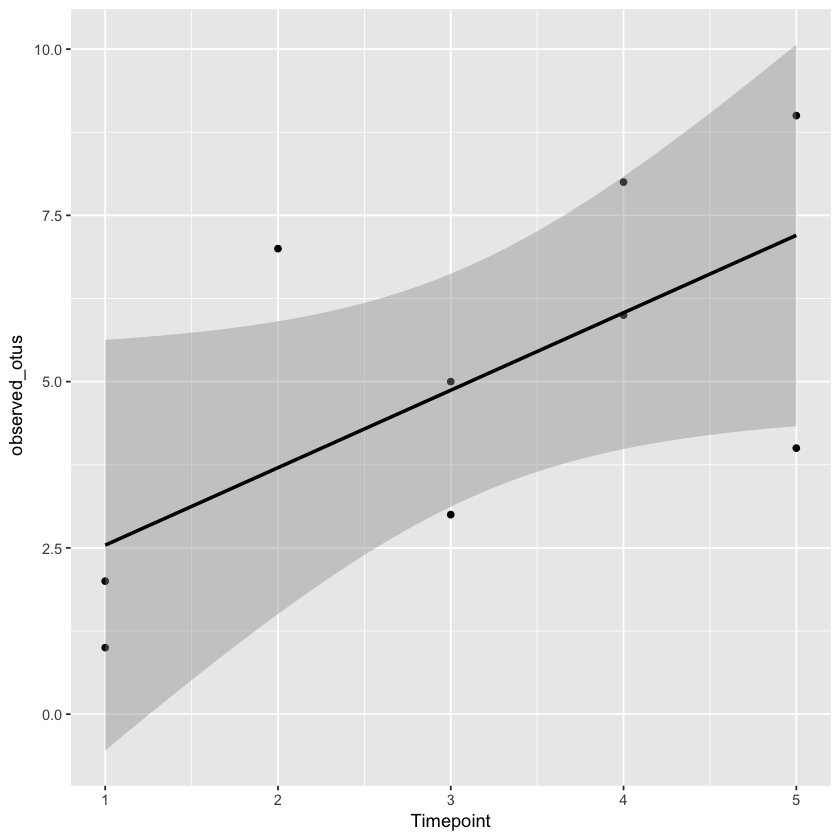

In [63]:
#Group 3 seems to be the closest to statistical sgnificance, but these are small sample sizes per time interval
# 
alphadt6=subset(alphadt, grouping =='3')
p1og=ggplot(alphadt6,aes(x=Timepoint,y=rank(value))) +  geom_point() + stat_smooth(method = "lm", col = "black")+
  labs(x = "Timepoint", y=" observed_otus")
p1og



In [64]:
# DO the same as above but wit prebiotic category
summary(alphadt$prebiotic)
models <- dlply(alphadt, "prebiotic", function(df) # the Name can be changed to whatever category you are interested in
  lm(rank(value) ~ Timepoint, data = df))


# Print the summary of each model

cbind(
  state = attr(models, "split_labels"),
  bind_rows(lapply(models, function(x) cbind(
    intercept = tidy(x)$estimate[1],
    beta = tidy(x)$estimate[2],
    glance(x))))
)

EA      UA vehicle 
     30       9      10

prebiotic intercept beta     r.squared adj.r.squared sigma    statistic
1 EA        5.000000  3.500000 0.3271756 0.3031462     7.347254 13.615614
2 UA        1.376471  1.164706 0.4270588 0.3452101     2.216061  5.217659
3 vehicle   2.275000  1.075000 0.2853395 0.1960069     2.689970  3.194127
  p.value      df logLik     AIC       BIC       deviance   df.residual
1 0.0009586491 2  -101.36306 208.72612 212.92972 1511.50000 28         
2 0.0562850606 2   -18.80111  43.60222  44.19390   34.37647  7         
3 0.1117140768 2   -22.96897  51.93793  52.84569   57.88750  8

In [ ]:
#pdf('pdf/linear_regression_time.pdf')
alphadtEA=subset(alphadt, prebiotic =='EA')


p1og=ggplot(alphadtEA,aes(x=Timepoint,y=rank(value))) +  geom_point() + stat_smooth(method = "lm", col = "black")+
  labs(x = "Timepoint EA", y=" observed_otus")
p1og

alphadtUA=subset(alphadt, prebiotic =='UA')
p1og=ggplot(alphadtUA,aes(x=Timepoint,y=rank(value))) +  geom_point() + stat_smooth(method = "lm", col = "black")+
  labs(x = "Timepoint UA", y=" observed_otus")
p1og

alphadtUvehicle=subset(alphadt, prebiotic =='vehicle')
p1og=ggplot(alphadtUvehicle,aes(x=Timepoint,y=rank(value))) +  geom_point() + stat_smooth(method = "lm", col = "black")+
  labs(x = "Timepoint vehicle", y=" observed_otus")
p1og
#dev.off()

## While the prebiotic linear regression looks promising for EA keep in mind that we have 30 samples in that dataset compared to only 10 for the others. Can't make blanket statements but overall looks like alpha diversity isn't much different between the groups, but it is increasing in everygroup which is expected if no detromental outside influence.


# Beta diversity ( microbial composition)

In [67]:
# Calculate distances
set.seed(123)
DistBC = distance(group12367rarefy, method = "bray")
DistUWF = distance(group12367rarefy, method = "unifrac", weighted=FALSE)
DistWF = distance(group12367rarefy, method = "unifrac")



Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- c72a095701b17c0a577665c5da0e11e3 -- in the phylogenetic tree in the data you provided.”Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- 82d41109dd40277b288a5abfc1229dc3 -- in the phylogenetic tree in the data you provided.”

In [68]:
#ordination
ordBC = ordinate(group12367rarefy, method = "PCoA", distance = DistBC)
ordUWF = ordinate(group12367rarefy, method = "PCoA", distance = DistUWF)
ordWF = ordinate(group12367rarefy, method = "PCoA", distance = DistWF)

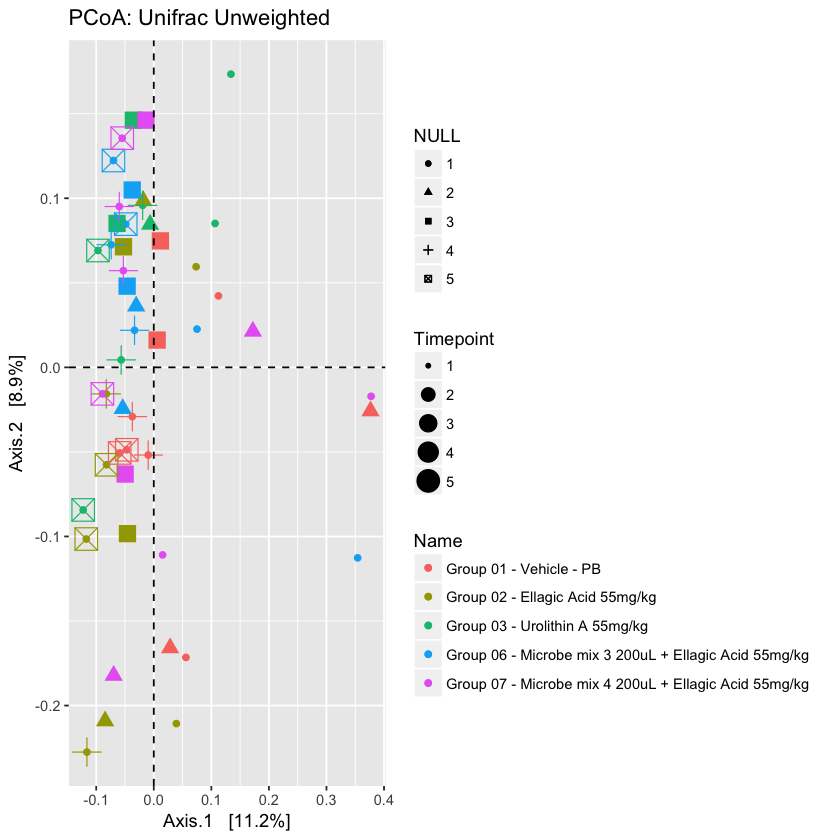

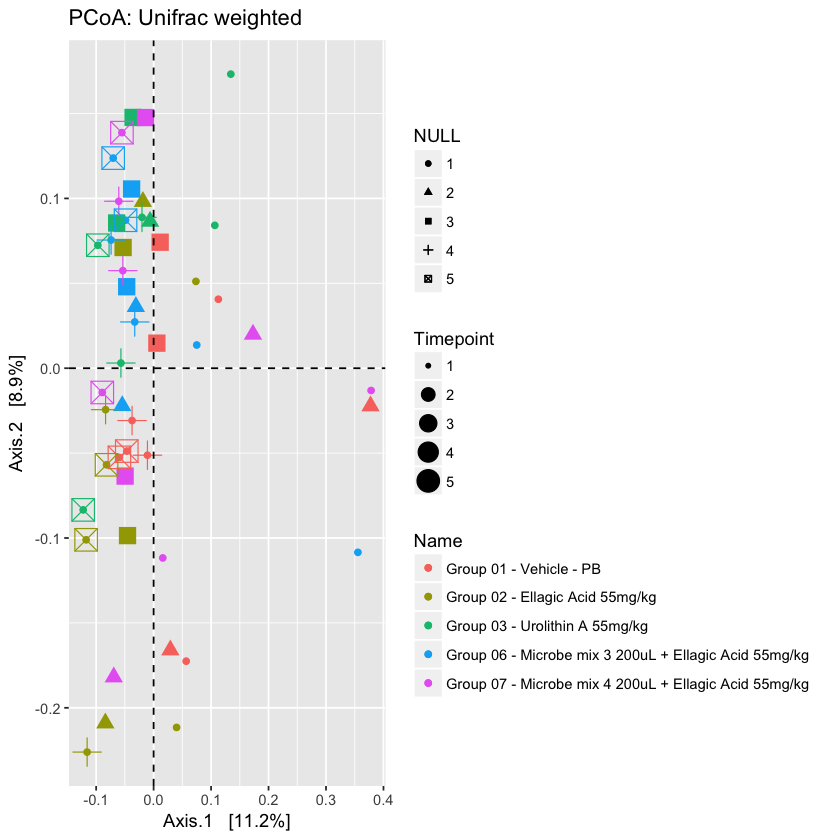

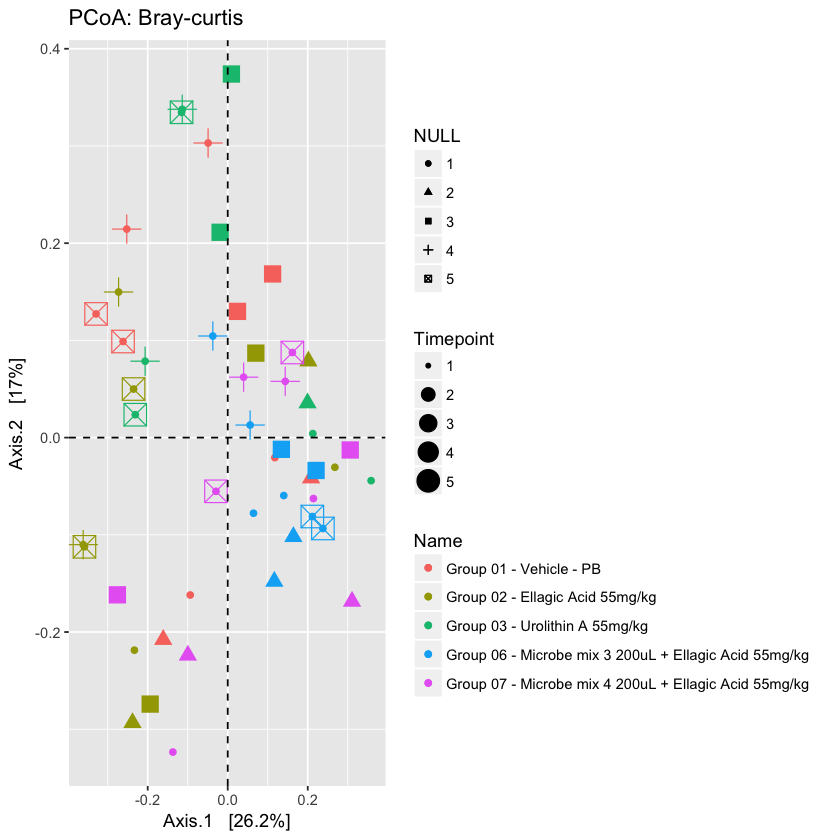

In [69]:
plot_ordination(group12367rarefy, ordUWF, color = "Name") + 
  geom_point(mapping = aes(size = Timepoint, 
                           shape = factor(Timepoint))) +
  ggtitle("PCoA: Unifrac Unweighted")+ geom_hline(yintercept=0,linetype=2) + 
  geom_vline(xintercept=0,linetype=2) 

plot_ordination(group12367rarefy, ordWF, color = "Name") + 
  geom_point(mapping = aes(size = Timepoint, 
                           shape = factor(Timepoint))) +
  ggtitle("PCoA: Unifrac weighted")+ geom_hline(yintercept=0,linetype=2) + 
  geom_vline(xintercept=0,linetype=2) 


plot_ordination(group12367rarefy, ordBC, color = "Name") + 
  geom_point(mapping = aes(size = Timepoint, 
                           shape = factor(Timepoint))) +
  ggtitle("PCoA: Bray-curtis")+ geom_hline(yintercept=0,linetype=2) + 
  geom_vline(xintercept=0,linetype=2) 


In [70]:
set.seed(123)
print('Unweighted Unifram Permanova')
a=adonis(DistUWF ~  prebiotic+Timepoint+ Name, as(sample_data(group12367rarefy), "data.frame"), permutations=10000, method='unifrac', weighted=FALSE)
a$aov.tab
print('Weighted Unifram Permanova')
a=adonis(DistWF ~  prebiotic+Timepoint+ Name, as(sample_data(group12367rarefy), "data.frame"), permutations=10000, method='unifrac')
a$aov.tab

[1] "Unweighted Unifram Permanova"


Df SumsOfSqs MeanSqs   F.Model  R2         Pr(>F)    
prebiotic  2 0.3371305 0.1685653 1.559402 0.05929537 0.00309969
Timepoint  1 0.3990169 0.3990169 3.691316 0.07018011 0.00009999
Name       2 0.3013326 0.1506663 1.393818 0.05299914 0.01509849
Residuals 43 4.6481331 0.1080961       NA 0.81752539         NA
Total     48 5.6856131        NA       NA 1.00000000         NA

[1] "Weighted Unifram Permanova"


Df SumsOfSqs MeanSqs   F.Model  R2         Pr(>F)    
prebiotic  2 0.3399531 0.1699766 1.559953 0.05932201 0.00359964
Timepoint  1 0.4012958 0.4012958 3.682877 0.07002635 0.00009999
Name       2 0.3040003 0.1520002 1.394976 0.05304823 0.01409859
Residuals 43 4.6853913 0.1089626       NA 0.81760342         NA
Total     48 5.7306405        NA       NA 1.00000000         NA

## We can see that the strongest effect is time. I am guessing timepoint 1 is day one from all smples -prior to anything  being introduced? If so, this can get in the way of true patterns as we can see above. We see that  in our PCOA plots above, Time 1 seems to go into ints own cluster irrespective of the treatment group aka name. In the beta diversity moveing foward I will remove time 1

##### remove time 1

In [71]:

group12367rarefyna1=subset_samples(group12367rarefy, Timepoint != '1')

In [72]:
# Calculate distances
set.seed(123)
DistBC = distance(group12367rarefyna1, method = "bray")
DistUWF = distance(group12367rarefyna1, method = "unifrac", weighted=FALSE)
DistWF = distance(group12367rarefyna1, method = "unifrac")

#ordination
ordBC = ordinate(group12367rarefyna1, method = "PCoA", distance = DistBC)
ordUWF = ordinate(group12367rarefyna1, method = "PCoA", distance = DistUWF)
ordWF = ordinate(group12367rarefyna1, method = "PCoA", distance = DistWF)


Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- c72a095701b17c0a577665c5da0e11e3 -- in the phylogenetic tree in the data you provided.”Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- 82d41109dd40277b288a5abfc1229dc3 -- in the phylogenetic tree in the data you provided.”

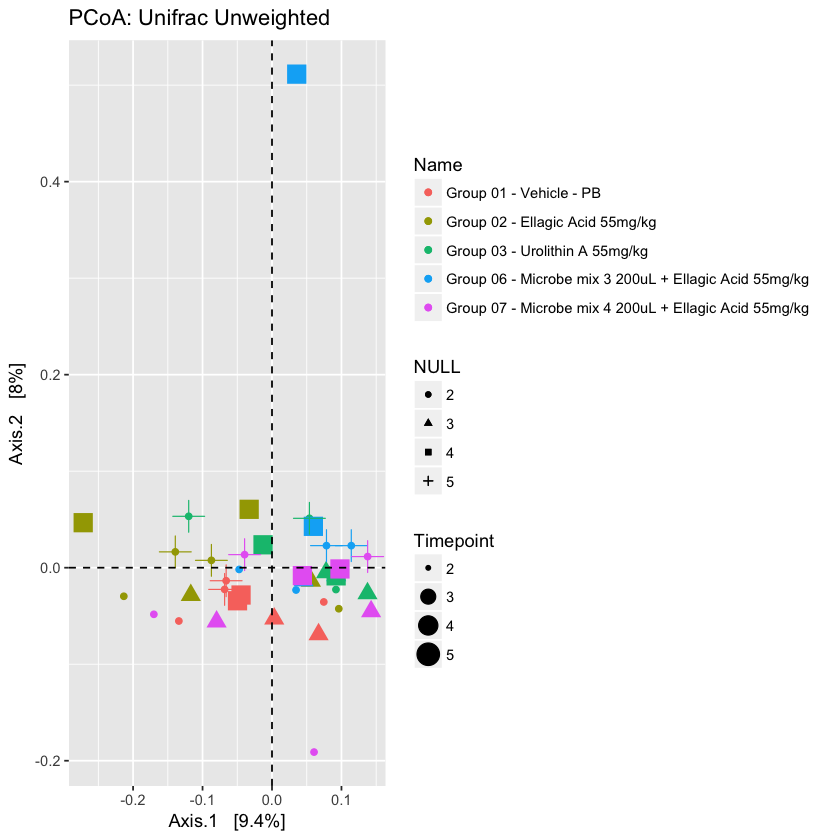

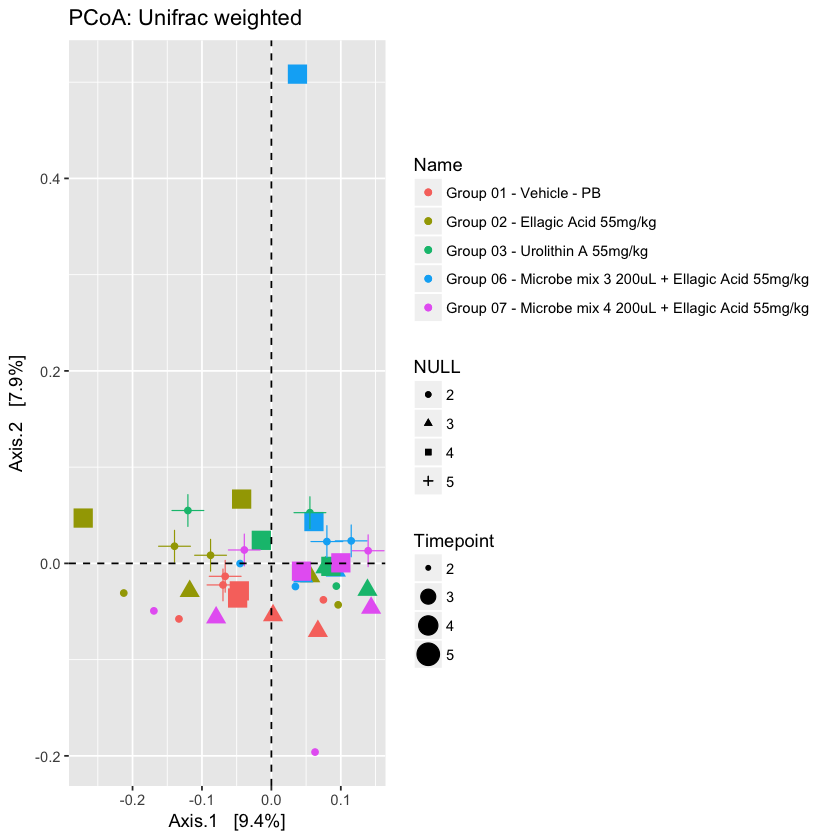

In [73]:
plot_ordination(group12367rarefyna1, ordUWF, color = "Name") + 
  geom_point(mapping = aes(size = Timepoint, 
                           shape = factor(Timepoint))) +
  ggtitle("PCoA: Unifrac Unweighted")+ geom_hline(yintercept=0,linetype=2) + 
  geom_vline(xintercept=0,linetype=2) 

plot_ordination(group12367rarefyna1, ordWF, color = "Name") + 
  geom_point(mapping = aes(size = Timepoint, 
                           shape = factor(Timepoint))) +
  ggtitle("PCoA: Unifrac weighted")+ geom_hline(yintercept=0,linetype=2) + 
  geom_vline(xintercept=0,linetype=2) 

Warning message:
“Ignoring unknown aesthetics: na.rm”

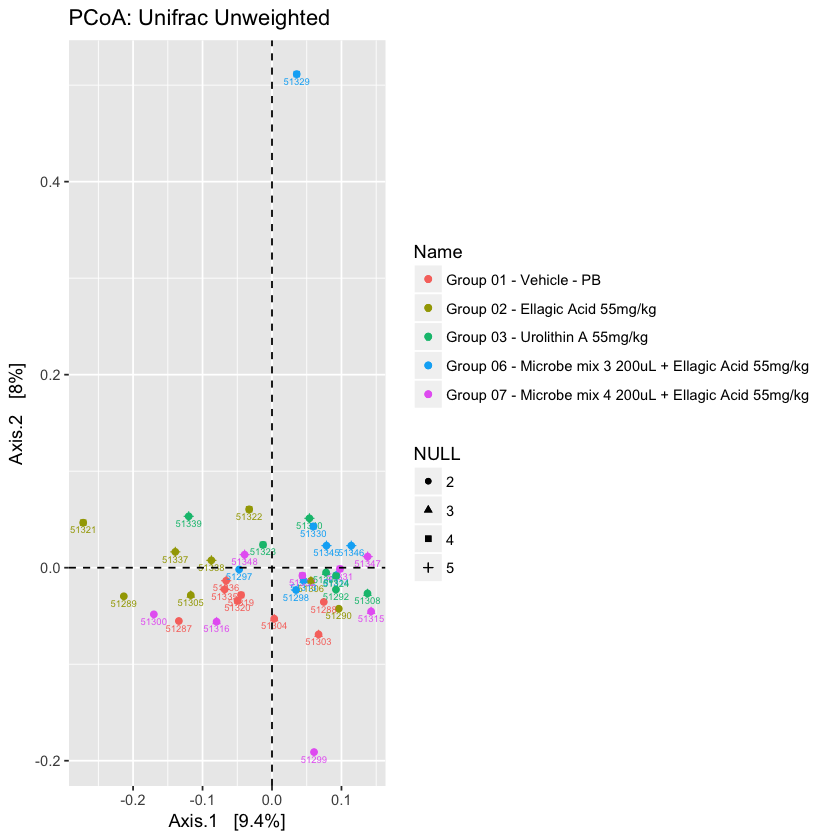

In [75]:
# very large outsider lets see what it is
plot_ordination(group12367rarefyna1, ordUWF, color = "Name",label="Description") + 
  geom_point(mapping = aes( 
                           shape = factor(Timepoint))) +
  ggtitle("PCoA: Unifrac Unweighted")+ geom_hline(yintercept=0,linetype=2) + 
  geom_vline(xintercept=0,linetype=2) 



In [80]:
#51329is a large outsider lets remove that
group12367rarefyna1=subset_samples(group12367rarefyna1, Description!='51329')


Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- c72a095701b17c0a577665c5da0e11e3 -- in the phylogenetic tree in the data you provided.”Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- 82d41109dd40277b288a5abfc1229dc3 -- in the phylogenetic tree in the data you provided.”

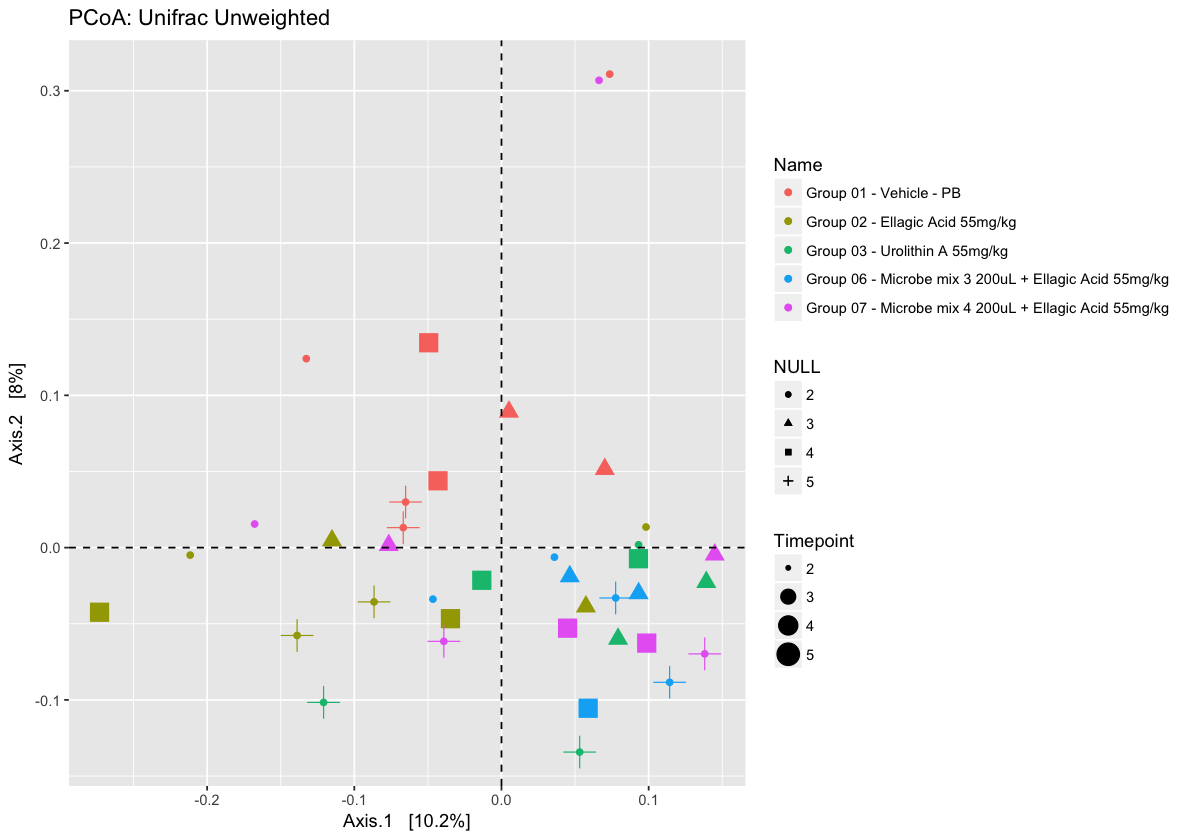

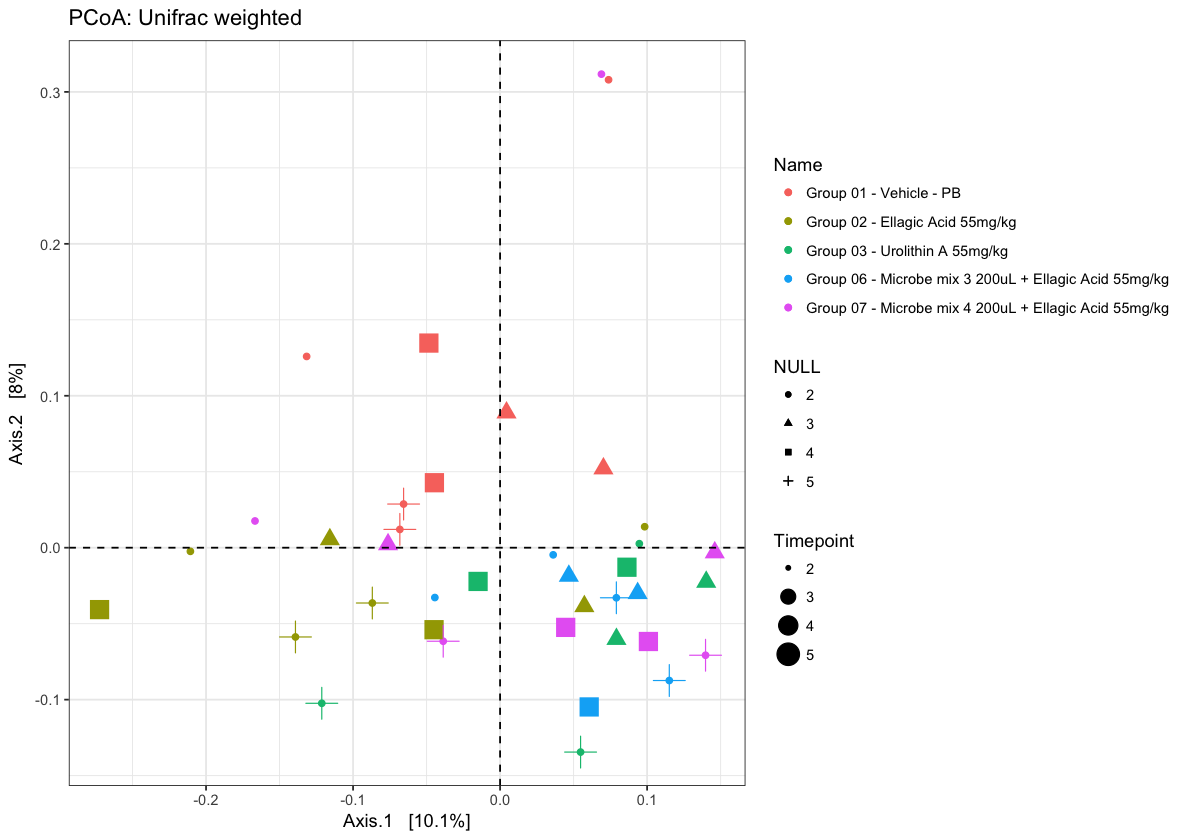

In [100]:
# now the above looks much more spread out lets try to make sense of it
# Calculate distances
library(repr)
options(repr.plot.width=10, repr.plot.height=7)
set.seed(123)
DistBC = distance(group12367rarefyna1, method = "bray")
DistUWF = distance(group12367rarefyna1, method = "unifrac", weighted=FALSE)
DistWF = distance(group12367rarefyna1, method = "unifrac")

#ordination
ordBC = ordinate(group12367rarefyna1, method = "PCoA", distance = DistBC)
ordUWF = ordinate(group12367rarefyna1, method = "PCoA", distance = DistUWF)
ordWF = ordinate(group12367rarefyna1, method = "PCoA", distance = DistWF)

#plot data for unifrac
plot_ordination(group12367rarefyna1, ordUWF, color = "Name") + 
  geom_point(mapping = aes(size = Timepoint, 
                           shape = factor(Timepoint))) +
  ggtitle("PCoA: Unifrac Unweighted")+ geom_hline(yintercept=0,linetype=2) + 
  geom_vline(xintercept=0,linetype=2) 

plot_ordination(group12367rarefyna1, ordWF, color = "Name") + 
  geom_point(mapping = aes(size = Timepoint, 
                           shape = factor(Timepoint))) +
  ggtitle("PCoA: Unifrac weighted")+ geom_hline(yintercept=0,linetype=2) + 
  geom_vline(xintercept=0,linetype=2) +theme_bw()

In [82]:
set.seed(123)
print('Unweighted Unifram Permanova')
a=adonis(DistUWF ~  prebiotic+Timepoint+ Name, as(sample_data(group12367rarefyna1), "data.frame"), permutations=10000, method='unifrac', weighted=FALSE)
a$aov.tab
print('Weighted Unifram Permanova')
a=adonis(DistWF ~  prebiotic+Timepoint+ Name, as(sample_data(group12367rarefyna1), "data.frame"), permutations=10000, method='unifrac')
a$aov.tab

[1] "Unweighted Unifram Permanova"


Df SumsOfSqs MeanSqs    F.Model  R2         Pr(>F)    
prebiotic  2 0.3464876 0.17324382 1.753004 0.08732936 0.00009999
Timepoint  1 0.1762714 0.17627135 1.783638 0.04442774 0.00049995
Name       2 0.2823782 0.14118912 1.428651 0.07117111 0.00309969
Residuals 32 3.1624591 0.09882685       NA 0.79707179         NA
Total     37 3.9675963         NA       NA 1.00000000         NA

[1] "Weighted Unifram Permanova"


Df SumsOfSqs MeanSqs    F.Model  R2         Pr(>F)    
prebiotic  2 0.3491827 0.17459135 1.751212 0.08724677 0.00019998
Timepoint  1 0.1775815 0.17758146 1.781204 0.04437050 0.00149985
Name       2 0.2851603 0.14258015 1.430129 0.07125014 0.00259974
Residuals 32 3.1903175 0.09969742       NA 0.79713259         NA
Total     37 4.0022419         NA       NA 1.00000000         NA

# So all our important factors are having an effect on the bacteria community. Lets try to tase this out further. We were using  unconstrained ordinations be (PCoA, NMDS) which are used to show relationships between samples in low dimensions. We can use a constrained ordination to see how environmental variables are associated with these changes in community composition. We constrain the ordination axes to linear combinations of environmental variables. We then plot the environmental scores onto the ordination

In [83]:
#Load libraries
library(ggplot2)
library(vegan)
library(dplyr)
library(scales)
library(grid)
library(reshape2)
library(phyloseq)

## Start with dataset that includes timepoint1

Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- ca1b77b409cd1ddbe2de7860e7521f79 -- in the phylogenetic tree in the data you provided.”Warning message:
“Ignoring unknown aesthetics: shape, label”Warning message:
“Ignoring unknown aesthetics: shape”

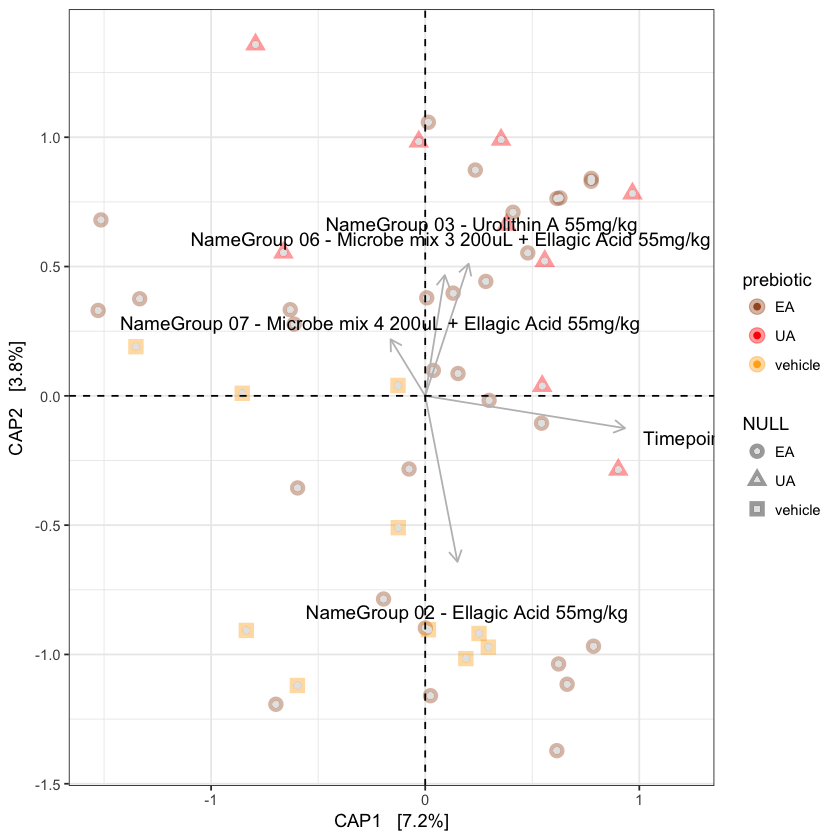

In [90]:
# Remove data points with missing metadata
erie_not_na <- group12367rarefy %>%
  subset_samples(
    !is.na(Name)  
     
  )

bray_not_na <- phyloseq::distance(physeq = erie_not_na, method = "unifrac")
# CAP ordinate
cap_ord <- ordinate(
    physeq = erie_not_na, 
    method = "CAP",
    distance = bray_not_na,
    formula = ~ Name + Timepoint + Sample +prebiotic
)

# CAP plot
cap_plot <- plot_ordination(
  physeq = erie_not_na, 
  ordination = cap_ord, 
    color = "prebiotic", 
    axes = c(1,2)
) + geom_point(aes(colour = prebiotic, shape=as.factor(prebiotic), size=Timepoint), alpha = 0.4, size = 4)+   geom_point(colour = "grey90") + 
    scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
        "#1919ff", "darkorchid3", "magenta")
    )

# Now add the environmental variables as arrows
arrowmat <- vegan::scores(cap_ord, display = "bp")

# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = CAP1, 
    yend = CAP2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.3 * CAP1, 
    y = 1.3 * CAP2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

# Make a new graphic
cap_plot + 
  geom_segment(
    mapping = arrow_map, 
    size = .5, 
    data = arrowdf, 
    color = "gray", 
    arrow = arrowhead
  ) + 
  geom_text(
    mapping = label_map, 
    size = 4,  
    data = arrowdf, 
    show.legend = FALSE
  )+ geom_hline(yintercept=0,linetype=2) + 
  geom_vline(xintercept=0,linetype=2) +theme_bw()



Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- c72a095701b17c0a577665c5da0e11e3 -- in the phylogenetic tree in the data you provided.”Warning message:
“Ignoring unknown aesthetics: shape, label”Warning message:
“Ignoring unknown aesthetics: shape”

Df SumOfSqs  F       Pr(>F)
Model     5 0.8051372 1.62939 0.001 
Residual 32 3.1624591      NA    NA

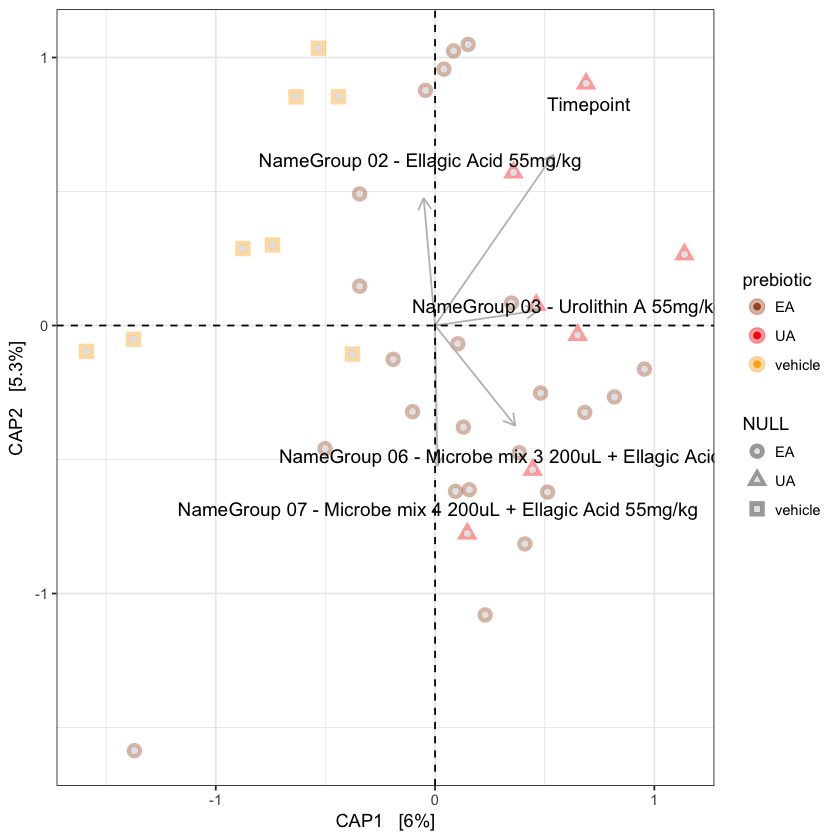

In [93]:

###################################
#lets ignore time 1--------------
########################################
# Remove data points with missing metadata
set.seed(123)

erie_not_na <- group12367rarefyna1 %>%
  subset_samples(
    !is.na(Name)  
     
  )

bray_not_na <- phyloseq::distance(physeq = erie_not_na, method = "unifrac")
# CAP ordinate
cap_ord <- ordinate(
    physeq = erie_not_na, 
    method = "CAP",
    distance = bray_not_na,
    formula = ~ Name + Timepoint + Sample +prebiotic
)

# CAP plot
cap_plot <- plot_ordination(
  physeq = erie_not_na, 
  ordination = cap_ord, 
    color = "prebiotic", 
    axes = c(1,2)
) + geom_point(aes(colour = prebiotic, shape=as.factor(prebiotic), size=Timepoint), alpha = 0.4, size = 4)+   geom_point(colour = "grey90") + 
    scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
        "#1919ff", "darkorchid3", "magenta")
    )

# Now add the environmental variables as arrows
arrowmat <- vegan::scores(cap_ord, display = "bp")

# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = CAP1, 
    yend = CAP2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.3 * CAP1, 
    y = 1.3 * CAP2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

# Make a new graphic
cap_plot + 
  geom_segment(
    mapping = arrow_map, 
    size = .5, 
    data = arrowdf, 
    color = "gray", 
    arrow = arrowhead
  ) + 
  geom_text(
    mapping = label_map, 
    size = 4,  
    data = arrowdf, 
    show.legend = FALSE
  )+ geom_hline(yintercept=0,linetype=2) + 
  geom_vline(xintercept=0,linetype=2) +theme_bw()

# do a permuational analysis on constrained axes usined in ordination
anova(cap_ord)

In [ ]:
#pretty clear seperation above from those samples which were only vehicle vs those that hasd any sort of prebiotic
# or probiotic in it

Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- c72a095701b17c0a577665c5da0e11e3 -- in the phylogenetic tree in the data you provided.”Warning message:
“Ignoring unknown aesthetics: shape, label”Warning message:
“Ignoring unknown aesthetics: shape”

Df SumOfSqs  F       Pr(>F)
Model     5 0.8051372 1.62939 0.001 
Residual 32 3.1624591      NA    NA

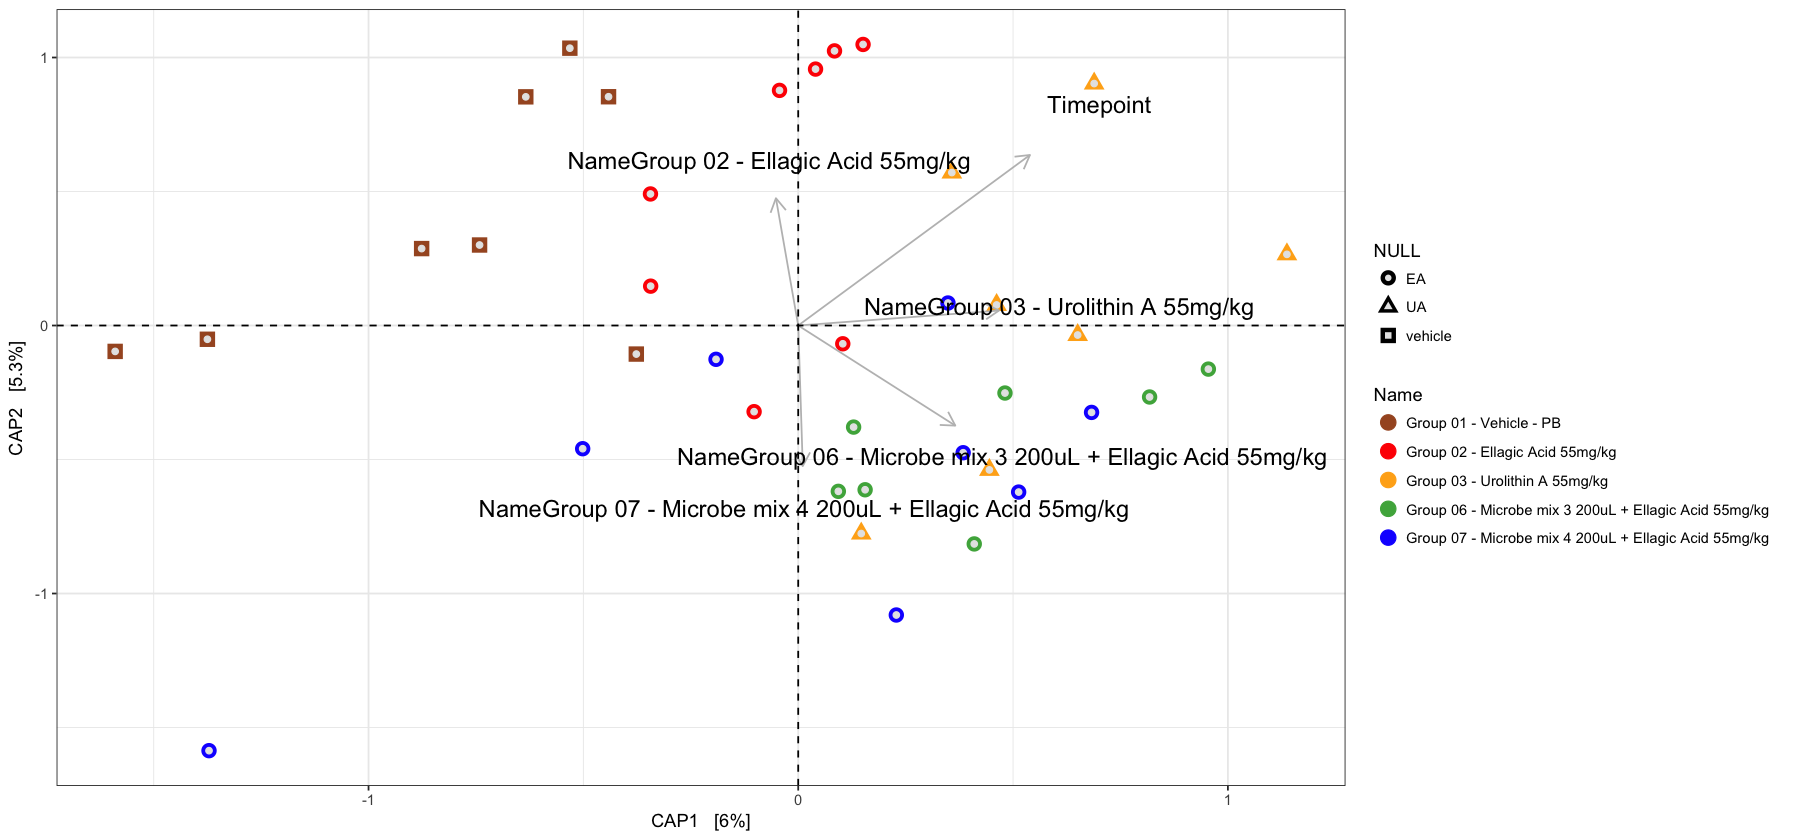

In [475]:
# lets color based on name of treatment
library(repr)
options(repr.plot.width=15, repr.plot.height=7)
#pdf('pdf/constrained ordination.pdf',width=12, height=10)

###################################
#lets ignore time 1--------------
########################################
# Remove data points with missing metadata
set.seed(123)

erie_not_na <- group12367rarefyna1 %>%
  subset_samples(
    !is.na(Name)  
     
  )

bray_not_na <- phyloseq::distance(physeq = erie_not_na, method = "unifrac")
# CAP ordinate
cap_ord <- ordinate(
    physeq = erie_not_na, 
    method = "CAP",
    distance = bray_not_na,
    formula = ~ Name + Timepoint + Sample +prebiotic
)

# CAP plot
cap_plot <- plot_ordination(
  physeq = erie_not_na, 
  ordination = cap_ord, 
    color = "Name", 
    axes = c(1,2)
) + geom_point(aes(colour = Name, shape=as.factor(prebiotic), size=Timepoint), alpha = 1, size = 4)+   geom_point(colour = "grey90") + 
    scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
        "#1919ff", "darkorchid3", "magenta")
    )

# Now add the environmental variables as arrows
arrowmat <- vegan::scores(cap_ord, display = "bp")

# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = CAP1, 
    yend = CAP2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.3 * CAP1, 
    y = 1.3 * CAP2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

# Make a new graphic
cap_plot + 
  geom_segment(
    mapping = arrow_map, 
    size = .5, 
    data = arrowdf, 
    color = "gray", 
    arrow = arrowhead
  ) + 
  geom_text(
    mapping = label_map, 
    size = 5,  
    data = arrowdf, 
    show.legend = FALSE
  )+ geom_hline(yintercept=0,linetype=2) + 
  geom_vline(xintercept=0,linetype=2) +theme_bw()
#dev.off()
# do a permuational analysis on constrained axes usined in ordination
anova(cap_ord)

In [ ]:
# we see a clear seperation in bacterial community composition based on treatment and addition of microbe

# Barplots

In [107]:
##########################################
#---Merge samples based on Name of treatment
#########################################

#DNA---------
#If you dont merge your percent abundace will accumulate in a per sample basis
physeq.noNA.rm = merge_samples(group12367rarefyna1, "Name")

#Repair the merged values associated with each surface after merge. 
sample_data(physeq.noNA.rm)$Name <- levels(sample_data(group12367)$Name)

#transform to percent total abudnance
physeq.noNA.rm = transform_sample_counts(physeq.noNA.rm, function(x) 100 * x/sum(x))

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

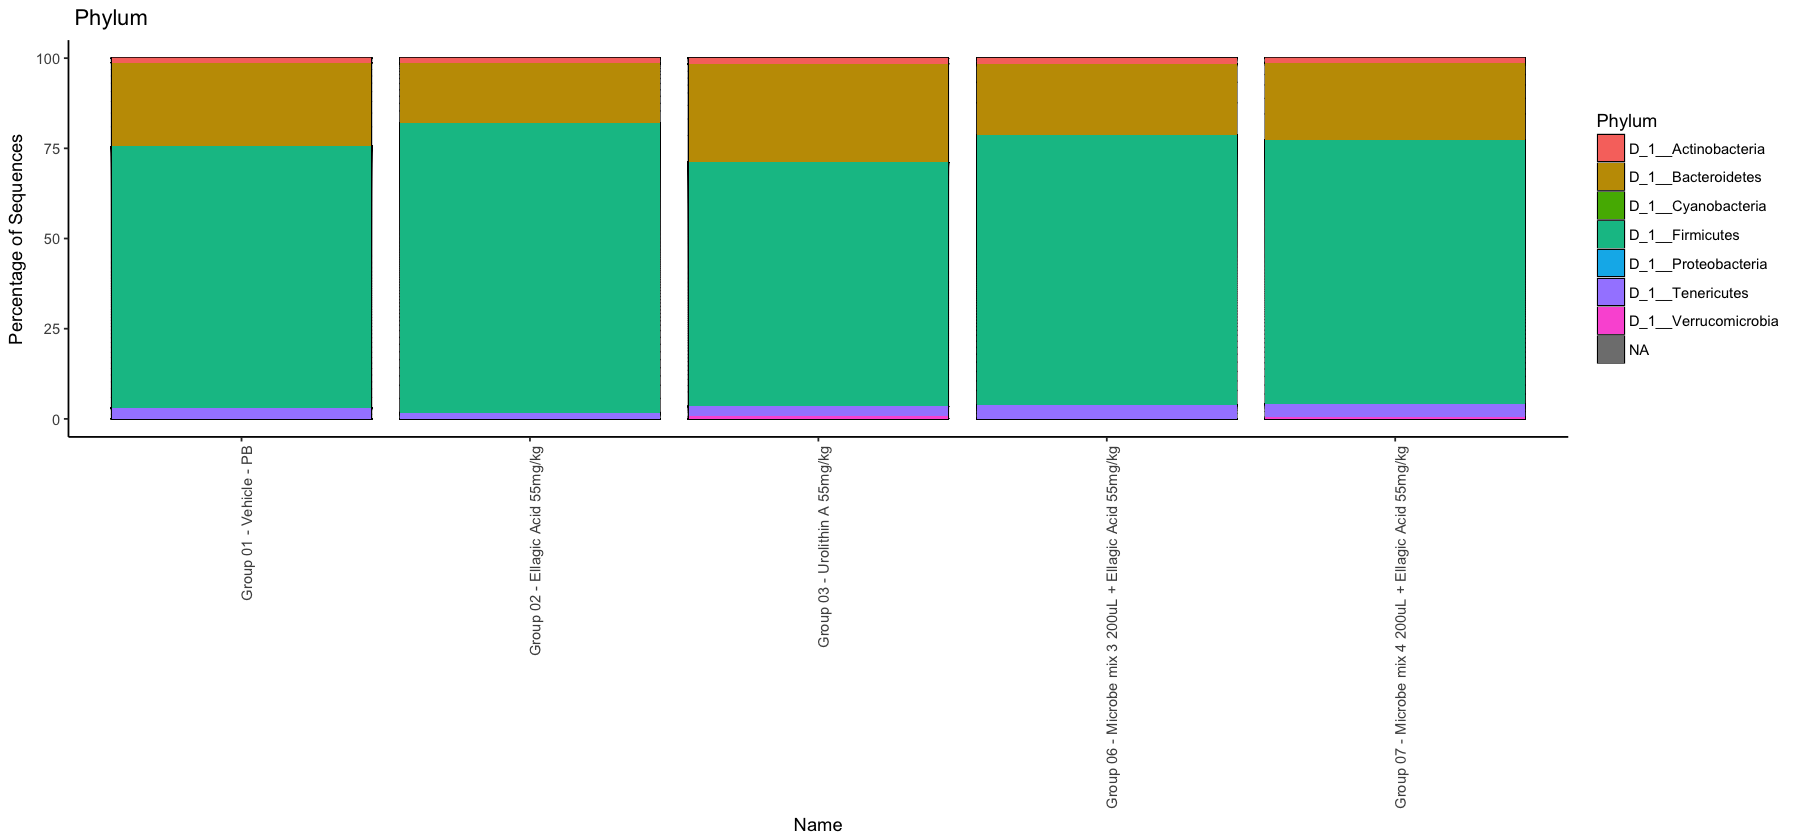

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

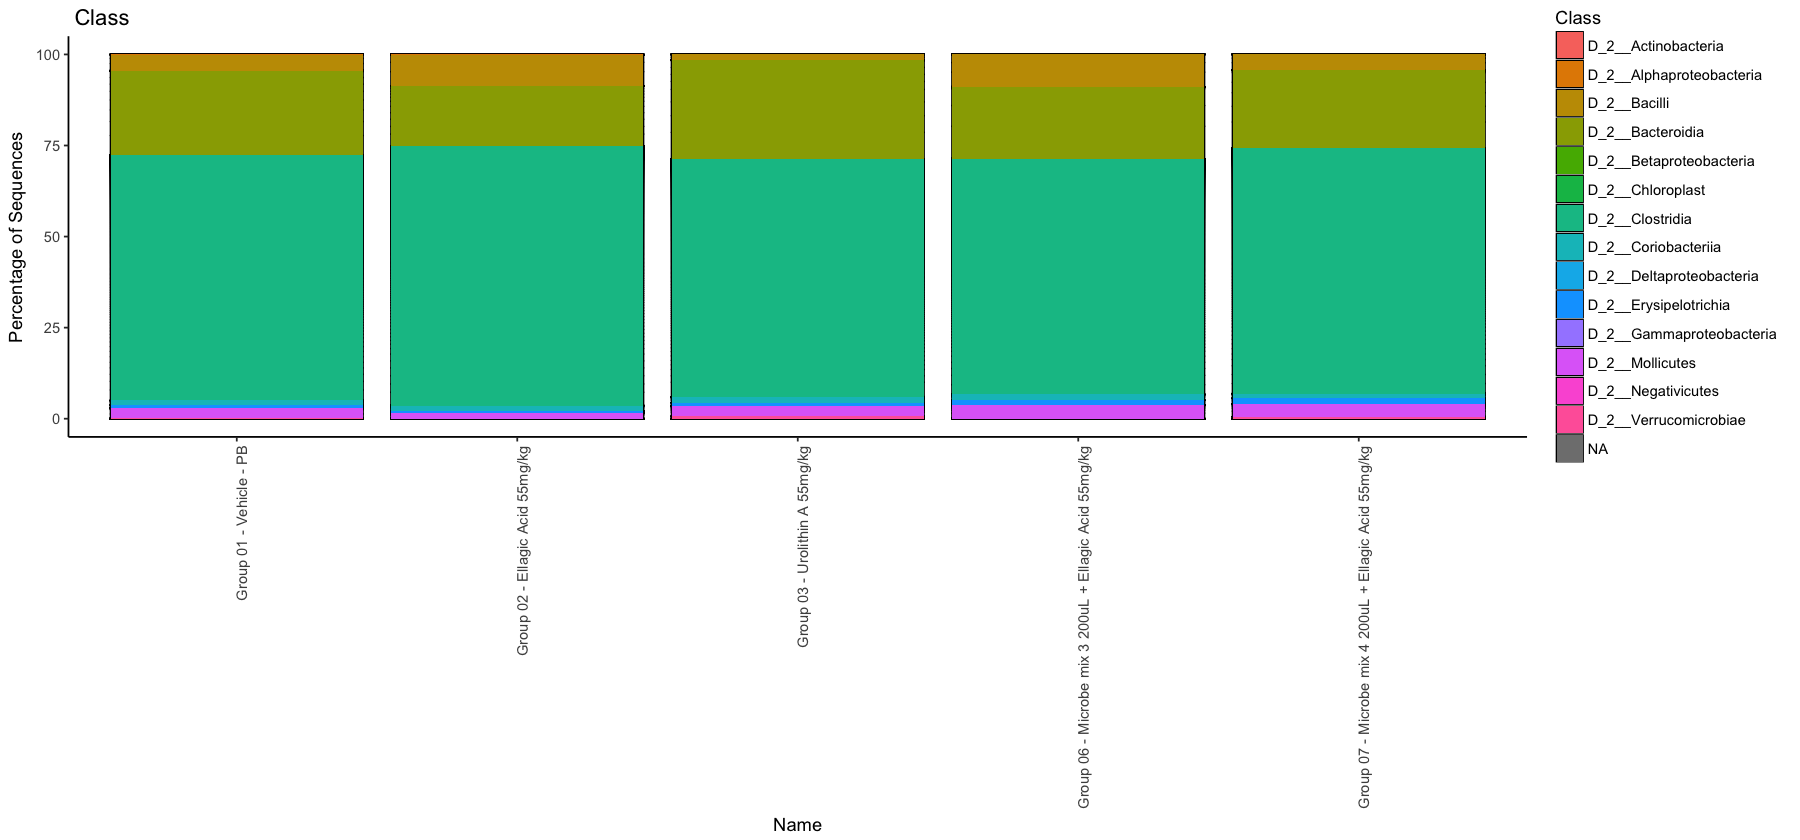

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

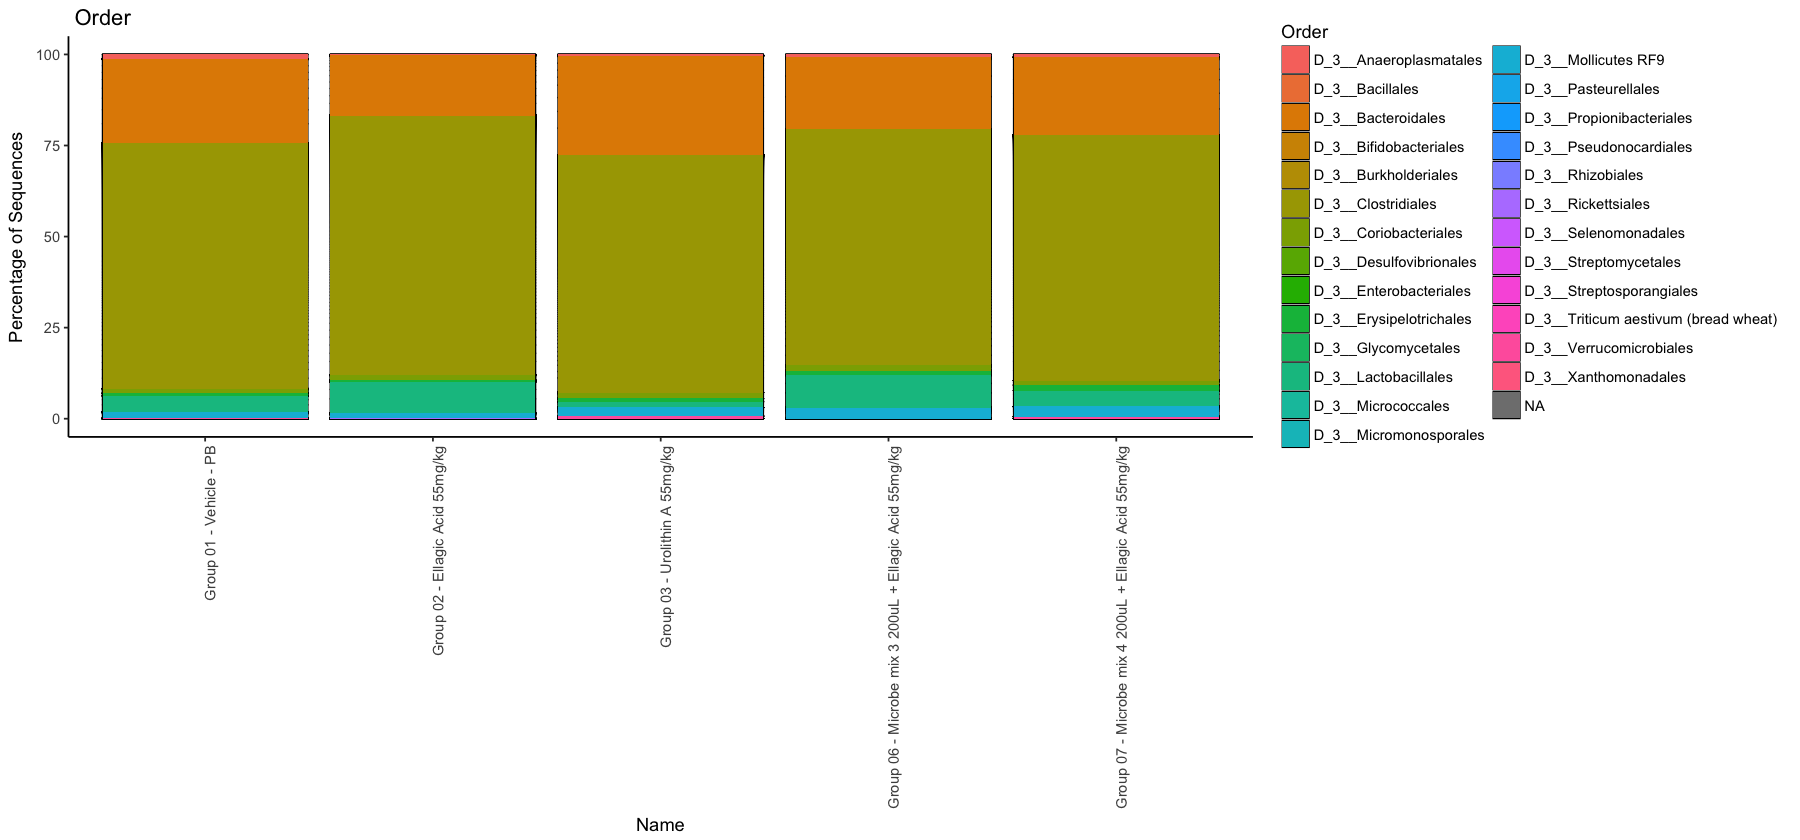

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

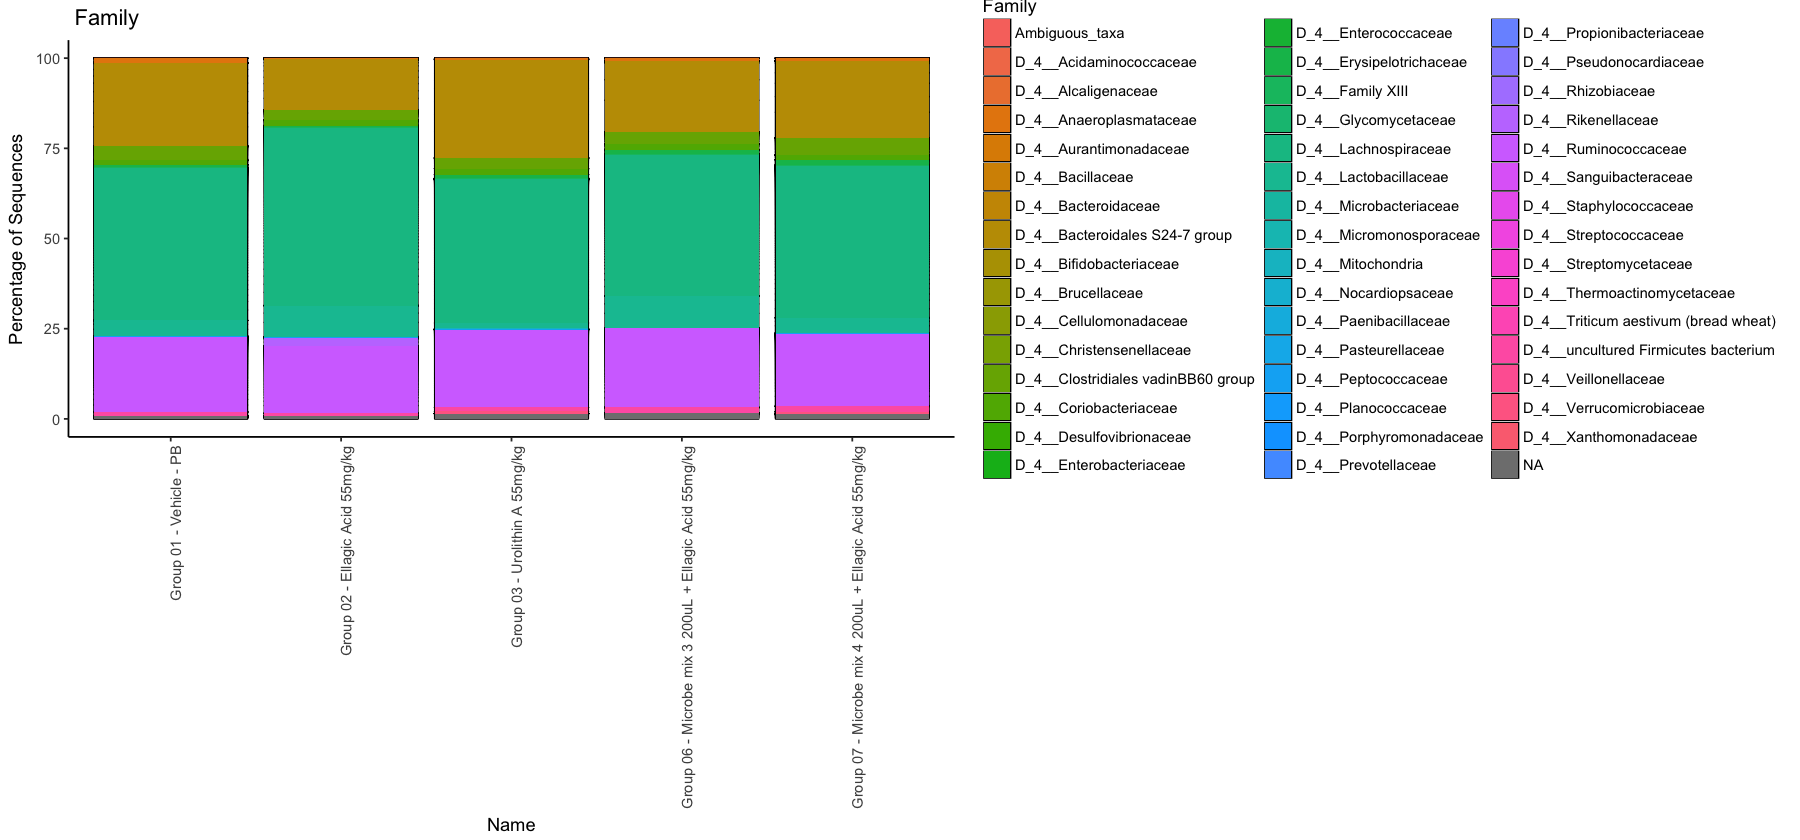

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

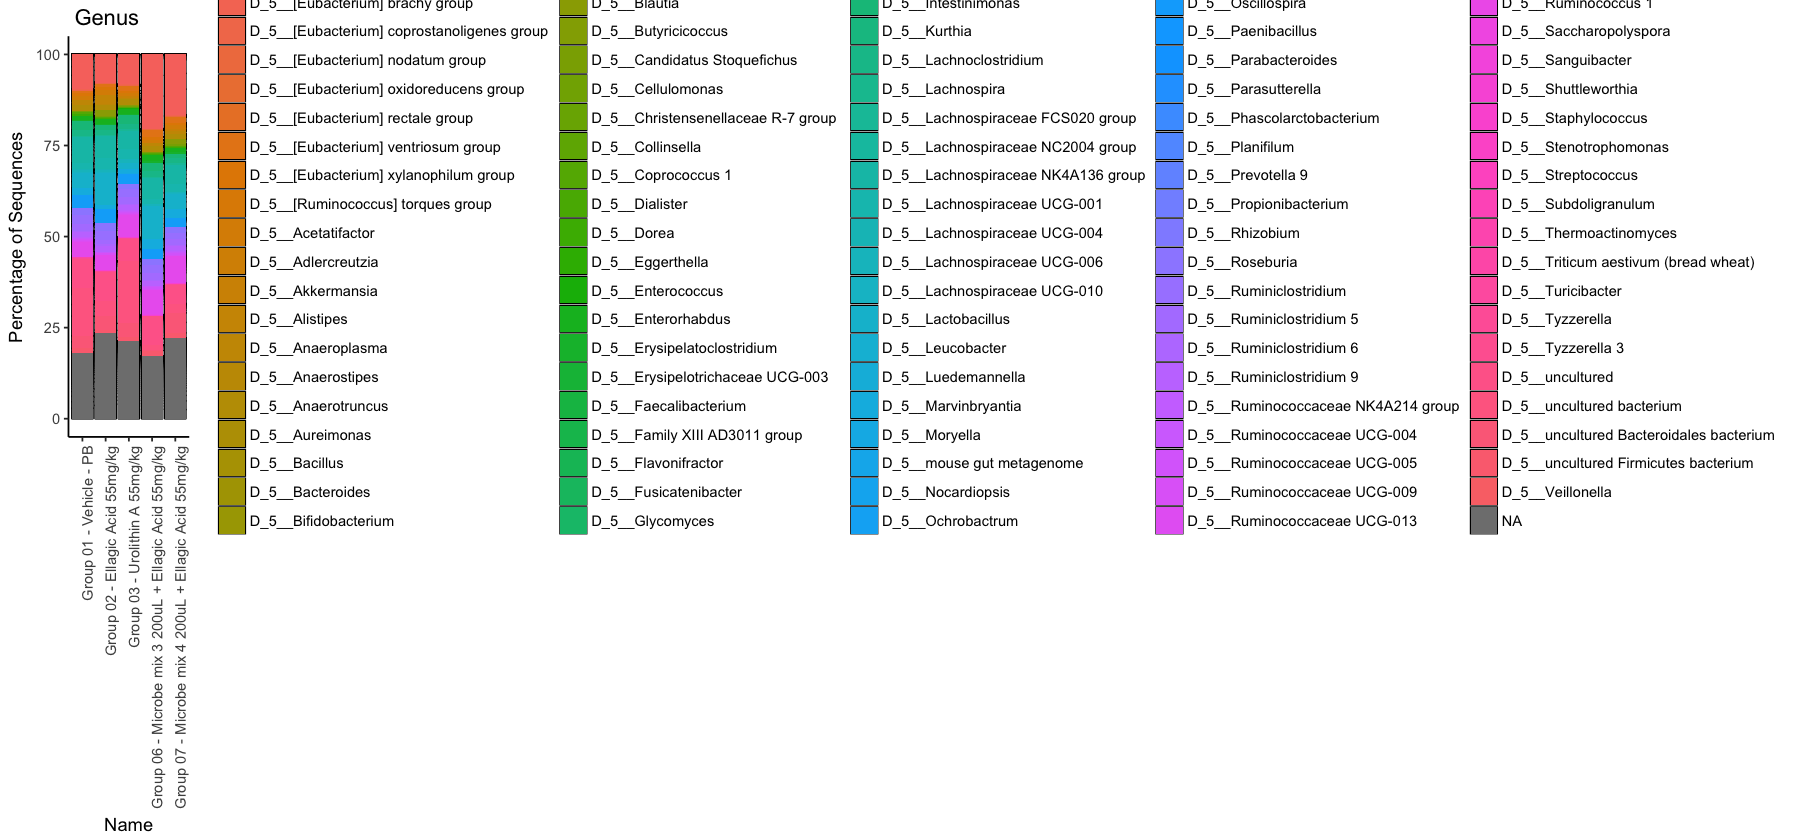

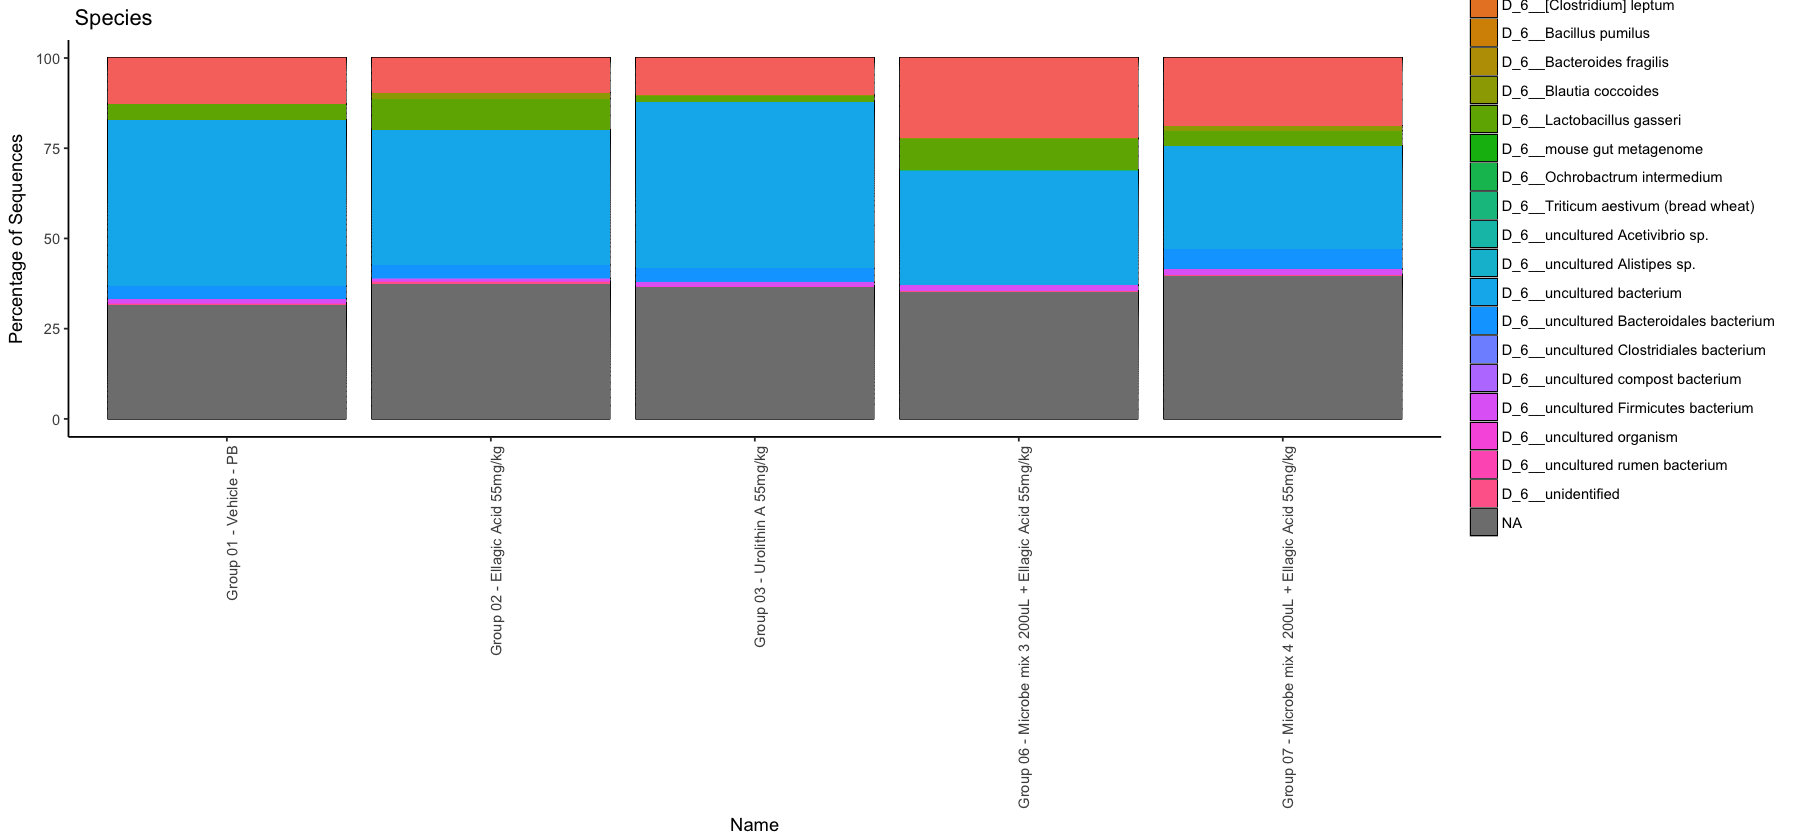

In [108]:
#percent abundance plot
#pdf('Final.PDF/DNA/top20_closed_barplot_p_c_o_f_g_s.pdf')


p<-plot_bar(physeq.noNA.rm, x="Name", fill="Phylum",title = " Phylum")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))

p<-plot_bar(physeq.noNA.rm, x="Name", fill="Class",title = " Class")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))
# environemtnal sample s 
p<-plot_bar(physeq.noNA.rm, x="Name", fill="Order",title = " Order")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))

# environemtnal sample s 
p<-plot_bar(physeq.noNA.rm, x="Name", fill="Family",title = " Family")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))


# environemtnal sample s 
p<-plot_bar(physeq.noNA.rm, x="Name", fill="Genus",title = " Genus")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))

# environemtnal sample s 
p<-plot_bar(physeq.noNA.rm, x="Name", fill="Species",title = " Species")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))
#dev.off()

In [110]:
##########################################
#---Merge samples based on Name of treatment
#########################################

#DNA---------
#If you dont merge your percent abundace will accumulate in a per sample basis
physeq.noNA.rm = merge_samples(group12367rarefyna1, "prebiotic")

#Repair the merged values associated with each surface after merge. 
sample_data(physeq.noNA.rm)$prebiotic <- levels(sample_data(group12367)$prebiotic)

#transform to percent total abudnance
physeq.noNA.rm = transform_sample_counts(physeq.noNA.rm, function(x) 100 * x/sum(x))

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

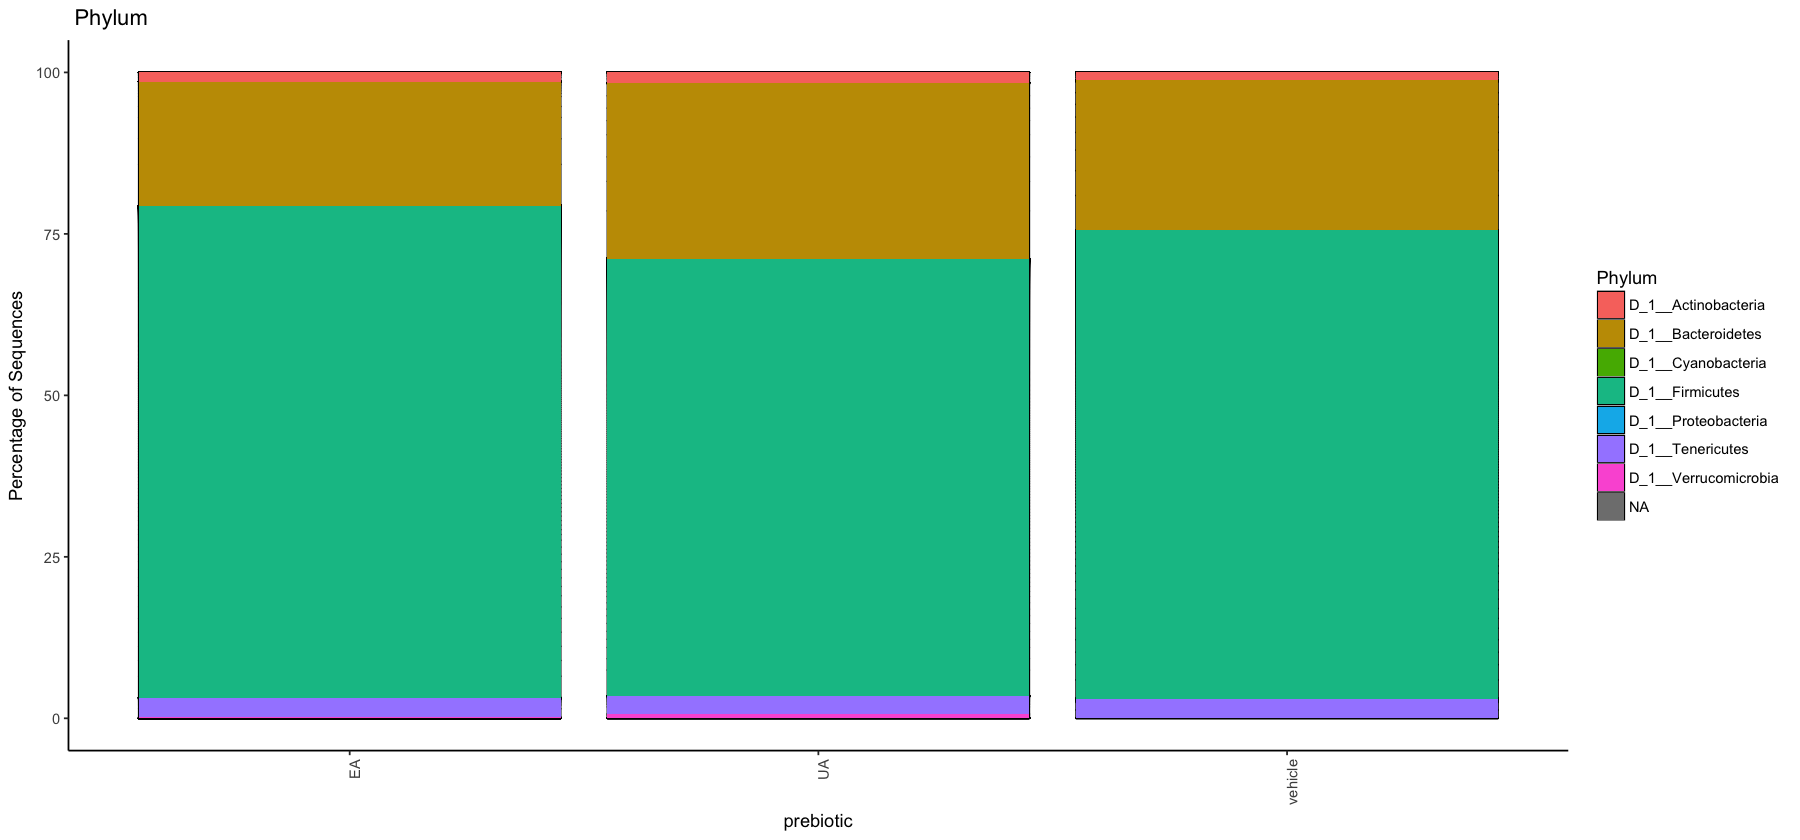

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

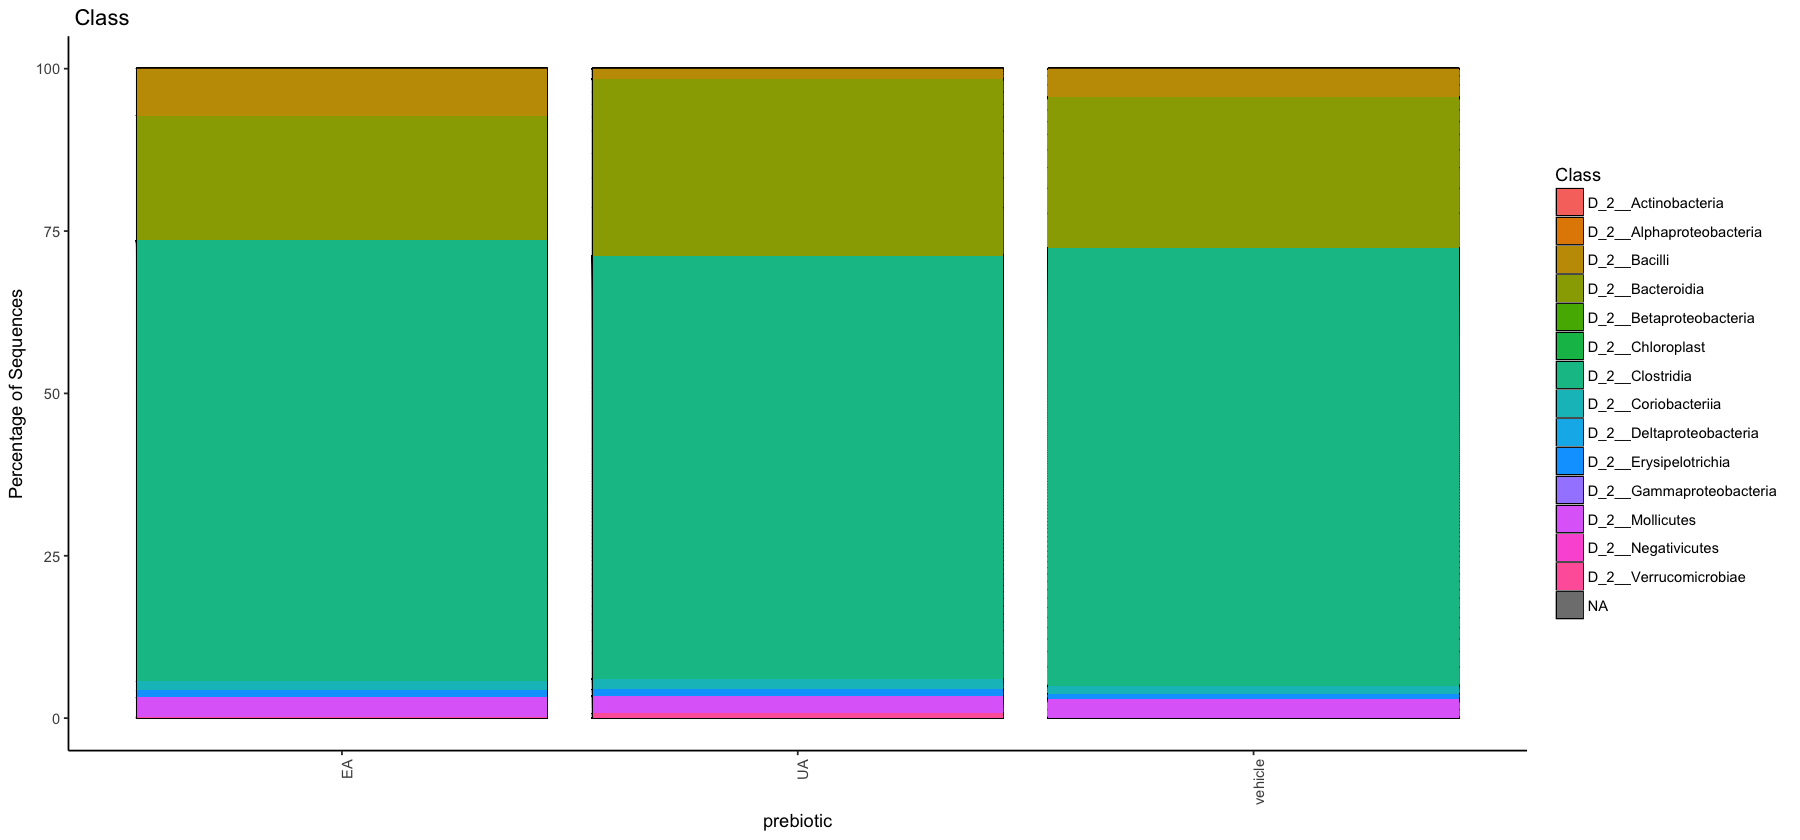

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

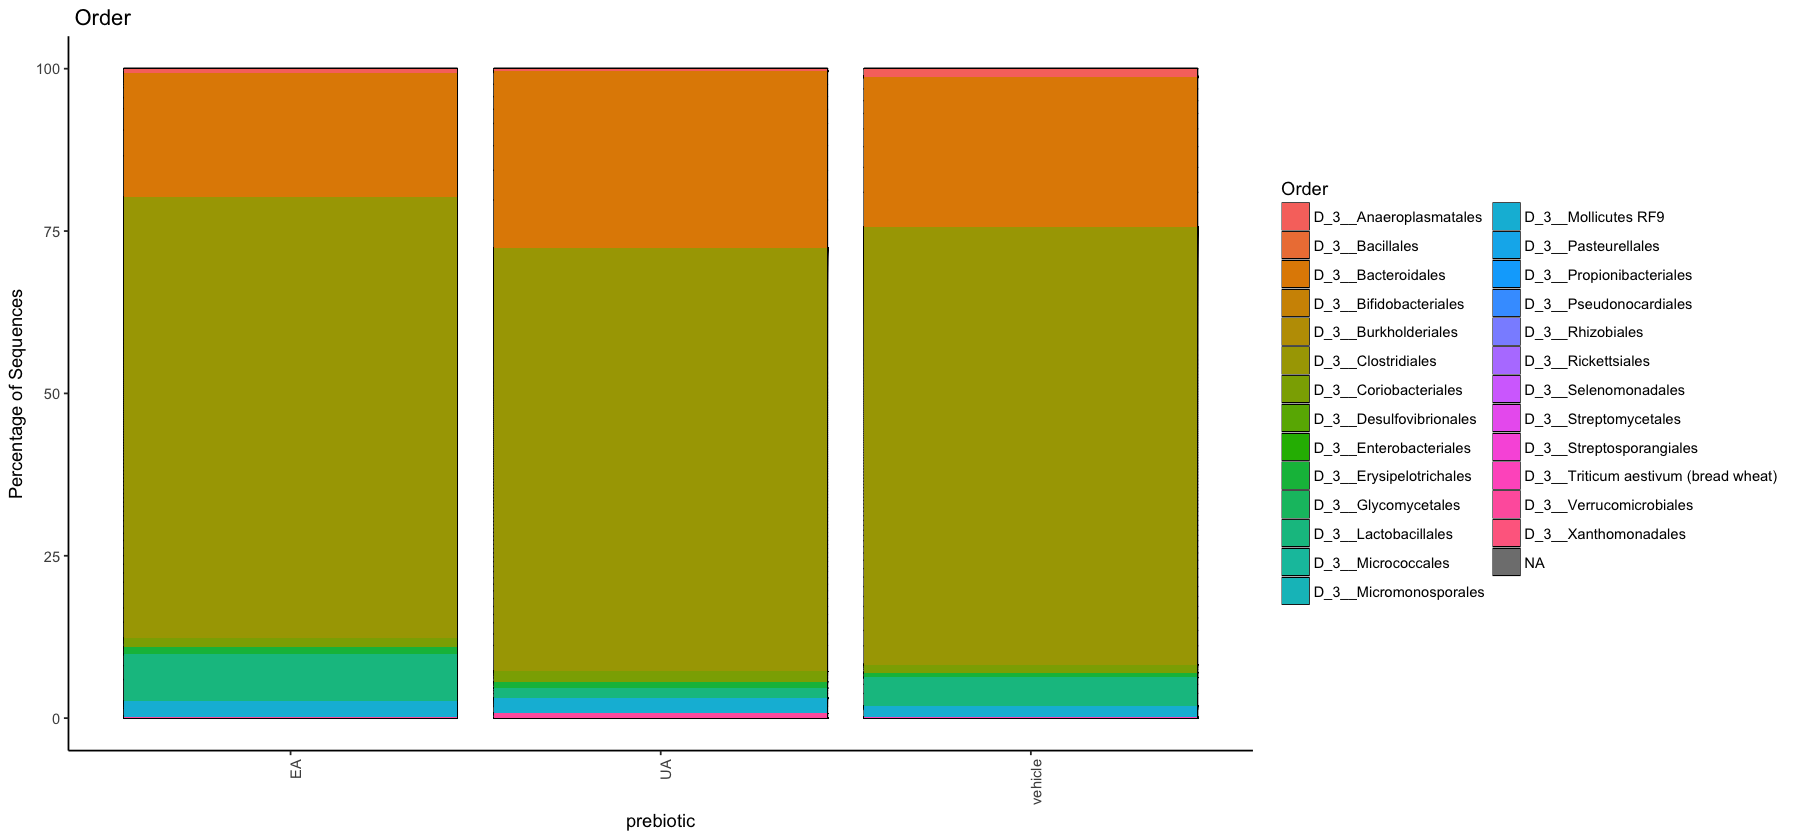

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

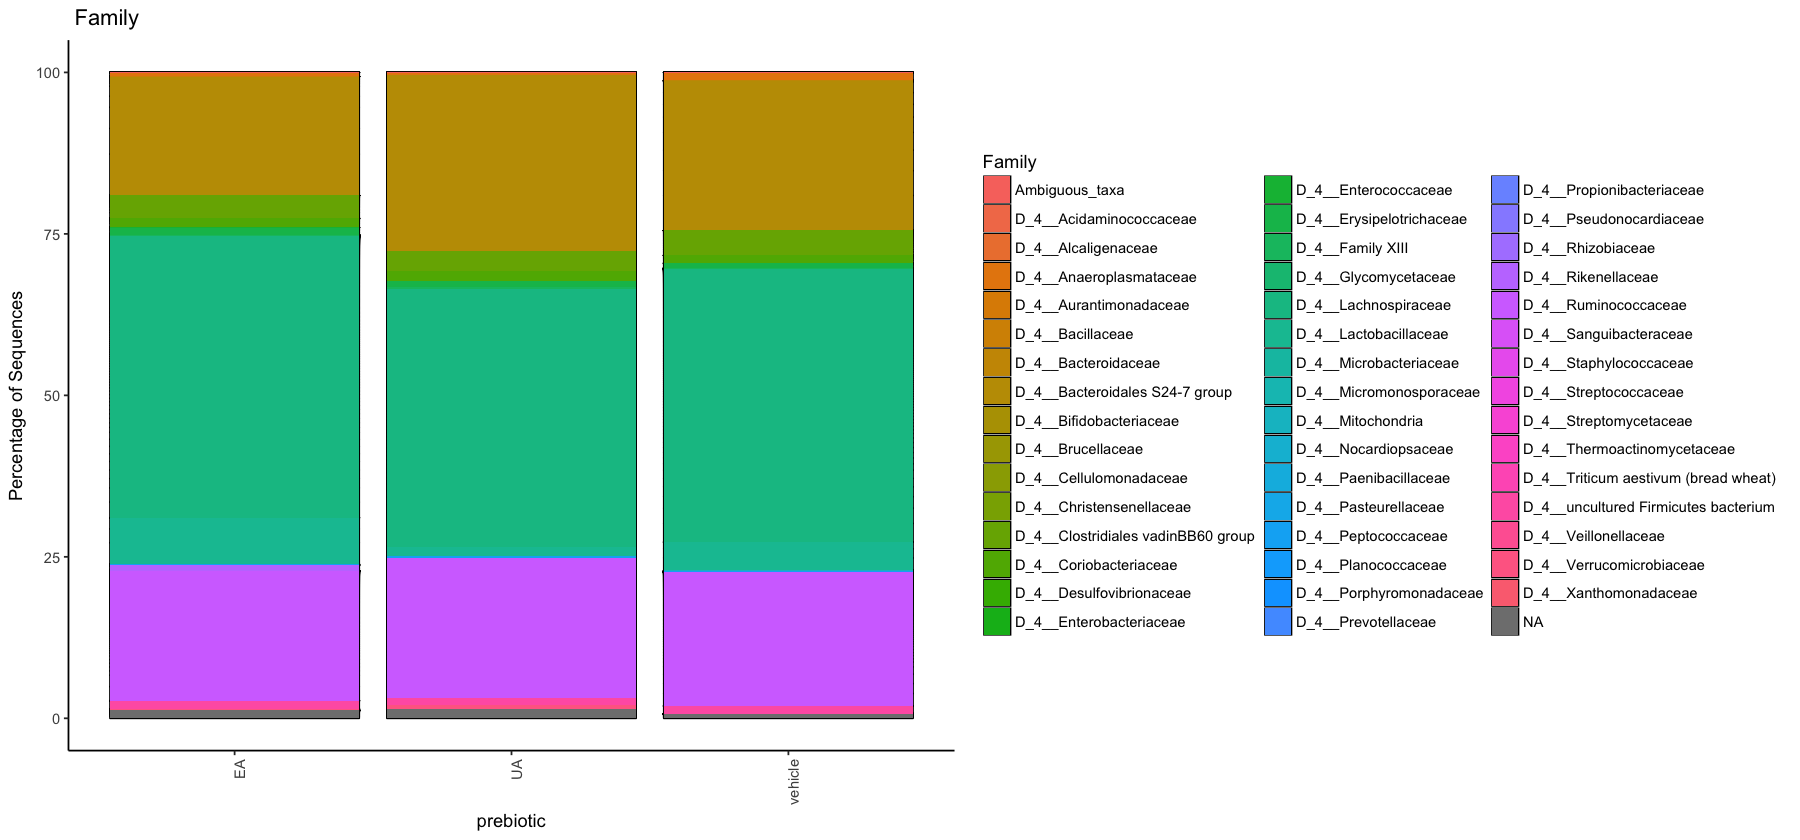

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

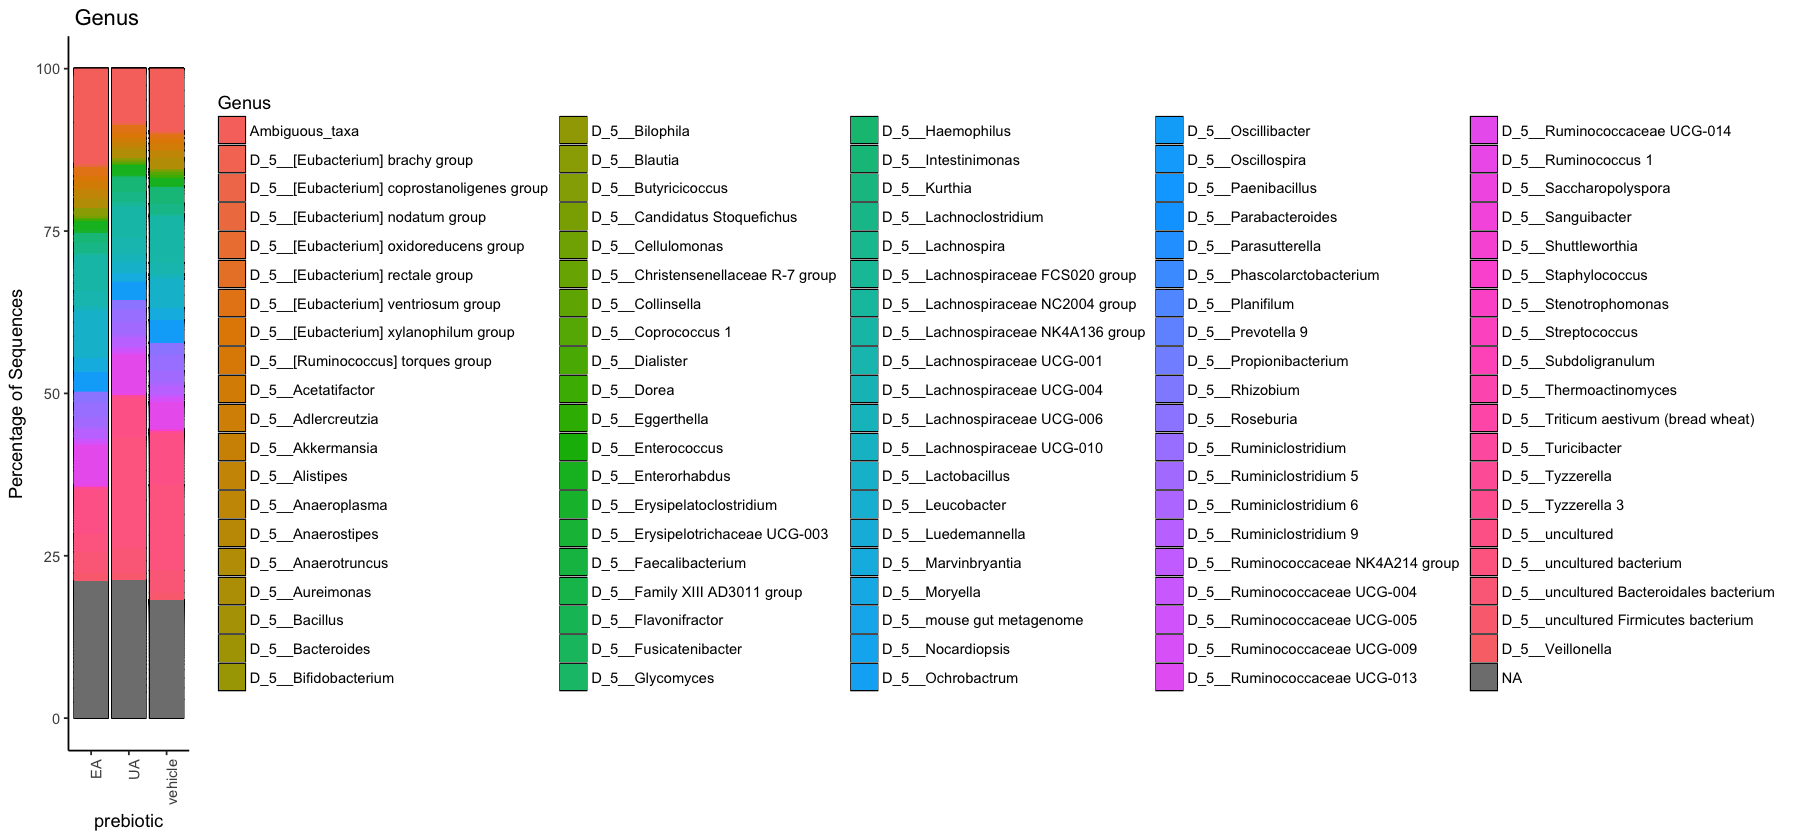

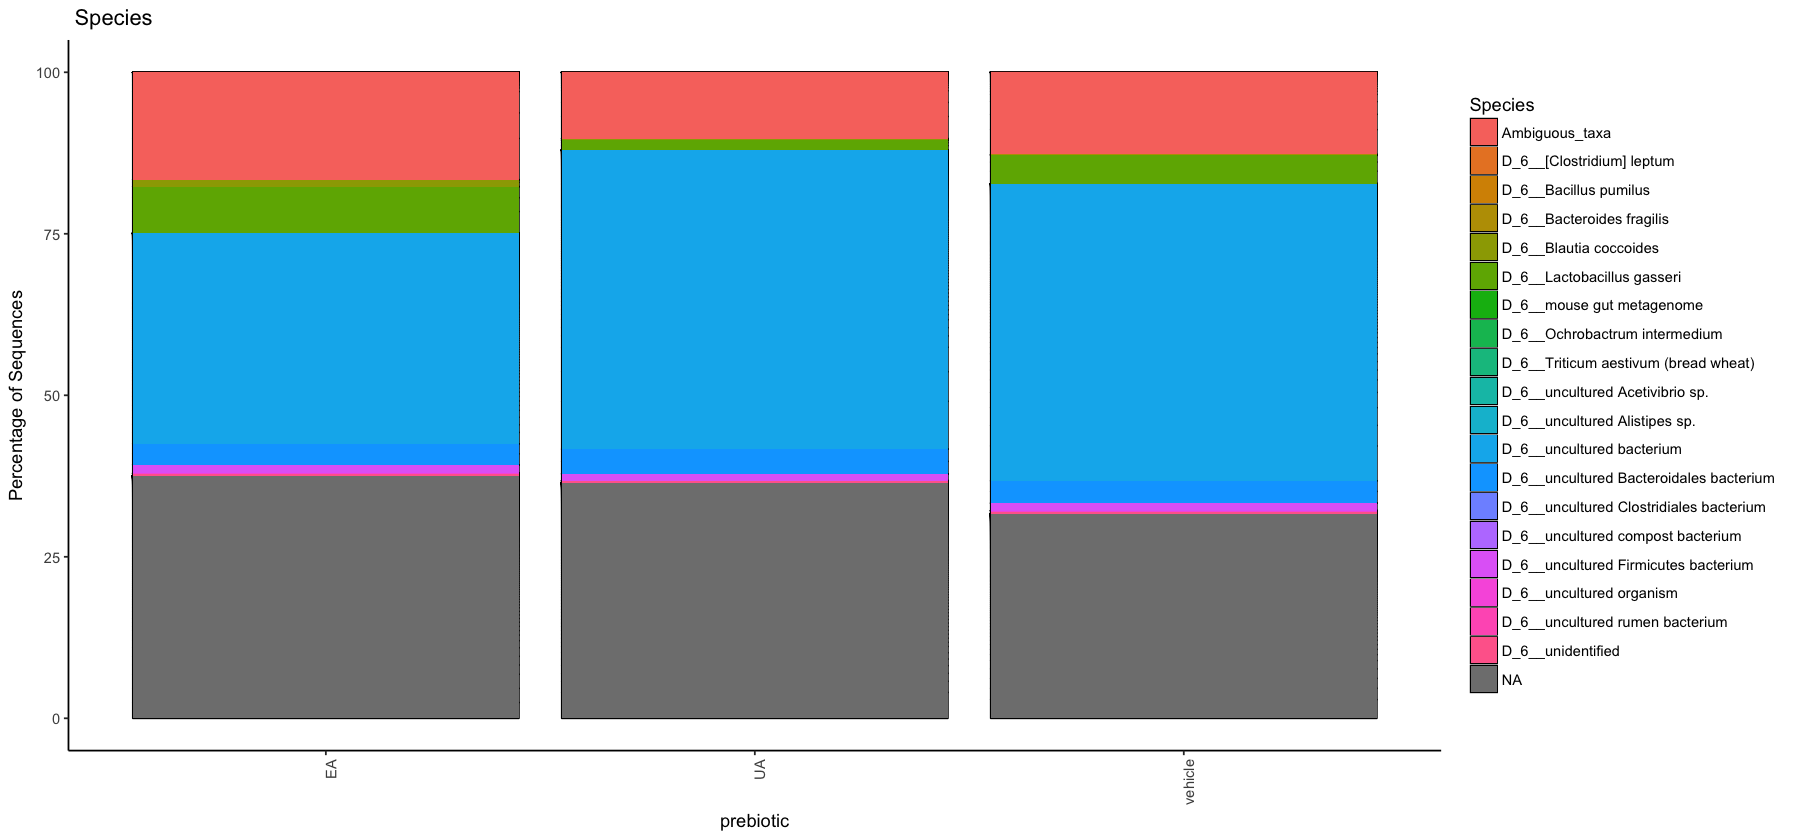

In [112]:
#percent abundance plot
#pdf('Final.PDF/DNA/top20_closed_barplot_p_c_o_f_g_s.pdf')


p<-plot_bar(physeq.noNA.rm, x="prebiotic", fill="Phylum",title = " Phylum")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))

p<-plot_bar(physeq.noNA.rm, x="prebiotic", fill="Class",title = " Class")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))
# environemtnal sample s 
p<-plot_bar(physeq.noNA.rm, x="prebiotic", fill="Order",title = " Order")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))

# environemtnal sample s 
p<-plot_bar(physeq.noNA.rm, x="prebiotic", fill="Family",title = " Family")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))


# environemtnal sample s 
p<-plot_bar(physeq.noNA.rm, x="prebiotic", fill="Genus",title = " Genus")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))

# environemtnal sample s 
p<-plot_bar(physeq.noNA.rm, x="prebiotic", fill="Species",title = " Species")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))
#dev.off()

## barplot top 20

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

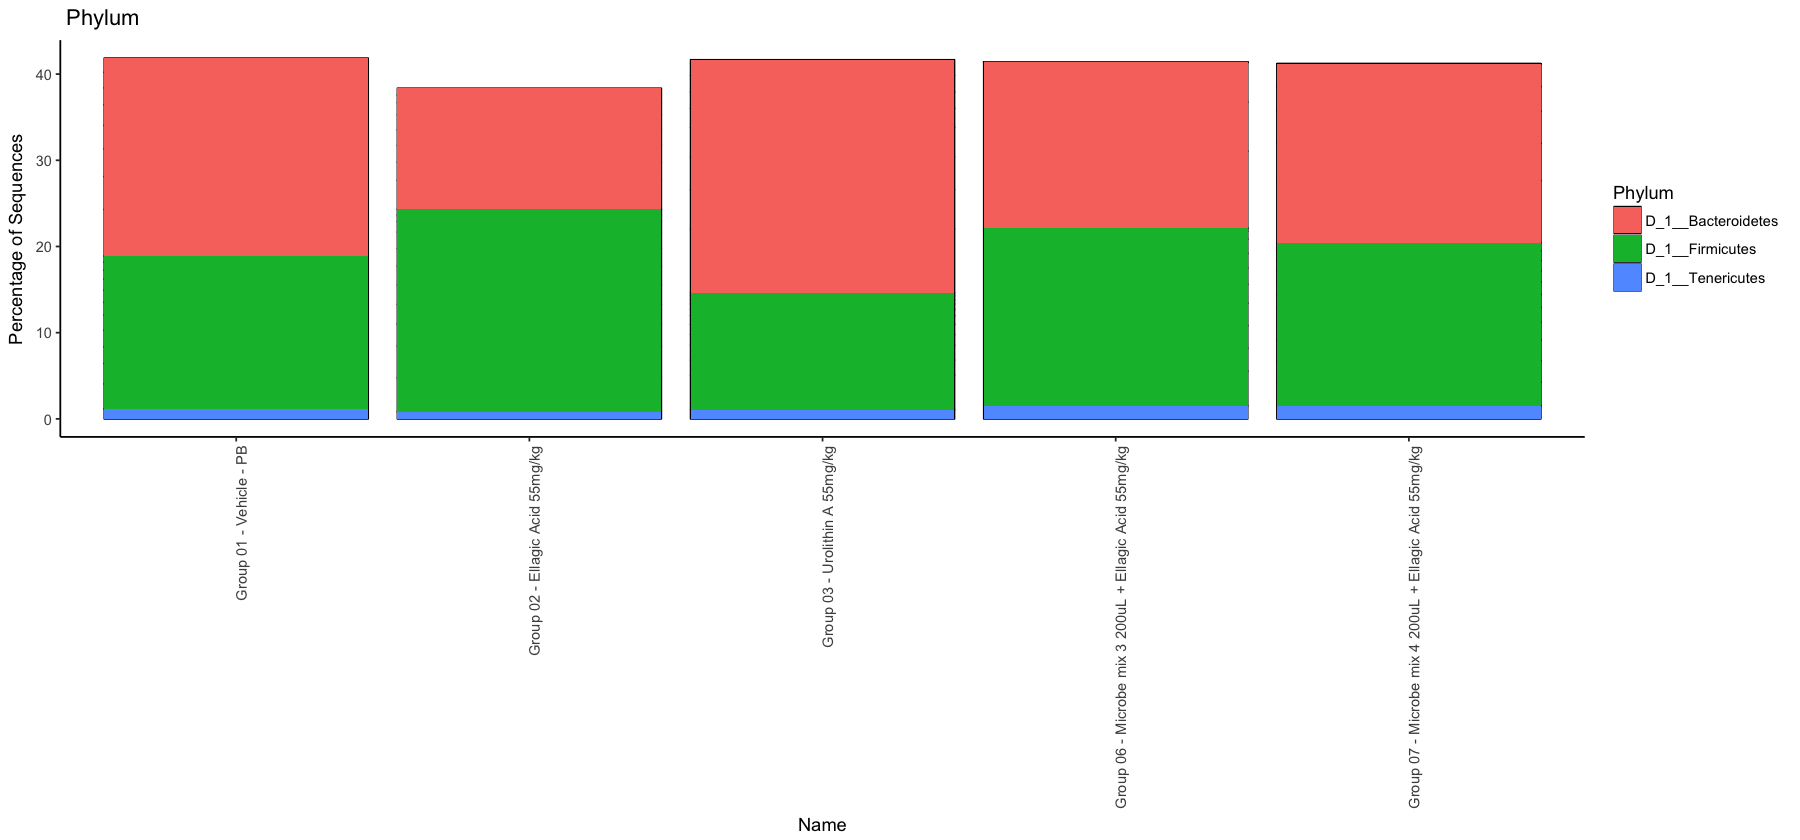

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

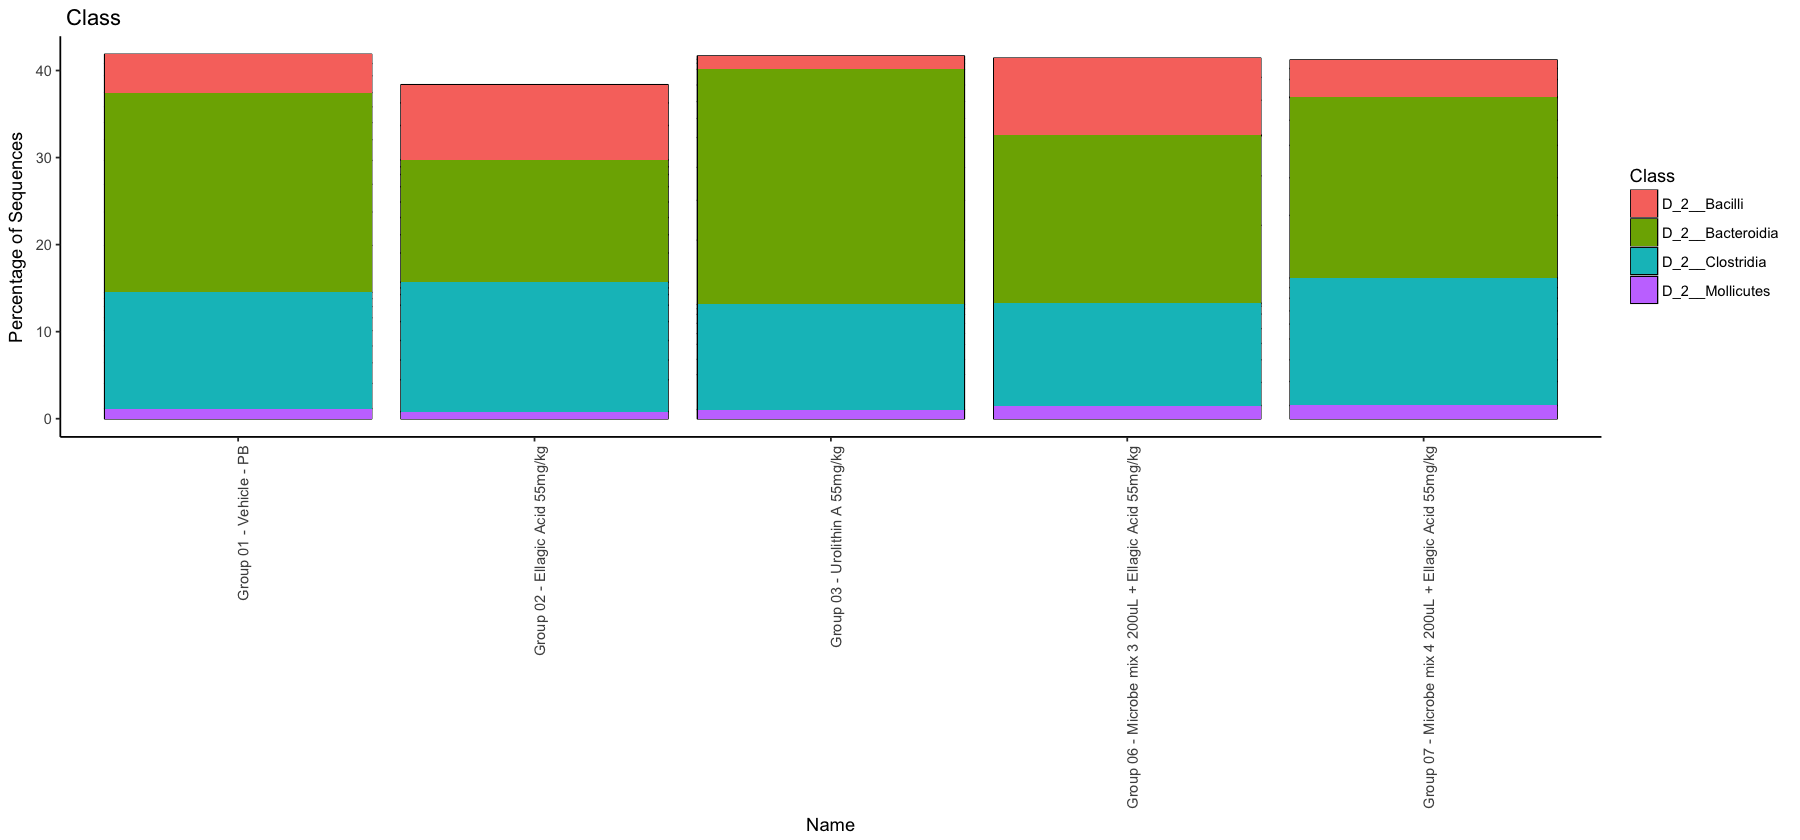

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

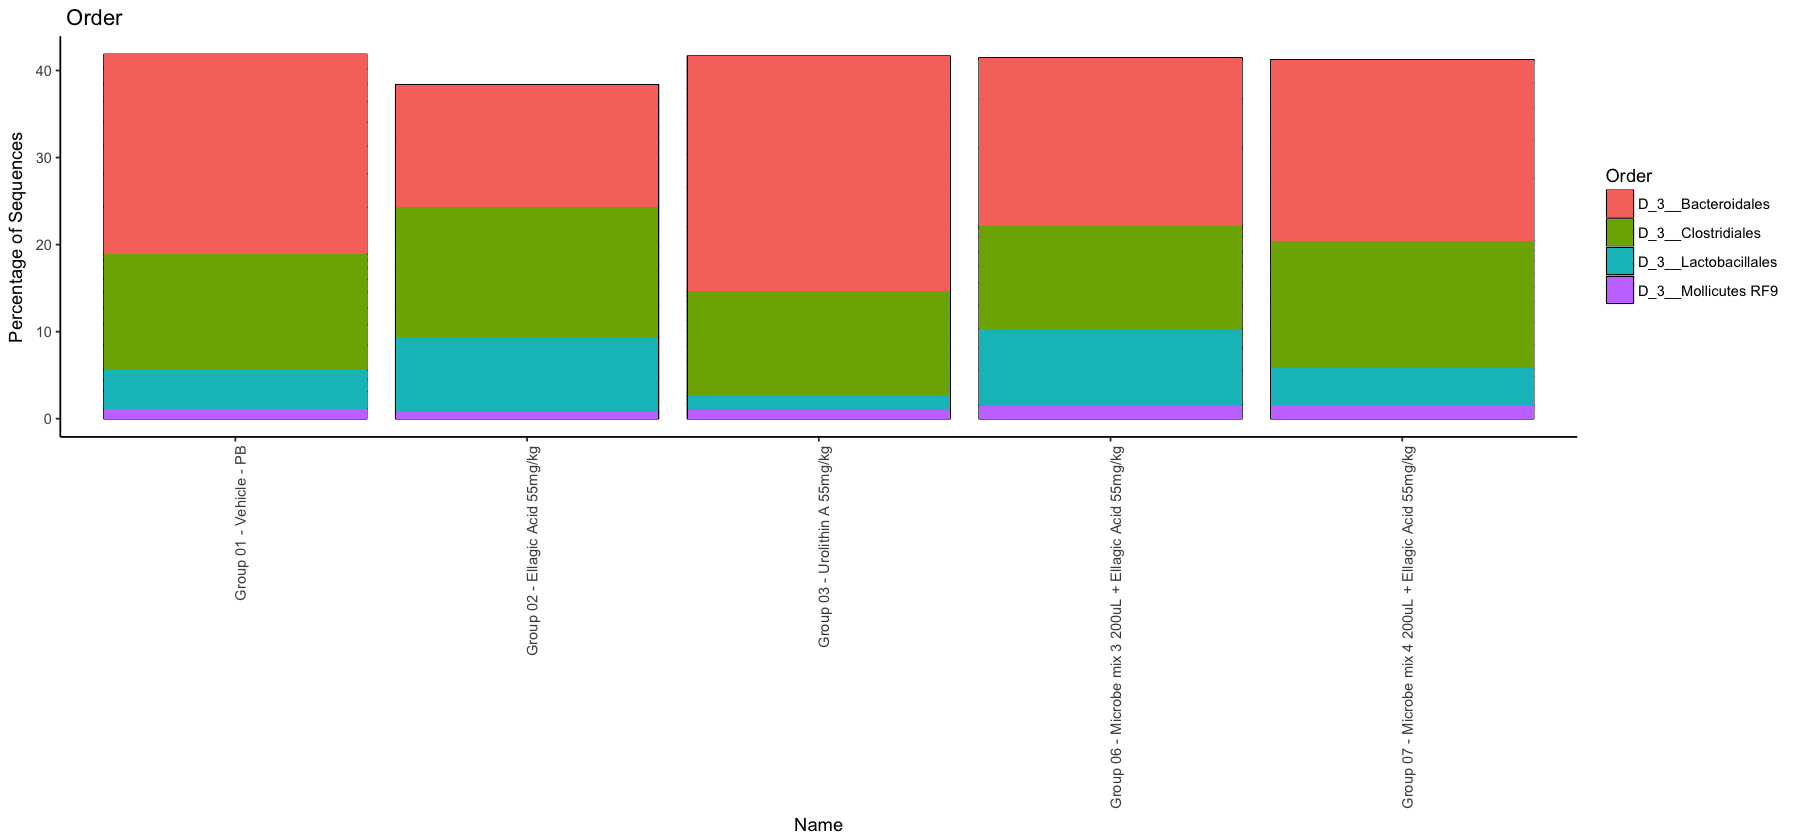

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

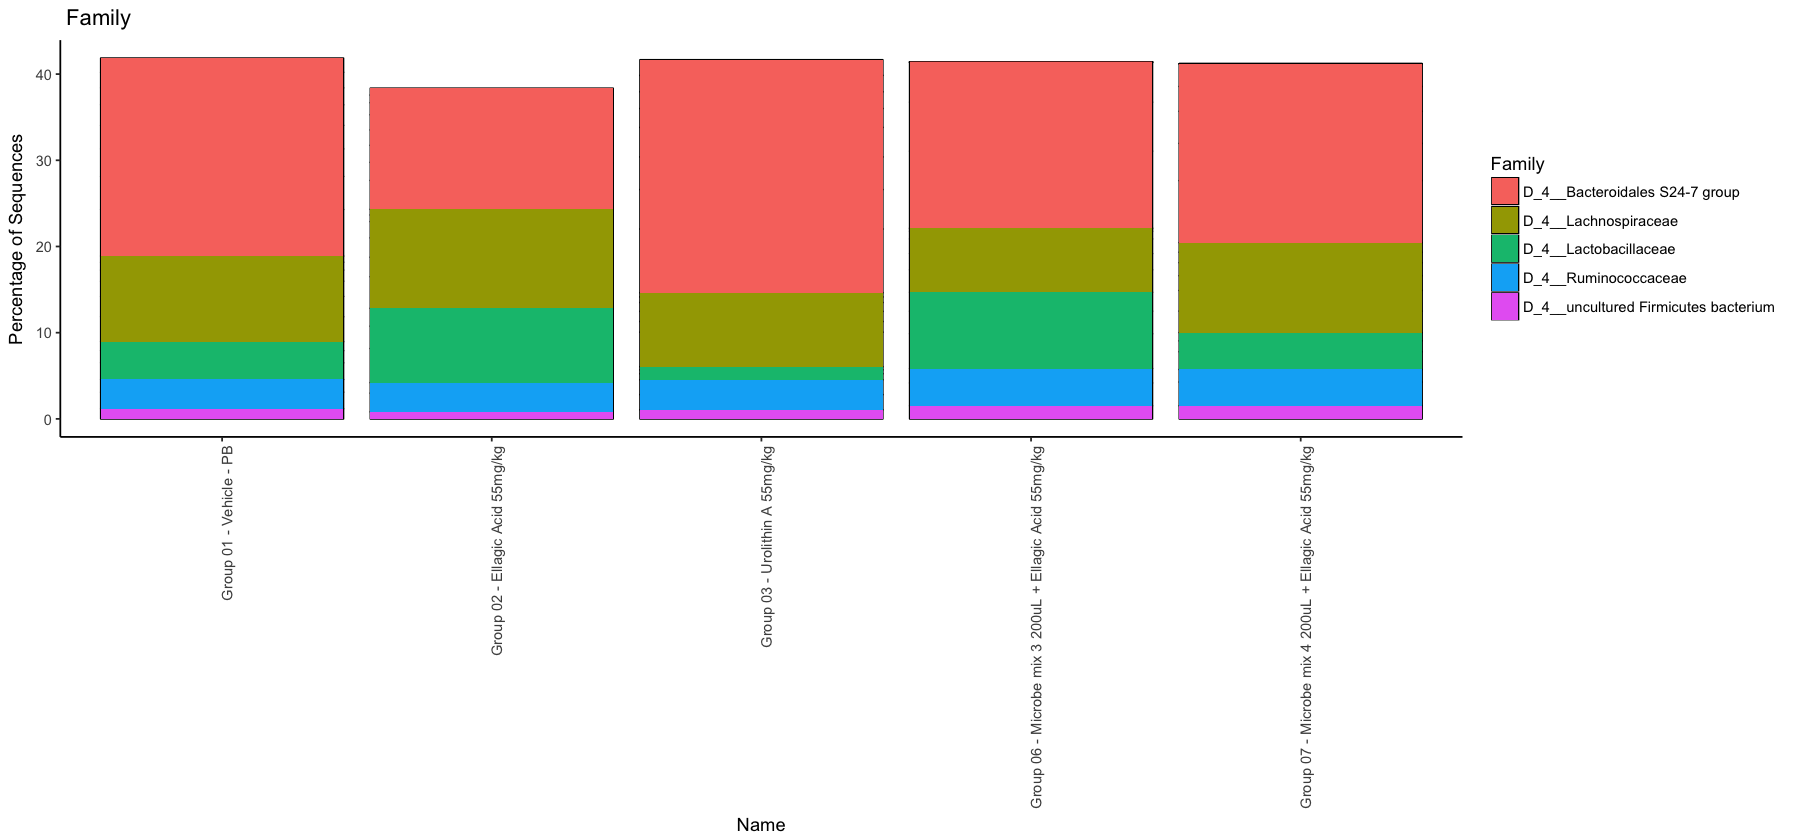

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

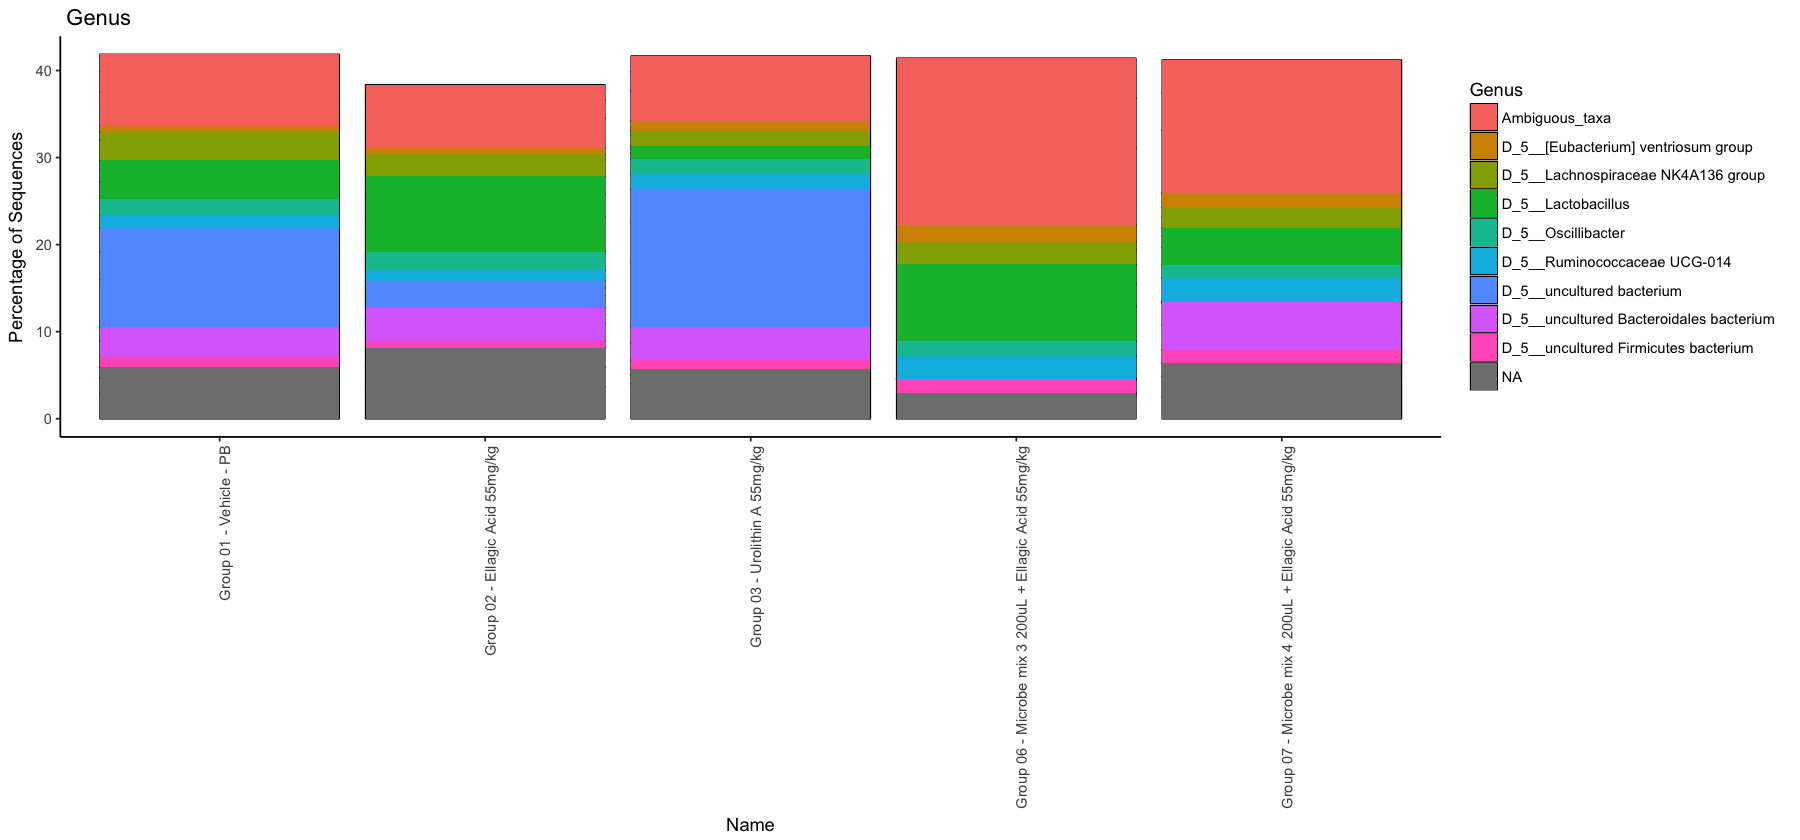

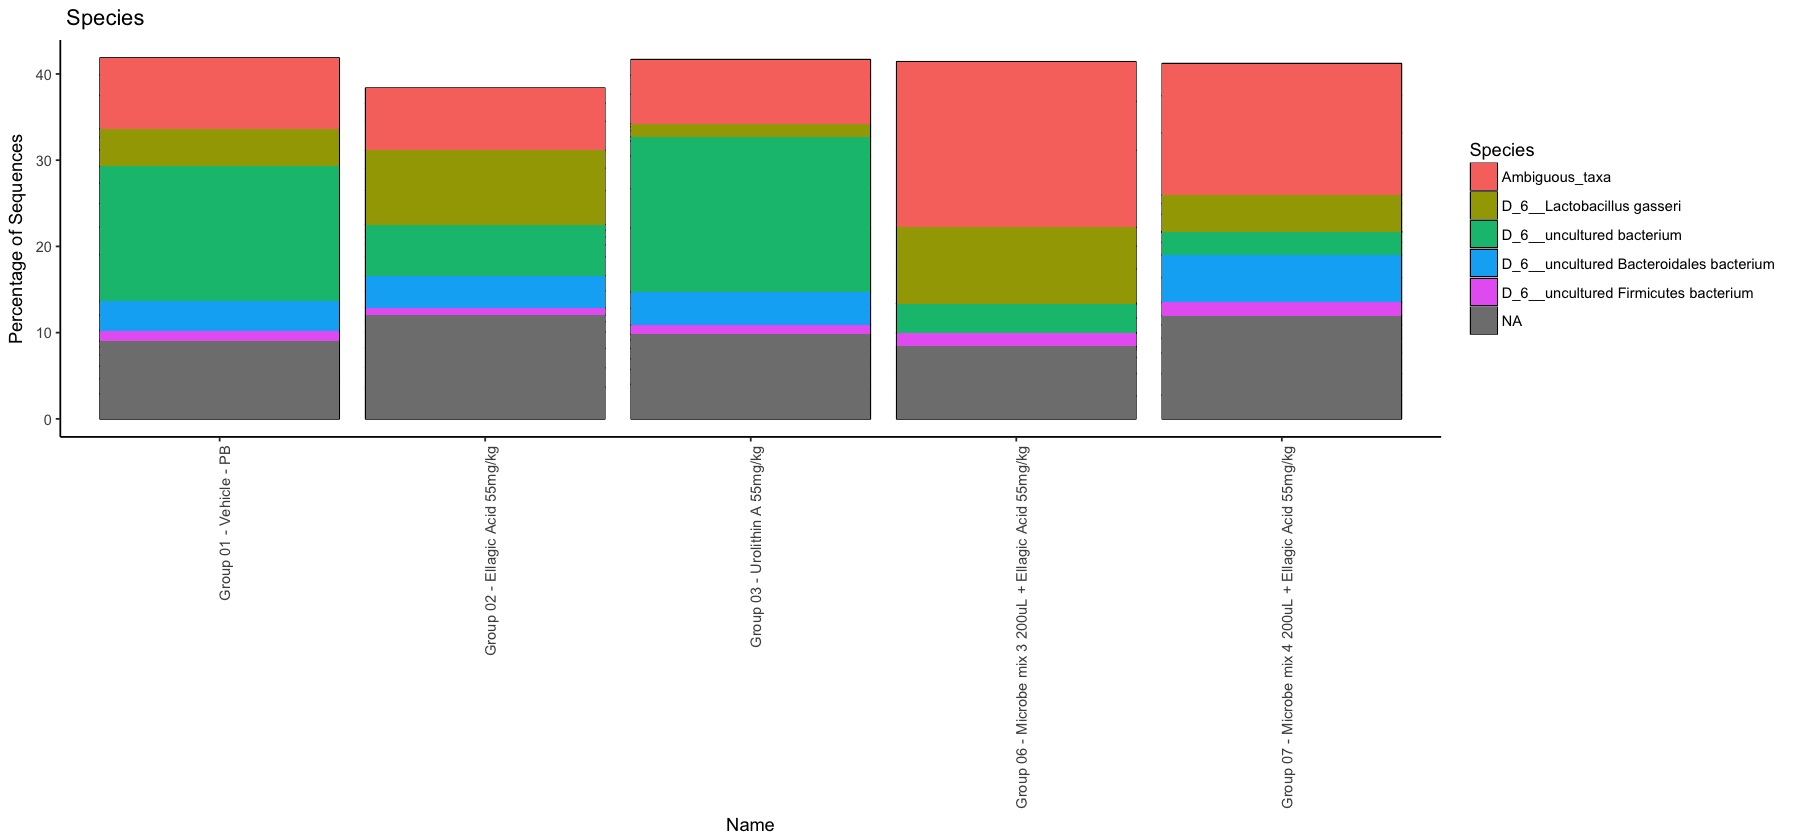

In [114]:
##########################################
#---Merge samples based on Name of treatment
#########################################

#DNA---------
#If you dont merge your percent abundace will accumulate in a per sample basis
physeq.noNA.rm = merge_samples(group12367rarefyna1, "Name")

#Repair the merged values associated with each surface after merge. 
sample_data(physeq.noNA.rm)$Name <- levels(sample_data(group12367)$Name)

#transform to percent total abudnance
physeq.noNA.rm = transform_sample_counts(physeq.noNA.rm, function(x) 100 * x/sum(x))
    
#first we sort the data
TopNOTUsdna = names(sort(taxa_sums(physeq.noNA.rm), TRUE)[1:20])
#prune those OTUs
top15dna = prune_taxa(TopNOTUsdna, physeq.noNA.rm)

    
    #percent abundance plot
#pdf('Final.PDF/DNA/top20_closed_barplot_p_c_o_f_g_s.pdf')


p<-plot_bar(top15dna, x="Name", fill="Phylum",title = " Phylum")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))

p<-plot_bar(top15dna, x="Name", fill="Class",title = " Class")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))
# environemtnal sample s 
p<-plot_bar(top15dna, x="Name", fill="Order",title = " Order")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))

# environemtnal sample s 
p<-plot_bar(top15dna, x="Name", fill="Family",title = " Family")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))


# environemtnal sample s 
p<-plot_bar(top15dna, x="Name", fill="Genus",title = " Genus")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))

# environemtnal sample s 
p<-plot_bar(top15dna, x="Name", fill="Species",title = " Species")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))
#dev.off()

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

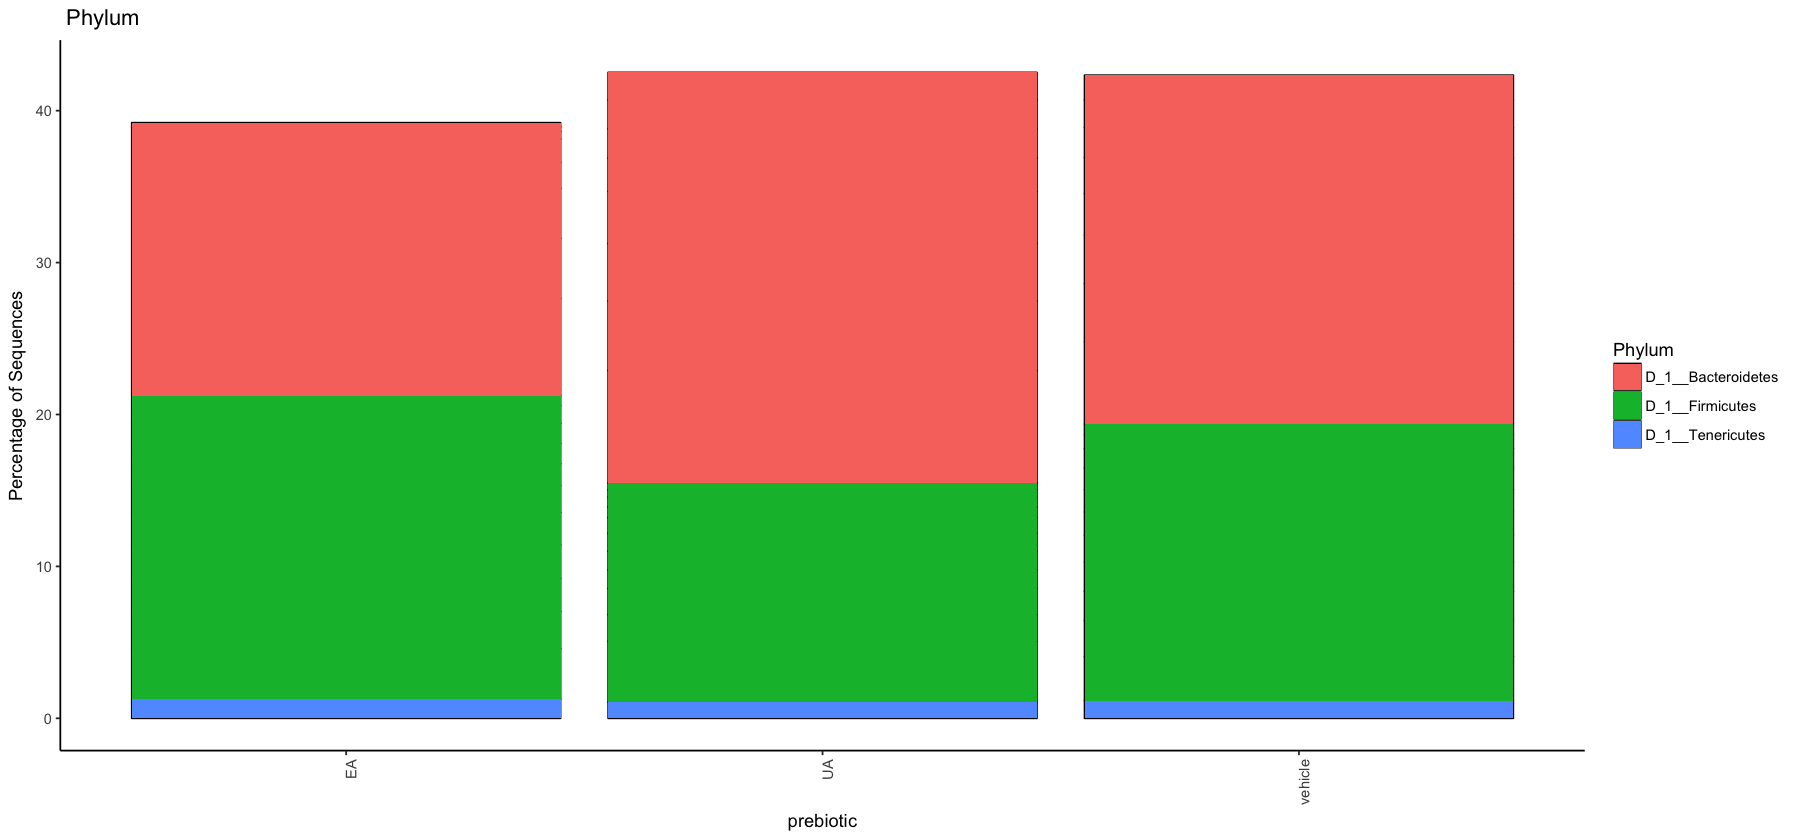

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

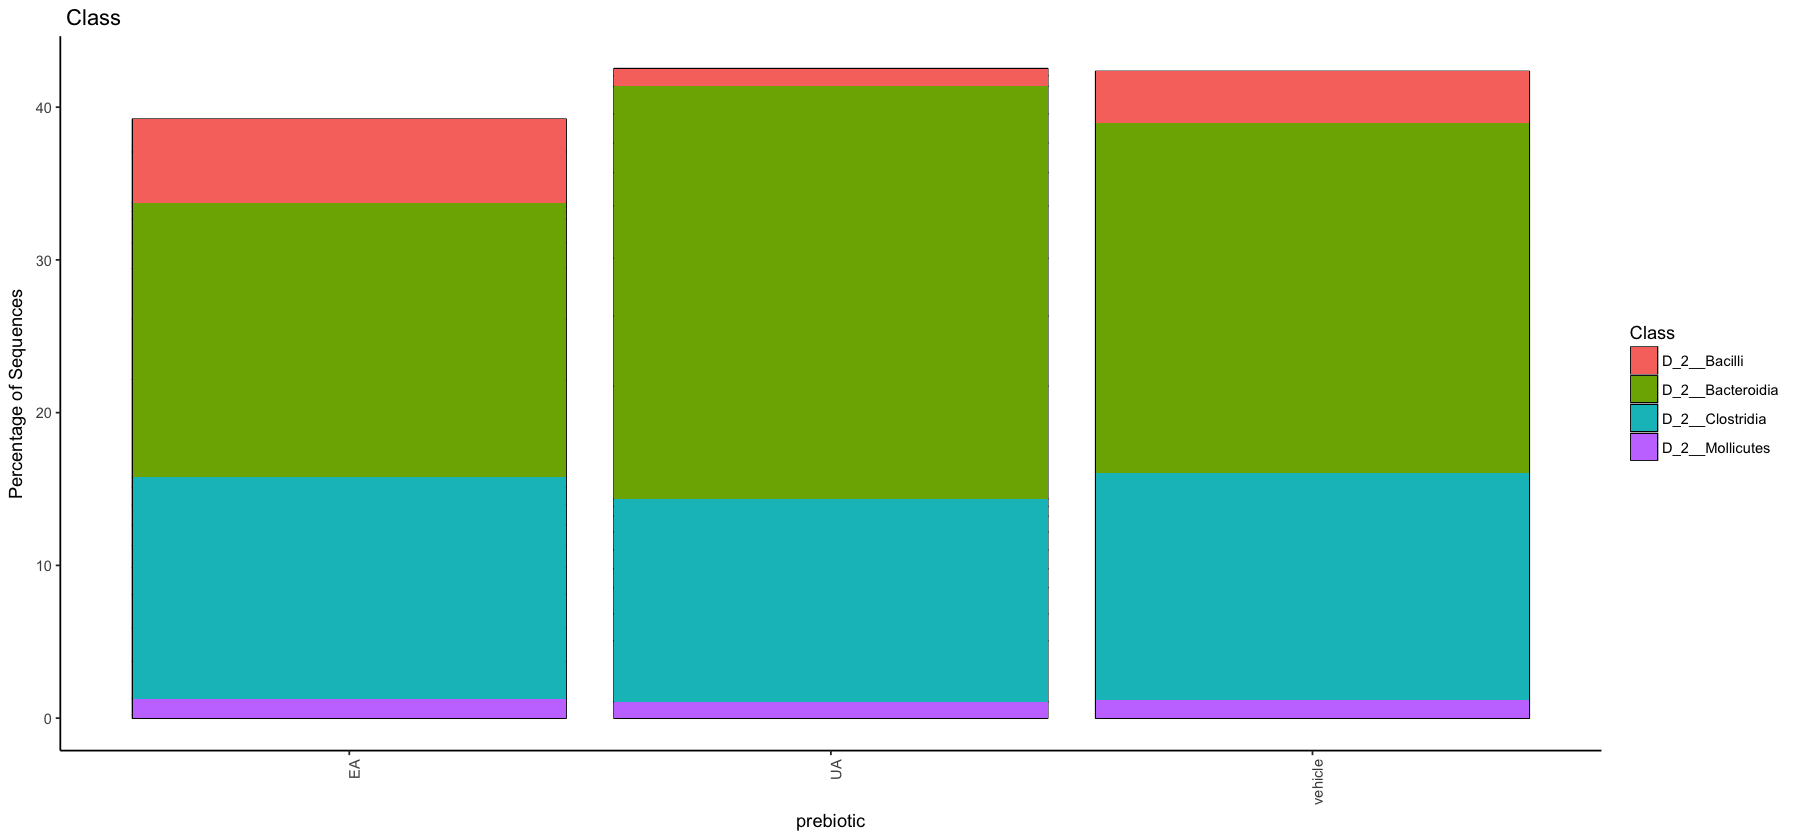

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

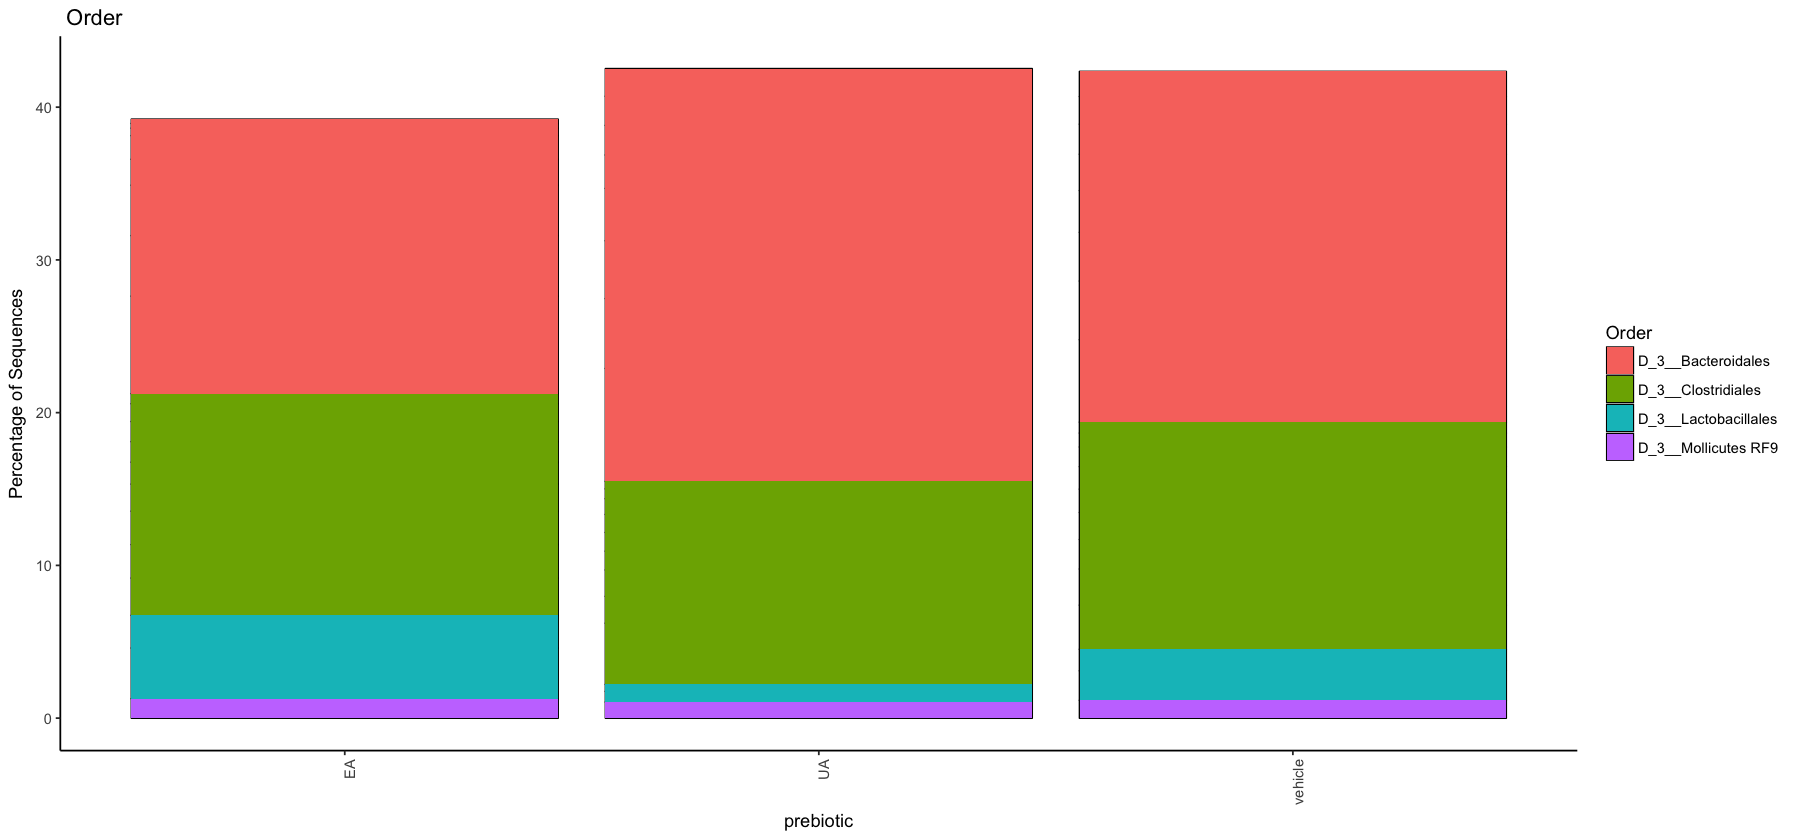

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

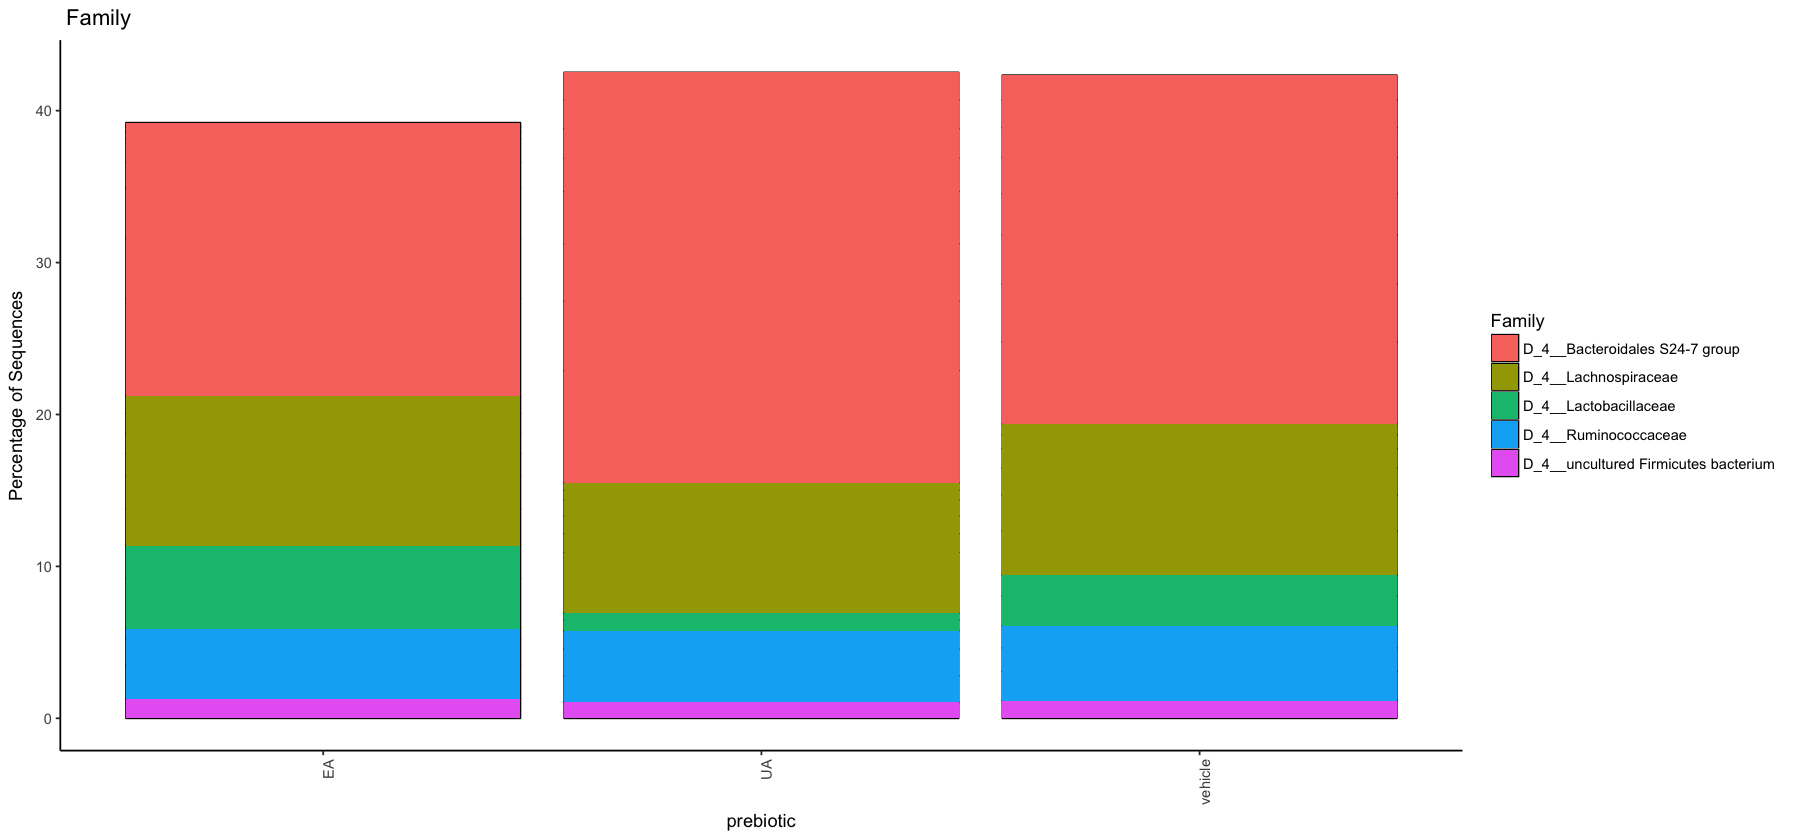

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

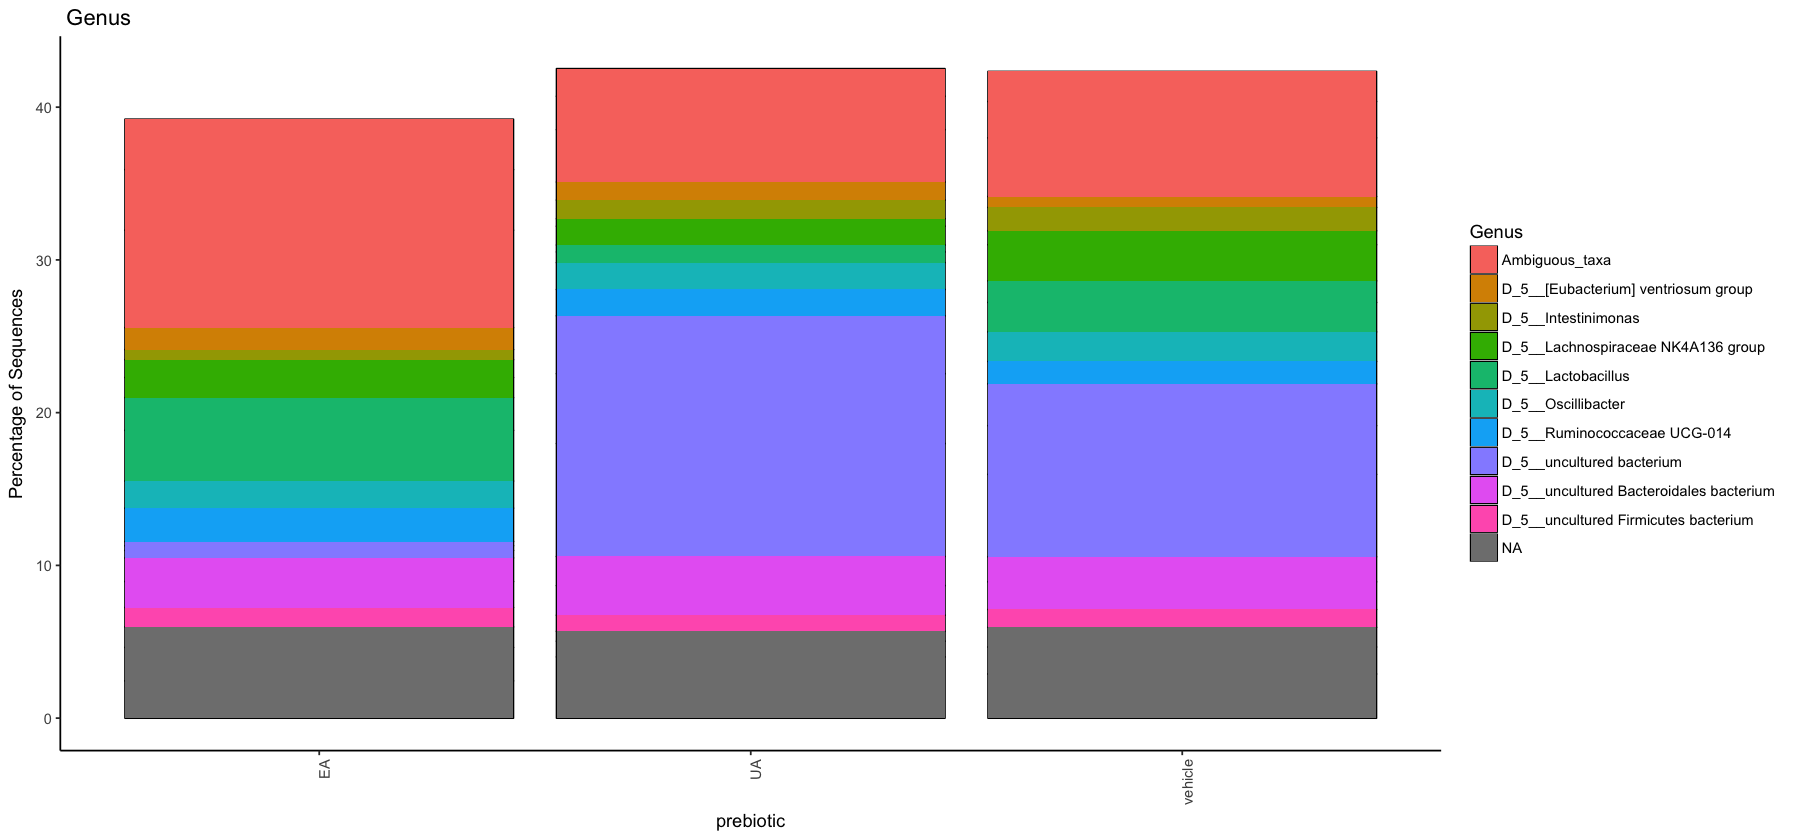

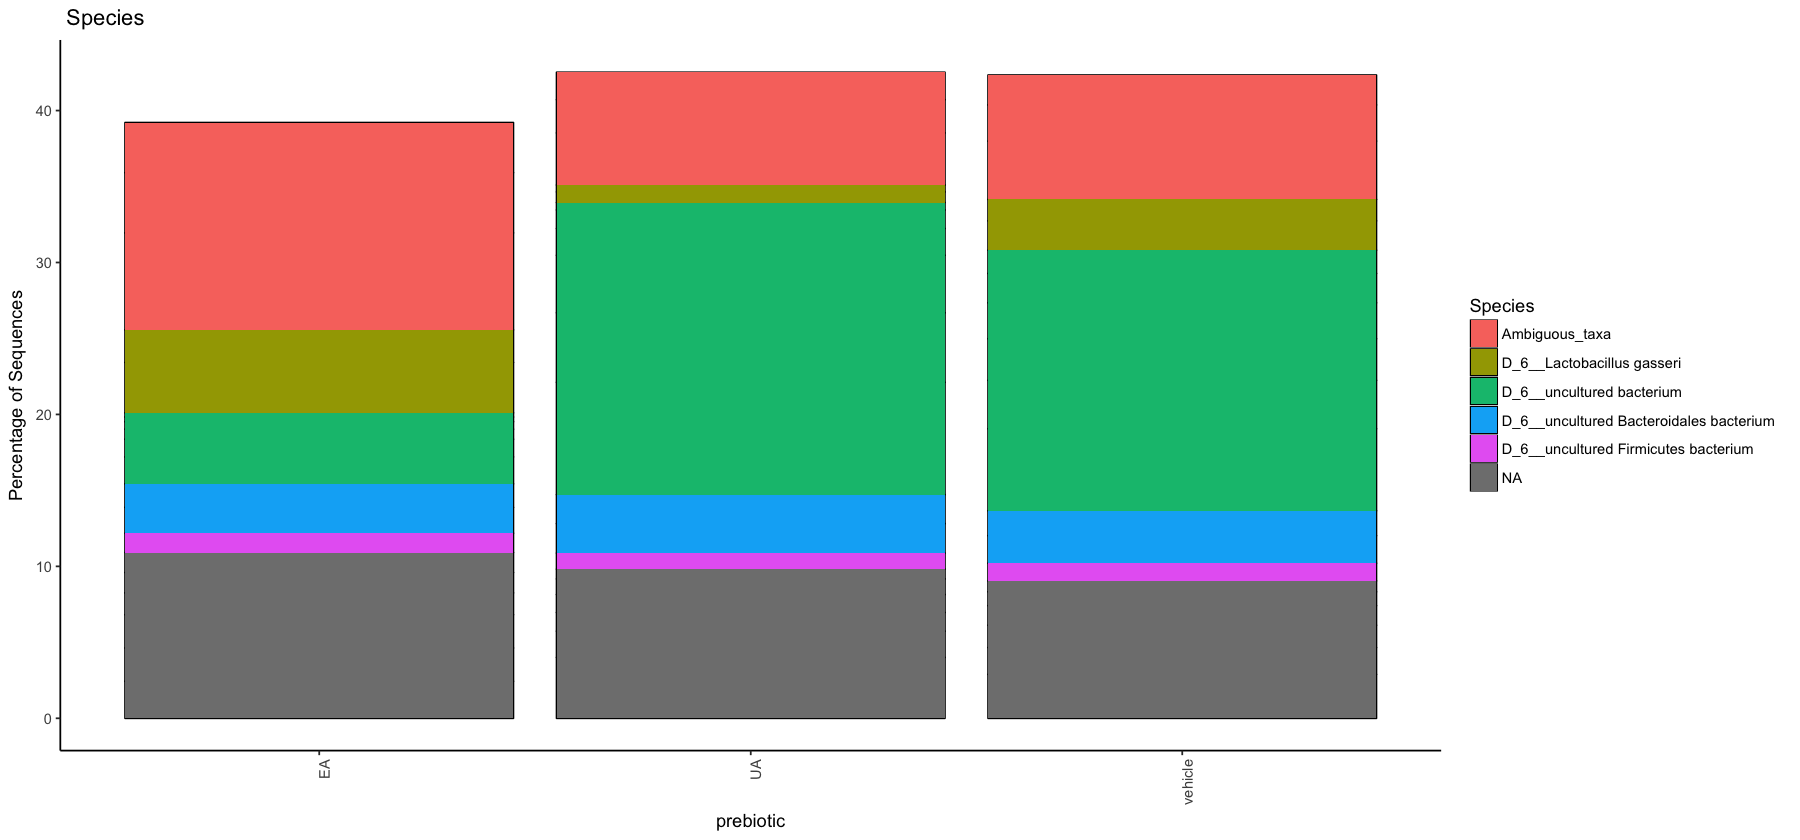

In [115]:
##########################################
#---Merge samples based on Name of treatment
#########################################

#DNA---------
#If you dont merge your percent abundace will accumulate in a per sample basis
physeq.noNA.rm = merge_samples(group12367rarefyna1, "prebiotic")

#Repair the merged values associated with each surface after merge. 
sample_data(physeq.noNA.rm)$prebiotic <- levels(sample_data(group12367)$prebiotic)

#transform to percent total abudnance
physeq.noNA.rm = transform_sample_counts(physeq.noNA.rm, function(x) 100 * x/sum(x))
    
#first we sort the data
TopNOTUsdna = names(sort(taxa_sums(physeq.noNA.rm), TRUE)[1:20])
#prune those OTUs
top15dna = prune_taxa(TopNOTUsdna, physeq.noNA.rm)

    
    #percent abundance plot
#pdf('Final.PDF/DNA/top20_closed_barplot_p_c_o_f_g_s.pdf')


p<-plot_bar(top15dna, x="prebiotic", fill="Phylum",title = " Phylum")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))

p<-plot_bar(top15dna, x="prebiotic", fill="Class",title = " Class")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))
# environemtnal sample s 
p<-plot_bar(top15dna, x="prebiotic", fill="Order",title = " Order")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))

# environemtnal sample s 
p<-plot_bar(top15dna, x="prebiotic", fill="Family",title = " Family")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))


# environemtnal sample s 
p<-plot_bar(top15dna, x="prebiotic", fill="Genus",title = " Genus")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))

# environemtnal sample s 
p<-plot_bar(top15dna, x="prebiotic", fill="Species",title = " Species")
p + geom_bar(stat = "identity", position = "stack")+ylab("Percentage of Sequences")+theme_bw()+ theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"))+theme(axis.text.x = element_text(angle = 90, hjust = 1))
#dev.off()

# Significant differences between groups

In [456]:

#'Kruskal-Wallis differential abundance  analysis
#'
#'This function finds the features that are significantly
#'differentially abundant  in the provided taxa abundance data under different conditions
#'using Kruskal-Wallis test. The p-values values generated are corrected for multiple testing
#'using  family wise error rate. Significance is based on the corrected pvalue threshold. Significant features
#'then plotted on a boxplot
#'
#' @param physeq (Required). A \code{phyloseq} object containing merged information of abundance,
#'        taxonomic assignment, sample data including the measured variables and categorical information
#'        of the samples, and / or phylogenetic tree if available.
#' @param library(repr) - to allow you to get larger boxplots
#' @param grouping_column (Required). Character string specifying name of a categorical variable that is preffered for grouping the information.
#'        information, this should be one of the components of grouping vector.
#' @param  pvalue.threshold. Cut off p-value for significance of differentially abundant taxa, default is 0.05.
#' @param  Color. What variable in your mapping file should determine the color of your box plots (Phylum,class, order ect..)
#' @param  Facet How your box plots will be split up
#' @return Returns a list of three items: \itemize{
#'         \item  SignfeaturesTable: A \code{data.frame} of taxa with coresponding raw p-values, corrected p-values, family wise error rate and expected abundance
#'         computed by using raw p-values.
#'         \item  importance: A \code{data.frame} of taxa mean decrease in accuracy as obtained by random forest classifier.
#'         \item plotdata: A \code{data.frame} of taxa and corresponding corrected p-values, importance rank organised
#'         in form accepted by ggplot.
#'        }
#' @examples
#' #plot the significant features
#' kruskal_abundance_plot(group12367rarefyna1,'prebiotic',pvalue.threshold=0.1,Color='Genus', Facet='Genus')
#'
#' This code was modified by Pedro J. Torres \email{pjtorres88@gmail.com} from the original code from the authors below to only have the 
#' signigficant kw and a list of the significant taxa and follw it up with normalization and boxplots.
#' @references \url{http://userweb.eng.gla.ac.uk/umer.ijaz/}, Umer Ijaz, 2015
#' @references \url{http://www.bigre.ulb.ac.be/courses/statistics_bioinformatics/practicals/microarrays_berry_2010/berry_feature_selection.html}
#'
#' @author Pedro J. Torres \email{pjtorres88@gmail.com}, Alfred Ssekagiri \email{assekagiri@gmail.com}, Umer Zeeshan Ijaz \email{Umer.Ijaz@glasgow.ac.uk}
#'
#' @export kruskal_abundance
#'
kruskal_abundance_plot <- function(physeq, grouping_column,pvalue.threshold=0.05,Color,Facet)
{
  #get relative abudnace 
  physeq = transform_sample_counts(physeq, function(x) x/sum(x))
  abund_table <- otu_table(physeq)
  tax=data.frame(tax_table(physeq))
  tax$taxonomy=with(tax,paste0(Phylum,Class,Order,Family,Genus,Species))
  rownames(abund_table)=tax$taxonomy
  abund_table <- t(otu_table(physeq))#needed to transform it for this specific data need samples as rows and features as columns
  
  meta_table <-data.frame(sample_data(physeq))
  meta_table$Groups <- meta_table[,grouping_column]

  kruskal.wallis.table <- data.frame()
  data <- as.data.frame(abund_table)
  for (i in 1:dim(data)[2]){
    ks.test <- kruskal.test(data[,i], g=meta_table$Groups)
    # Store the result in the data frame
    kruskal.wallis.table <- rbind(kruskal.wallis.table,data.frame(id=names(data)[i],p.value=ks.test$p.value))
  }
  kruskal.wallis.table$E.value <- kruskal.wallis.table$p.value * dim(kruskal.wallis.table)[1]
  kruskal.wallis.table$FWER <- pbinom(q=0, p=kruskal.wallis.table$p.value, size=dim(kruskal.wallis.table)[1], lower.tail=FALSE)
  kruskal.wallis.table <- kruskal.wallis.table[order(kruskal.wallis.table$p.value, decreasing=FALSE), ]
  kruskal.wallis.table$q.value.factor <- dim(kruskal.wallis.table)[1] / 1:dim(kruskal.wallis.table)[1]
  kruskal.wallis.table$q.value <- kruskal.wallis.table$p.value * kruskal.wallis.table$q.value.factor#gives qvalue
  rownames(kruskal.wallis.table) <- kruskal.wallis.table$id

  #==================significant feature selection =================================#
  last.significant.element <- max(which(kruskal.wallis.table$q.value <= pvalue.threshold))
  selected <- 1:last.significant.element
  sig_res <-kruskal.wallis.table$id[selected]# gives you the actual variables
  subset.data<-data.frame(data[,as.character(kruskal.wallis.table[rownames(kruskal.wallis.table),"id"])])
  kruskal.wallis.table$id <- colnames(subset.data) #enforce that ids and colnames of subset data remain the same for easy indexing later on
  subset.data <- subset.data[,sig_res]


out <- list("SignfeaturesTable"=kruskal.wallis.table)
#return(out)
out=data.frame(out)
#print(colnames(out))
sig=subset(out, SignfeaturesTable.q.value < pvalue.threshold)
    
sig2=data.frame(sig)
svs=sig2$SignfeaturesTable.id
svs=gsub('X', '', svs)
lsvs=c(svs)
sig = list("SignificantTable"=sig)
    
    
#generate boxplot===========================================
      
#convert physeq to dataframe
mphyseq = psmelt(physeq)
#subset variables that passed p values
mphyseq<- mphyseq[mphyseq$OTU %in% lsvs,]
mphyseq$tax <- paste(mphyseq$OTU,mphyseq$Phylum,mphyseq$Class,mphyseq$Order,mphyseq$Family,mphyseq$Genus,mphyseq$Species)

options(repr.plot.width=20, repr.plot.height=15)
p = ggplot(data = mphyseq,  mapping = aes_string(x = grouping_column, y = "Abundance",
                                 color = Color, fill = Color)) +
    geom_boxplot(fill = NA) +
    geom_point(size = 1.5, alpha = 1,
                position = position_jitter(width = 0.3)) +
   facet_wrap(facets = Facet) + ylab('Relative Abundance') +
   scale_y_log10()+theme(axis.text.x = element_text(angle = 90, hjust = 1))
    
print (p)
print('Significant taxa')
print (unique(mphyseq$tax))    
return (sig)

}


In [479]:
pdf('pdf/kw-test_prebiotic.pdf',width=12, height=10)
kruskal_abundance_plot(group12367rarefyna1,'prebiotic',pvalue.threshold=0.1,Color='Family', Facet='Genus')
dev.off()

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 189 rows containing non-finite values (stat_boxplot).”

[1] "Significant taxa"
[1] "1520fca26a57f382b3560ff4ab032f89 D_1__Bacteroidetes D_2__Bacteroidia D_3__Bacteroidales D_4__Bacteroidales S24-7 group D_5__uncultured bacterium D_6__uncultured bacterium"
[2] "1c7c5f31d8ae8440f2f7282a6102ef6f D_1__Bacteroidetes D_2__Bacteroidia D_3__Bacteroidales D_4__Bacteroidales S24-7 group D_5__uncultured bacterium D_6__uncultured bacterium"
[3] "9ad9714720a806de1ffddde866e3a9af D_1__Bacteroidetes D_2__Bacteroidia D_3__Bacteroidales D_4__Bacteroidales S24-7 group D_5__uncultured bacterium D_6__uncultured bacterium"
[4] "069d01b511be93554eb914ab79cd9b0c D_1__Firmicutes D_2__Clostridia D_3__Clostridiales D_4__Lachnospiraceae NA NA"                                                            
[5] "e53263d07c20ef536d6a9f5d3221f112 D_1__Firmicutes D_2__Clostridia D_3__Clostridiales D_4__Ruminococcaceae D_5__Ruminiclostridium 5 NA"                                      
[6] "3f49feab9dbde9a199609efa8f40a27c D_1__Firmicutes D_2__Clostridia D_3__Clostridiales D_4

$SignificantTable
                                              SignfeaturesTable.id
1520fca26a57f382b3560ff4ab032f89 X1520fca26a57f382b3560ff4ab032f89
069d01b511be93554eb914ab79cd9b0c X069d01b511be93554eb914ab79cd9b0c
a020c40a815b5575456395164b86bb34  a020c40a815b5575456395164b86bb34
e53263d07c20ef536d6a9f5d3221f112  e53263d07c20ef536d6a9f5d3221f112
3f49feab9dbde9a199609efa8f40a27c X3f49feab9dbde9a199609efa8f40a27c
9ad9714720a806de1ffddde866e3a9af X9ad9714720a806de1ffddde866e3a9af
1c7c5f31d8ae8440f2f7282a6102ef6f X1c7c5f31d8ae8440f2f7282a6102ef6f
                                 SignfeaturesTable.p.value
1520fca26a57f382b3560ff4ab032f89              8.887311e-06
069d01b511be93554eb914ab79cd9b0c              4.264502e-05
a020c40a815b5575456395164b86bb34              6.737741e-05
e53263d07c20ef536d6a9f5d3221f112              6.762736e-05
3f49feab9dbde9a199609efa8f40a27c              7.021079e-05
9ad9714720a806de1ffddde866e3a9af              1.297362e-04
1c7c5f31d8ae8440f2f7282a6102ef6f              2.100693e-04
                                 SignfeaturesTable.E.value
1520fca26a57f382b3560ff4ab032f89                0.01566833
069d01b511be93554eb914ab79cd9b0c                0.07518317
a020c40a815b5575456395164b86bb34                0.11878637
e53263d07c20ef536d6a9f5d3221f112                0.11922703
3f49feab9dbde9a199609efa8f40a27c                0.12378162
9ad9714720a806de1ffddde866e3a9af                0.22872499
1c7c5f31d8ae8440f2f7282a6102ef6f                0.37035210
                                 SignfeaturesTable.FWER
1520fca26a57f382b3560ff4ab032f89             0.01554629
069d01b511be93554eb914ab79cd9b0c             0.07242792
a020c40a815b5575456395164b86bb34             0.11200607
e53263d07c20ef536d6a9f5d3221f112             0.11239731
3f49feab9dbde9a199609efa8f40a27c             0.11643107
9ad9714720a806de1ffddde866e3a9af             0.20446452
1c7c5f31d8ae8440f2f7282a6102ef6f             0.30953569
                                 SignfeaturesTable.q.value.factor
1520fca26a57f382b3560ff4ab032f89                        1763.0000
069d01b511be93554eb914ab79cd9b0c                         881.5000
a020c40a815b5575456395164b86bb34                         587.6667
e53263d07c20ef536d6a9f5d3221f112                         440.7500
3f49feab9dbde9a199609efa8f40a27c                         352.6000
9ad9714720a806de1ffddde866e3a9af                         293.8333
1c7c5f31d8ae8440f2f7282a6102ef6f                         251.8571
                                 SignfeaturesTable.q.value
1520fca26a57f382b3560ff4ab032f89                0.01566833
069d01b511be93554eb914ab79cd9b0c                0.03759159
a020c40a815b5575456395164b86bb34                0.03959546
e53263d07c20ef536d6a9f5d3221f112                0.02980676
3f49feab9dbde9a199609efa8f40a27c                0.02475632
9ad9714720a806de1ffddde866e3a9af                0.03812083
1c7c5f31d8ae8440f2f7282a6102ef6f                0.05290744

pdf 
  2

In [346]:
library(randomForest)
library("scales")
#packageVersion("scales")
library("grid")
#packageVersion("grid")
library(knitr)
library('stringr')
library(repr)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin



In [462]:
#'Plot randomforest
#'
#' @author Pedro J. Torres \email{pjtorres88@gmail.com}
#'This function finds the top 10 features that have the greatest influence of classification accuracy using randomforest
#' and plots it in a boxplot

#'
#' @param physeq (Required). A \code{phyloseq} object containing merged information of abundance,
#'        taxonomic assignment, sample data including the measured variables and categorical information
#'        of the samples, and / or phylogenetic tree if available.
#' @param randomForest (Required)- do random forest
#' @param scales (Required)- will help with scaling of boxplot
#' @param grid (Required)- will help with scaling of boxplot
#' @param knitr (Required)- give a nice output of the important feature in a random foret model
#' @param stringr (Required)- allows modificaiton of important OTUS
#' @param repr (Required)- allows modificaiton of boxplot aka bigger plots!

#' @param grouping_column (Required). Character string specifying name of a categorical variable that is preffered for grouping the information.
#'        information, this should be one of the components of grouping vector.
#' @param  Color. What variable in your mapping file should determine the color of your box plots (Phylum,class, order ect..)
#' @param  Facet How your box plots will be split up

#' @examples
#' #plot the significant features
#' plot_randomforest(physeqobject,grouping_column='Treatment', Color='Family', Facet='Genus')
#'
#' This code was modified by Pedro J. Torres \email{pjtorres88@gmail.com} a number of phyloseq tutorials out there
#'
#'

plot_randomforest=function(physeq, grouping_column,Color,Facet){
    
    #filter out any taxa with a zero or in very low abudnace and prep for random forest, will not make training set here
    physeq_0_filtered <- prune_taxa(taxa_sums(physeq) > 0,physeq)
    physeq_10_filtered <- prune_taxa(taxa_sums(physeq_0_filtered)>5,physeq_0_filtered)
    predictors <- t(otu_table(physeq_10_filtered))
    physeq_10_filtered_sample_Data <- data.frame(sample_data(physeq_10_filtered))
    physeq_10_filtered_sample_Data$Groups <- physeq_10_filtered_sample_Data[,grouping_column]
    response <- as.factor(physeq_10_filtered_sample_Data$Groups)
    rf.data <- data.frame(response,predictors)
    
    # run random forest
    set.seed(123)
    physeq_10_filtered_Classify <- randomForest(response~., data = rf.data, ntree = 1000)
    print(physeq_10_filtered_Classify)
    
    imp <- importance(physeq_10_filtered_Classify)
    imp <- data.frame(predictors = rownames(imp), imp)
    attach(imp)

    # sort by mpg
    imp.sort <- imp[order(-MeanDecreaseGini),] 
    #imp.sort <- arrange(imp, desc(MeanDecreaseGini))
    imp.sort$predictors <- factor(imp.sort$predictors, levels = imp.sort$predictors)

    imp.20 <- imp.sort[1:10, ]
    
    p=ggplot(imp.20, aes(x = predictors, y = MeanDecreaseGini)) +
      geom_bar(stat = "identity", fill = "indianred") + 
      coord_flip() +
      ggtitle("Most important OTUs for classifying ")
    print (p)
    
    #-----What are those OTUs?
    otunames <- imp.20$predictors
    otunames=gsub('X', '', otunames)
    r <- rownames(tax_table(physeq_10_filtered)) %in% otunames
    table=kable(tax_table(physeq_10_filtered)[r, ])
    print(table)

    #subset 10 most important variables
    lsvs=c(otunames)

    #generate boxplot===========================================
      
    #convert physeq to dataframe
    physeq_10_filtered = transform_sample_counts(physeq_10_filtered, function(x) x/sum(x))
    mphyseq = psmelt(physeq_10_filtered)
    mphyseq<- mphyseq[mphyseq$OTU %in% lsvs,]

    #plot
    options(repr.plot.width=20, repr.plot.height=15)
    prf=ggplot(data = mphyseq,  mapping = aes_string(x = grouping_column, y = "Abundance",
                                 color = Color, fill = Color)) +
        geom_boxplot(fill = NA) +
        geom_point(size = 1.7, alpha = 1,
                    position = position_jitter(width = 0.3)) +
       facet_wrap(facets = Facet) + ylab('Relative Abundance') +
       scale_y_log10()+theme(axis.text.x = element_text(angle = 90, hjust = 1))
    
    print (prf)

}


Call:
 randomForest(formula = response ~ ., data = rf.data, ntree = 1000) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 30

        OOB estimate of  error rate: 34.21%
Confusion matrix:
        EA UA vehicle class.error
EA      23  0       0        0.00
UA       7  0       0        1.00
vehicle  6  0       2        0.75


The following object is masked _by_ .GlobalEnv:

    predictors

The following objects are masked from imp (pos = 3):

    MeanDecreaseGini, predictors

The following objects are masked from imp (pos = 4):

    MeanDecreaseGini, predictors

The following objects are masked from imp (pos = 5):

    MeanDecreaseGini, predictors

The following objects are masked from imp (pos = 6):

    MeanDecreaseGini, predictors

The following objects are masked from imp (pos = 7):

    MeanDecreaseGini, predictors

The following objects are masked from imp (pos = 8):

    MeanDecreaseGini, predictors

The following objects are masked from imp (pos = 9):

    MeanDecreaseGini, predictors

The following objects are masked from imp (pos = 10):

    MeanDecreaseGini, predictors

The following objects are masked from imp (pos = 11):

    MeanDecreaseGini, predictors

The following objects are masked from imp (pos = 12):

    MeanDecreaseGini, predictors

The following objects are masked from imp (pos = 13)



|                                 |Kingdom       |Phylum             |Class            |Order              |Family                         |Genus                              |Species                   |
|:--------------------------------|:-------------|:------------------|:----------------|:------------------|:------------------------------|:----------------------------------|:-------------------------|
|1ee9f5a729ecee45a73e9dad5c732b08 |D_0__Bacteria |D_1__Firmicutes    |D_2__Clostridia  |D_3__Clostridiales |D_4__Lachnospiraceae           |D_5__Lachnospiraceae NK4A136 group |D_6__uncultured bacterium |
|be7390ba7c1a22fc4144f97f5aa2c5bb |D_0__Bacteria |D_1__Firmicutes    |D_2__Clostridia  |D_3__Clostridiales |D_4__Ruminococcaceae           |D_5__Intestinimonas                |D_6__uncultured bacterium |
|1520fca26a57f382b3560ff4ab032f89 |D_0__Bacteria |D_1__Bacteroidetes |D_2__Bacteroidia |D_3__Bacteroidales |D_4__Bacteroidales S24-7 group |D_5__uncultured bacterium          |D_6__u

Warning message in psmelt(physeq_10_filtered):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 172 rows containing non-finite values (stat_boxplot).”

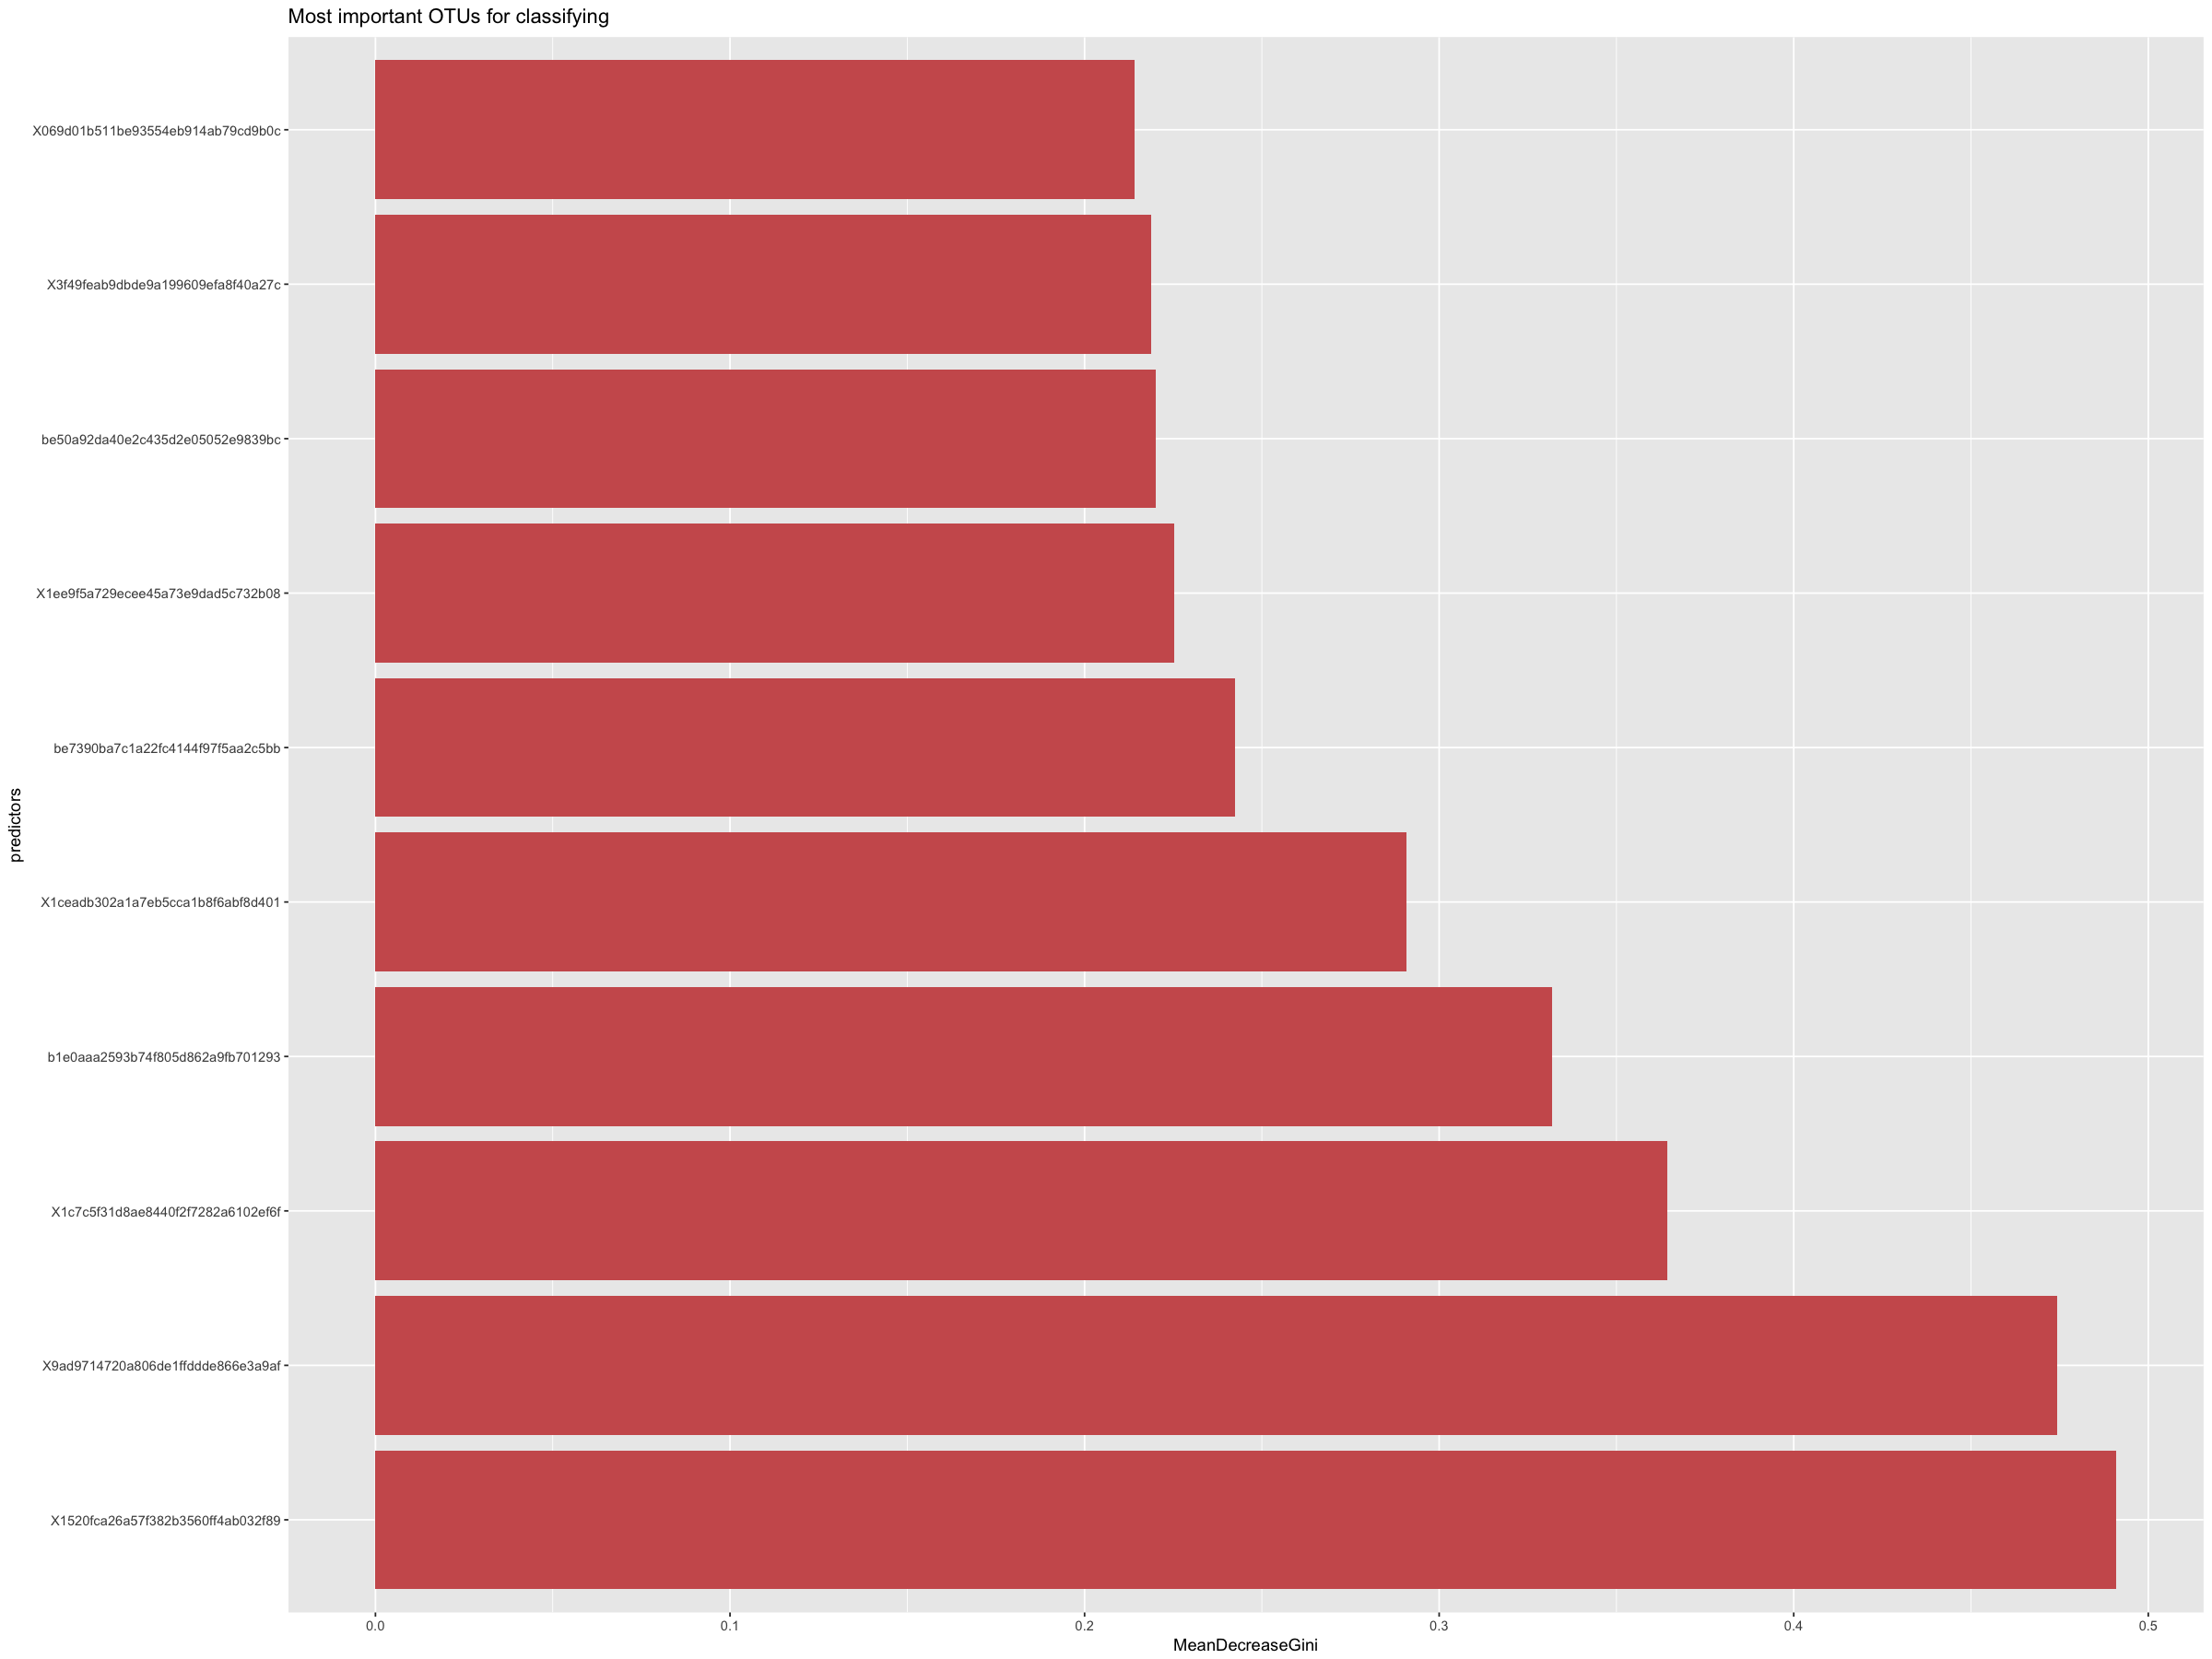

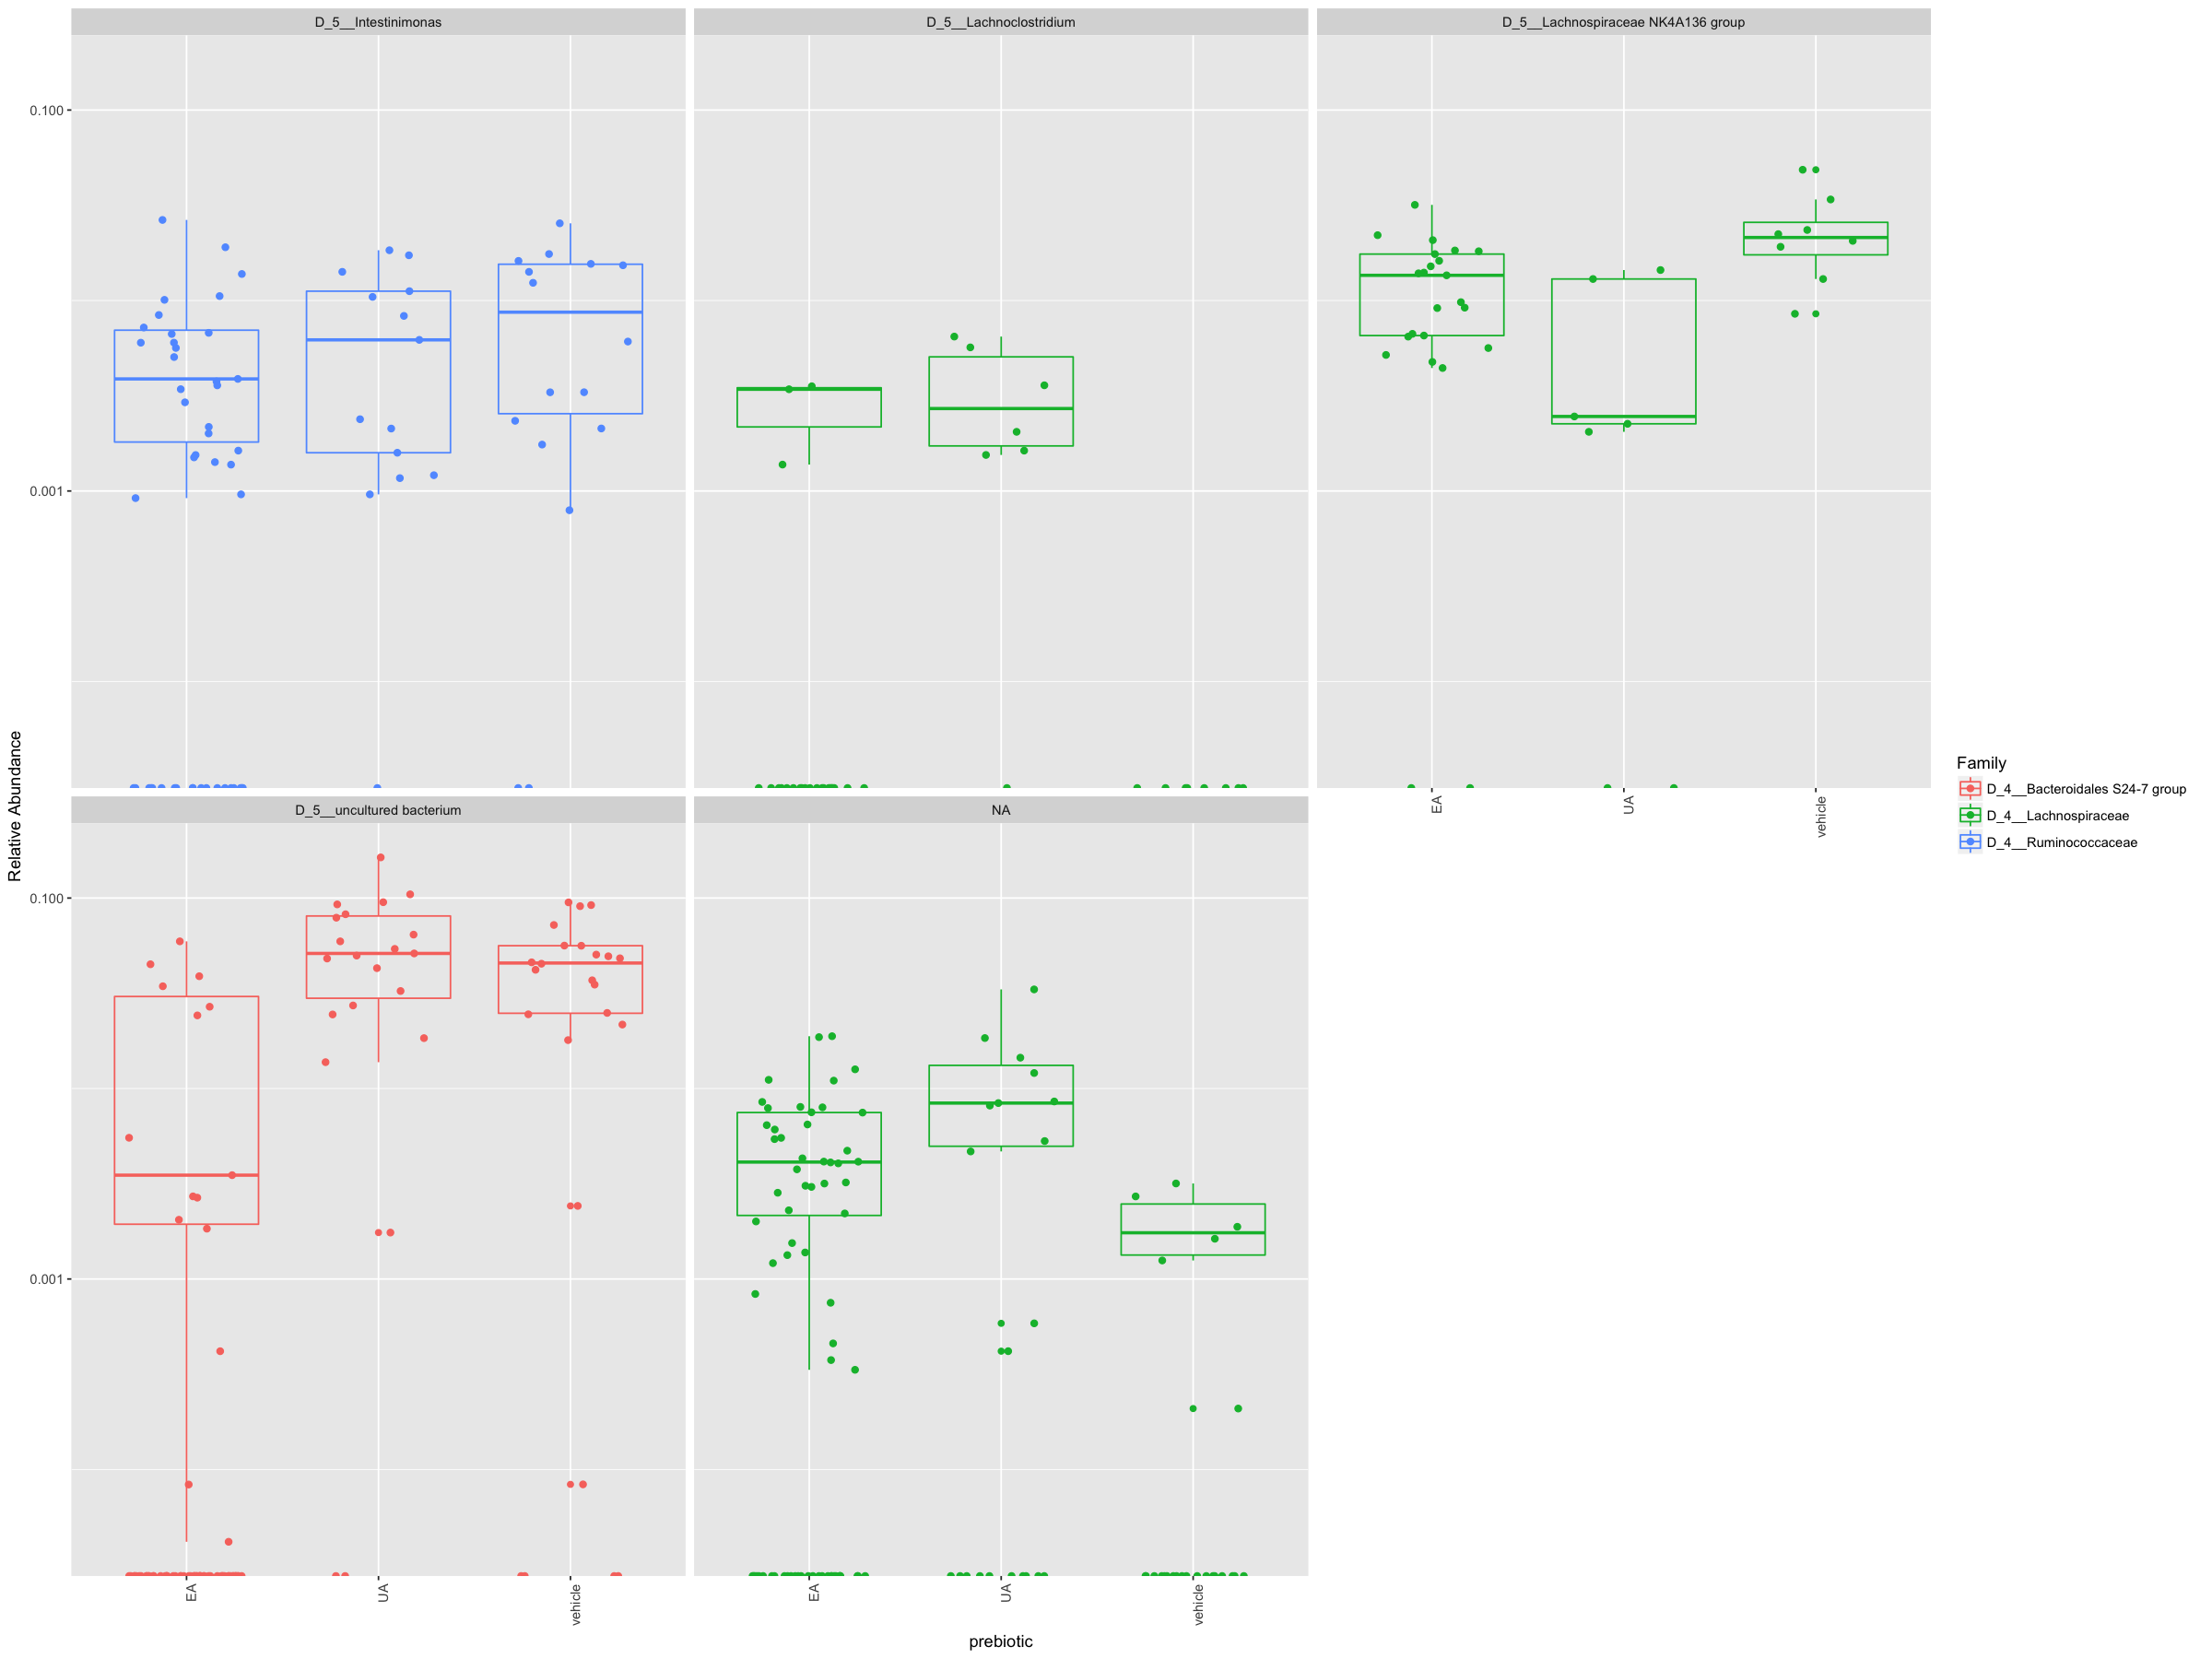

In [482]:
#pdf('pdf/randomForest_prebiotic.pdf',width=12, height=10)


plot_randomforest(group12367rarefyna1,grouping_column='prebiotic', Color='Family', Facet='Genus')
#dev.off()


Call:
 randomForest(formula = response ~ ., data = rf.data, ntree = 1000) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 2

        OOB estimate of  error rate: 78.95%
Confusion matrix:
                                                      Group 01 - Vehicle - PB
Group 01 - Vehicle - PB                                                     0
Group 02 - Ellagic Acid 55mg/kg                                             0
Group 03 - Urolithin A 55mg/kg                                              0
Group 06 - Microbe mix 3 200uL + Ellagic Acid 55mg/kg                       0
Group 07 - Microbe mix 4 200uL + Ellagic Acid 55mg/kg                       1
                                                      Group 02 - Ellagic Acid 55mg/kg
Group 01 - Vehicle - PB                                                             6
Group 02 - Ellagic Acid 55mg/kg                                                     5

The following object is masked _by_ .GlobalEnv:

    predictors

The following objects are masked from imp (pos = 3):

    MeanDecreaseGini, predictors

The following objects are masked from imp (pos = 4):

    MeanDecreaseGini, predictors

The following objects are masked from imp (pos = 5):

    MeanDecreaseGini, predictors

The following objects are masked from imp (pos = 6):

    MeanDecreaseGini, predictors

The following objects are masked from imp (pos = 7):

    MeanDecreaseGini, predictors

The following objects are masked from imp (pos = 8):

    MeanDecreaseGini, predictors

The following objects are masked from imp (pos = 9):

    MeanDecreaseGini, predictors

The following objects are masked from imp (pos = 10):

    MeanDecreaseGini, predictors

The following objects are masked from imp (pos = 11):

    MeanDecreaseGini, predictors

The following objects are masked from imp (pos = 12):

    MeanDecreaseGini, predictors

The following objects are masked from imp (pos = 13)



|                                 |Kingdom       |Phylum               |Class                 |Order                   |Family                   |Genus                 |Species                   |
|:--------------------------------|:-------------|:--------------------|:---------------------|:-----------------------|:------------------------|:---------------------|:-------------------------|
|ad6a9613e701eafe10fd322ff678cf1a |D_0__Bacteria |D_1__Firmicutes      |D_2__Clostridia       |D_3__Clostridiales      |D_4__Ruminococcaceae     |D_5__Faecalibacterium |NA                        |
|e1137804bd9704ab90683d807534d403 |D_0__Bacteria |D_1__Verrucomicrobia |D_2__Verrucomicrobiae |D_3__Verrucomicrobiales |D_4__Verrucomicrobiaceae |D_5__Akkermansia      |D_6__uncultured bacterium |
|1f16a4e74832ae14971a2525951c9169 |D_0__Bacteria |D_1__Verrucomicrobia |D_2__Verrucomicrobiae |D_3__Verrucomicrobiales |D_4__Verrucomicrobiaceae |D_5__Akkermansia      |D_6__uncultured bacterium |
|d1fce3b5e21f

Warning message in psmelt(physeq_10_filtered):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 131 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 104 rows containing missing values (geom_point).”

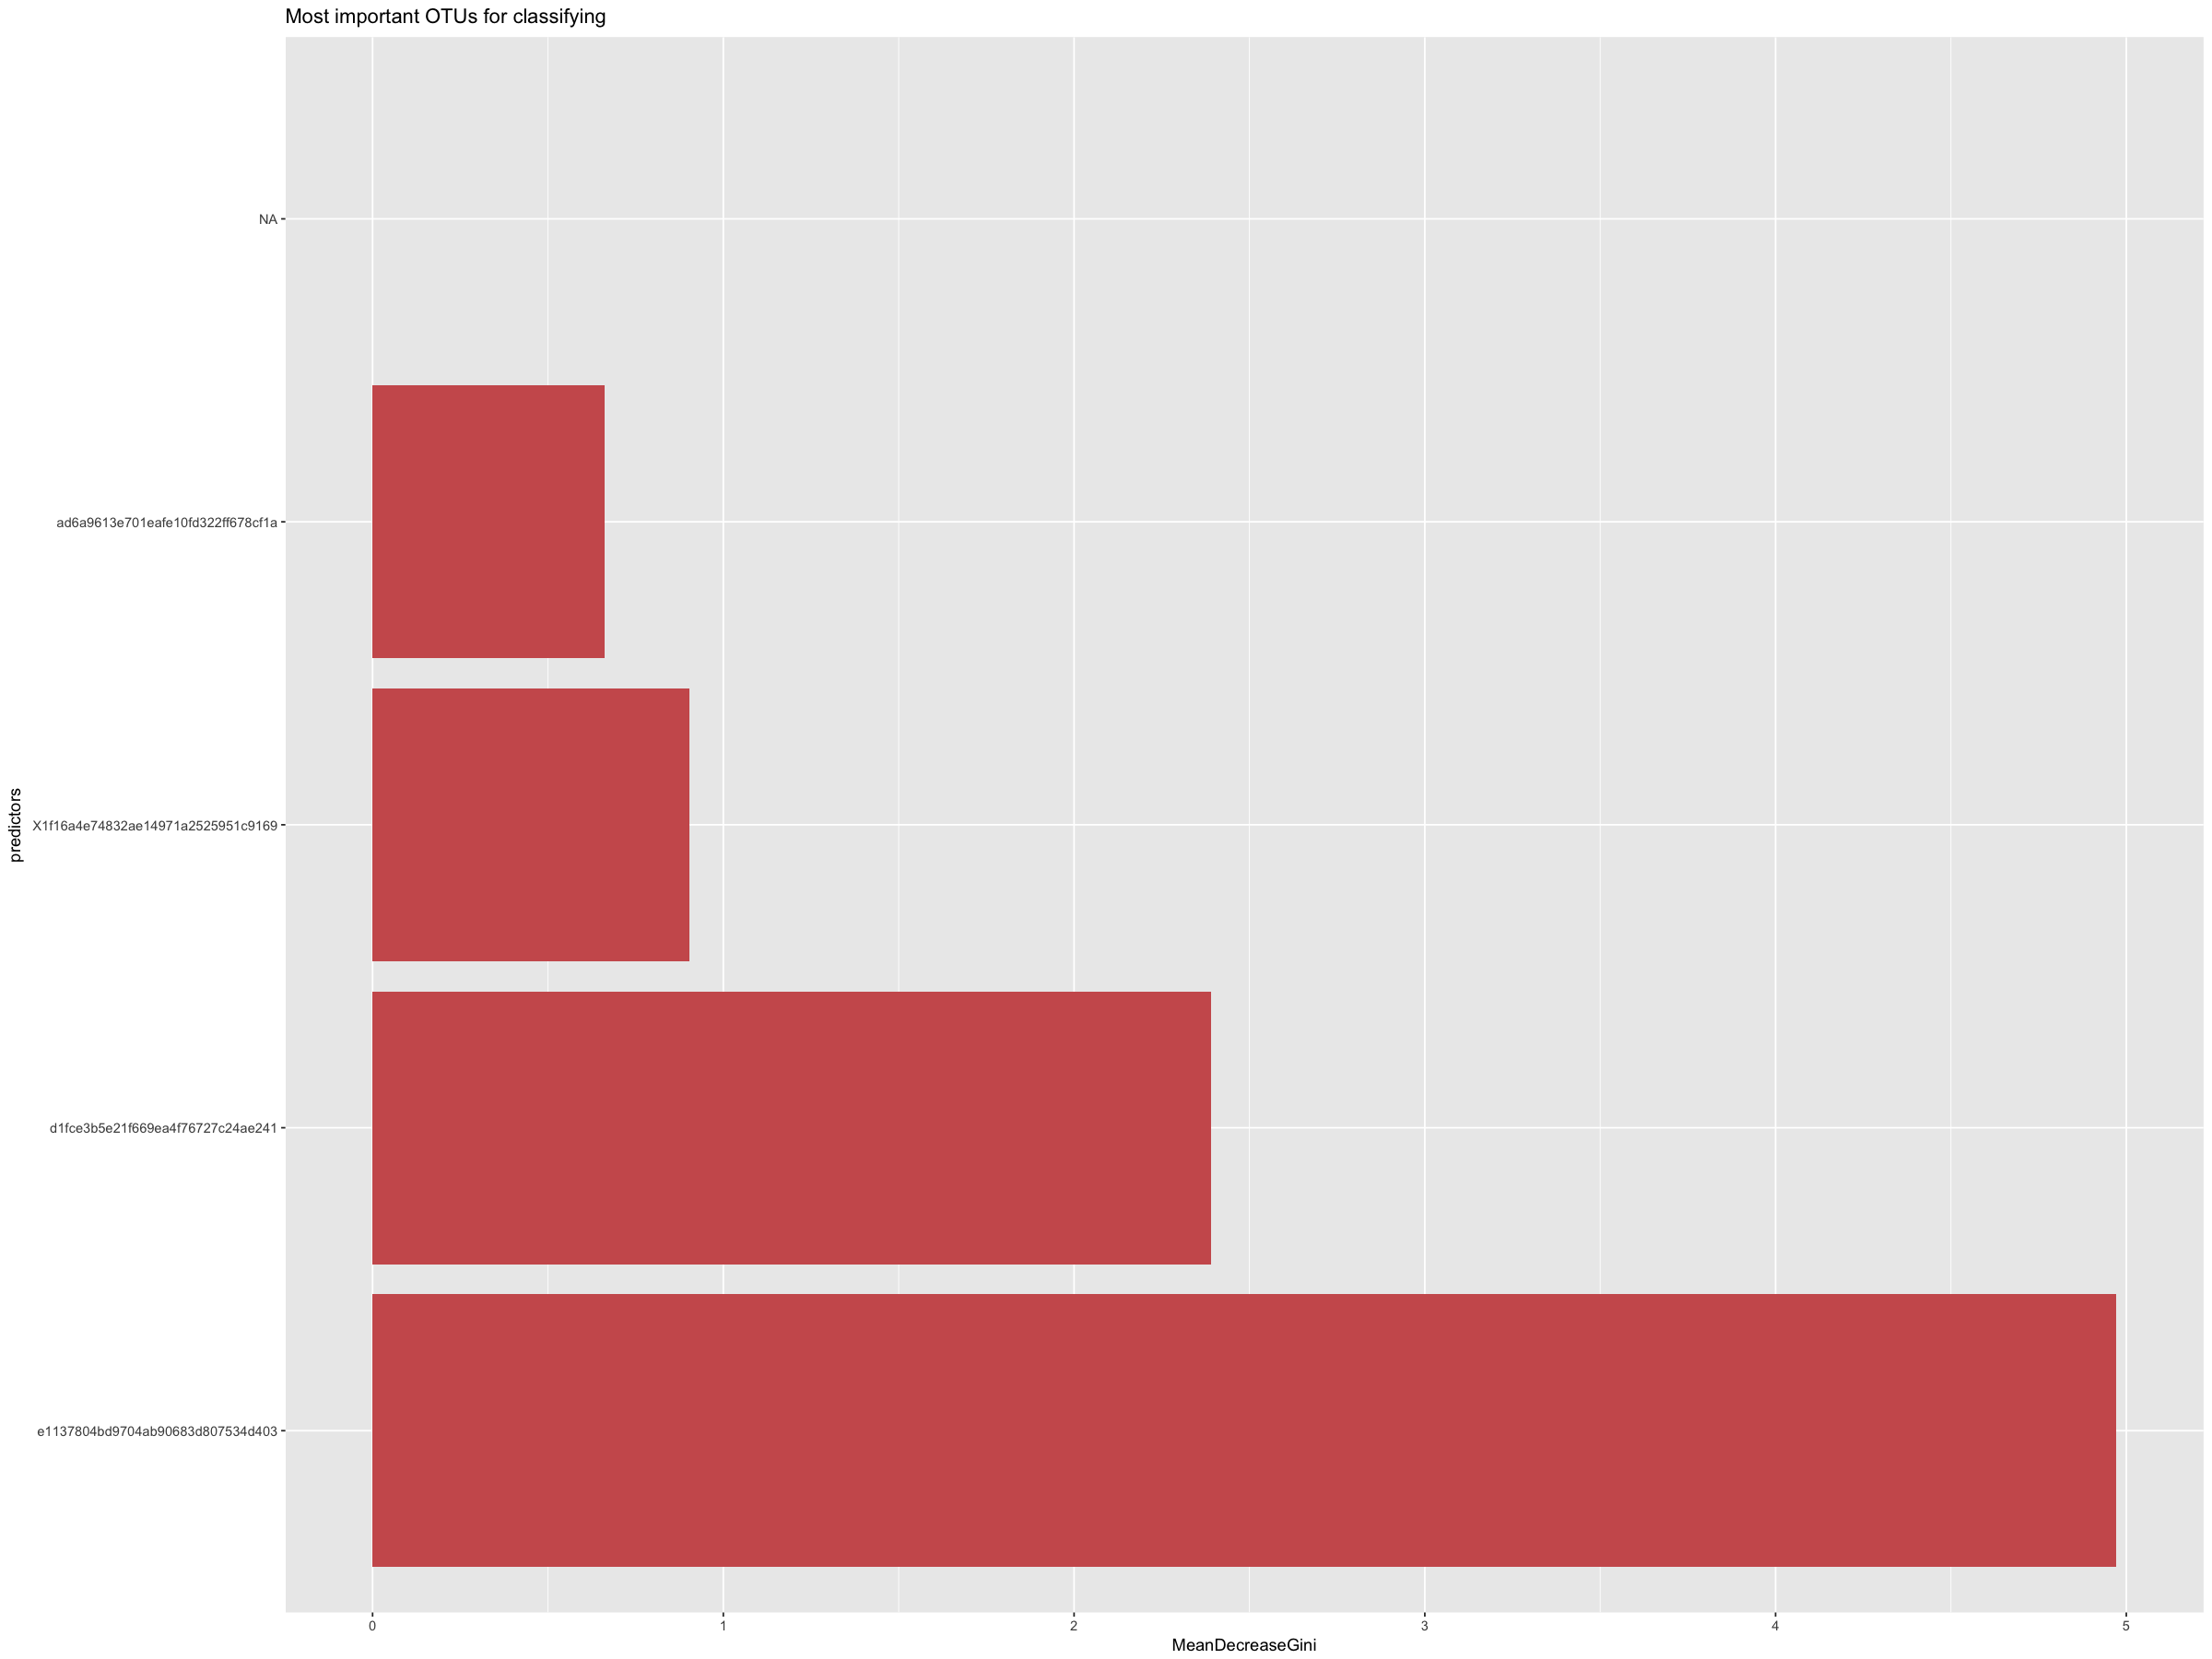

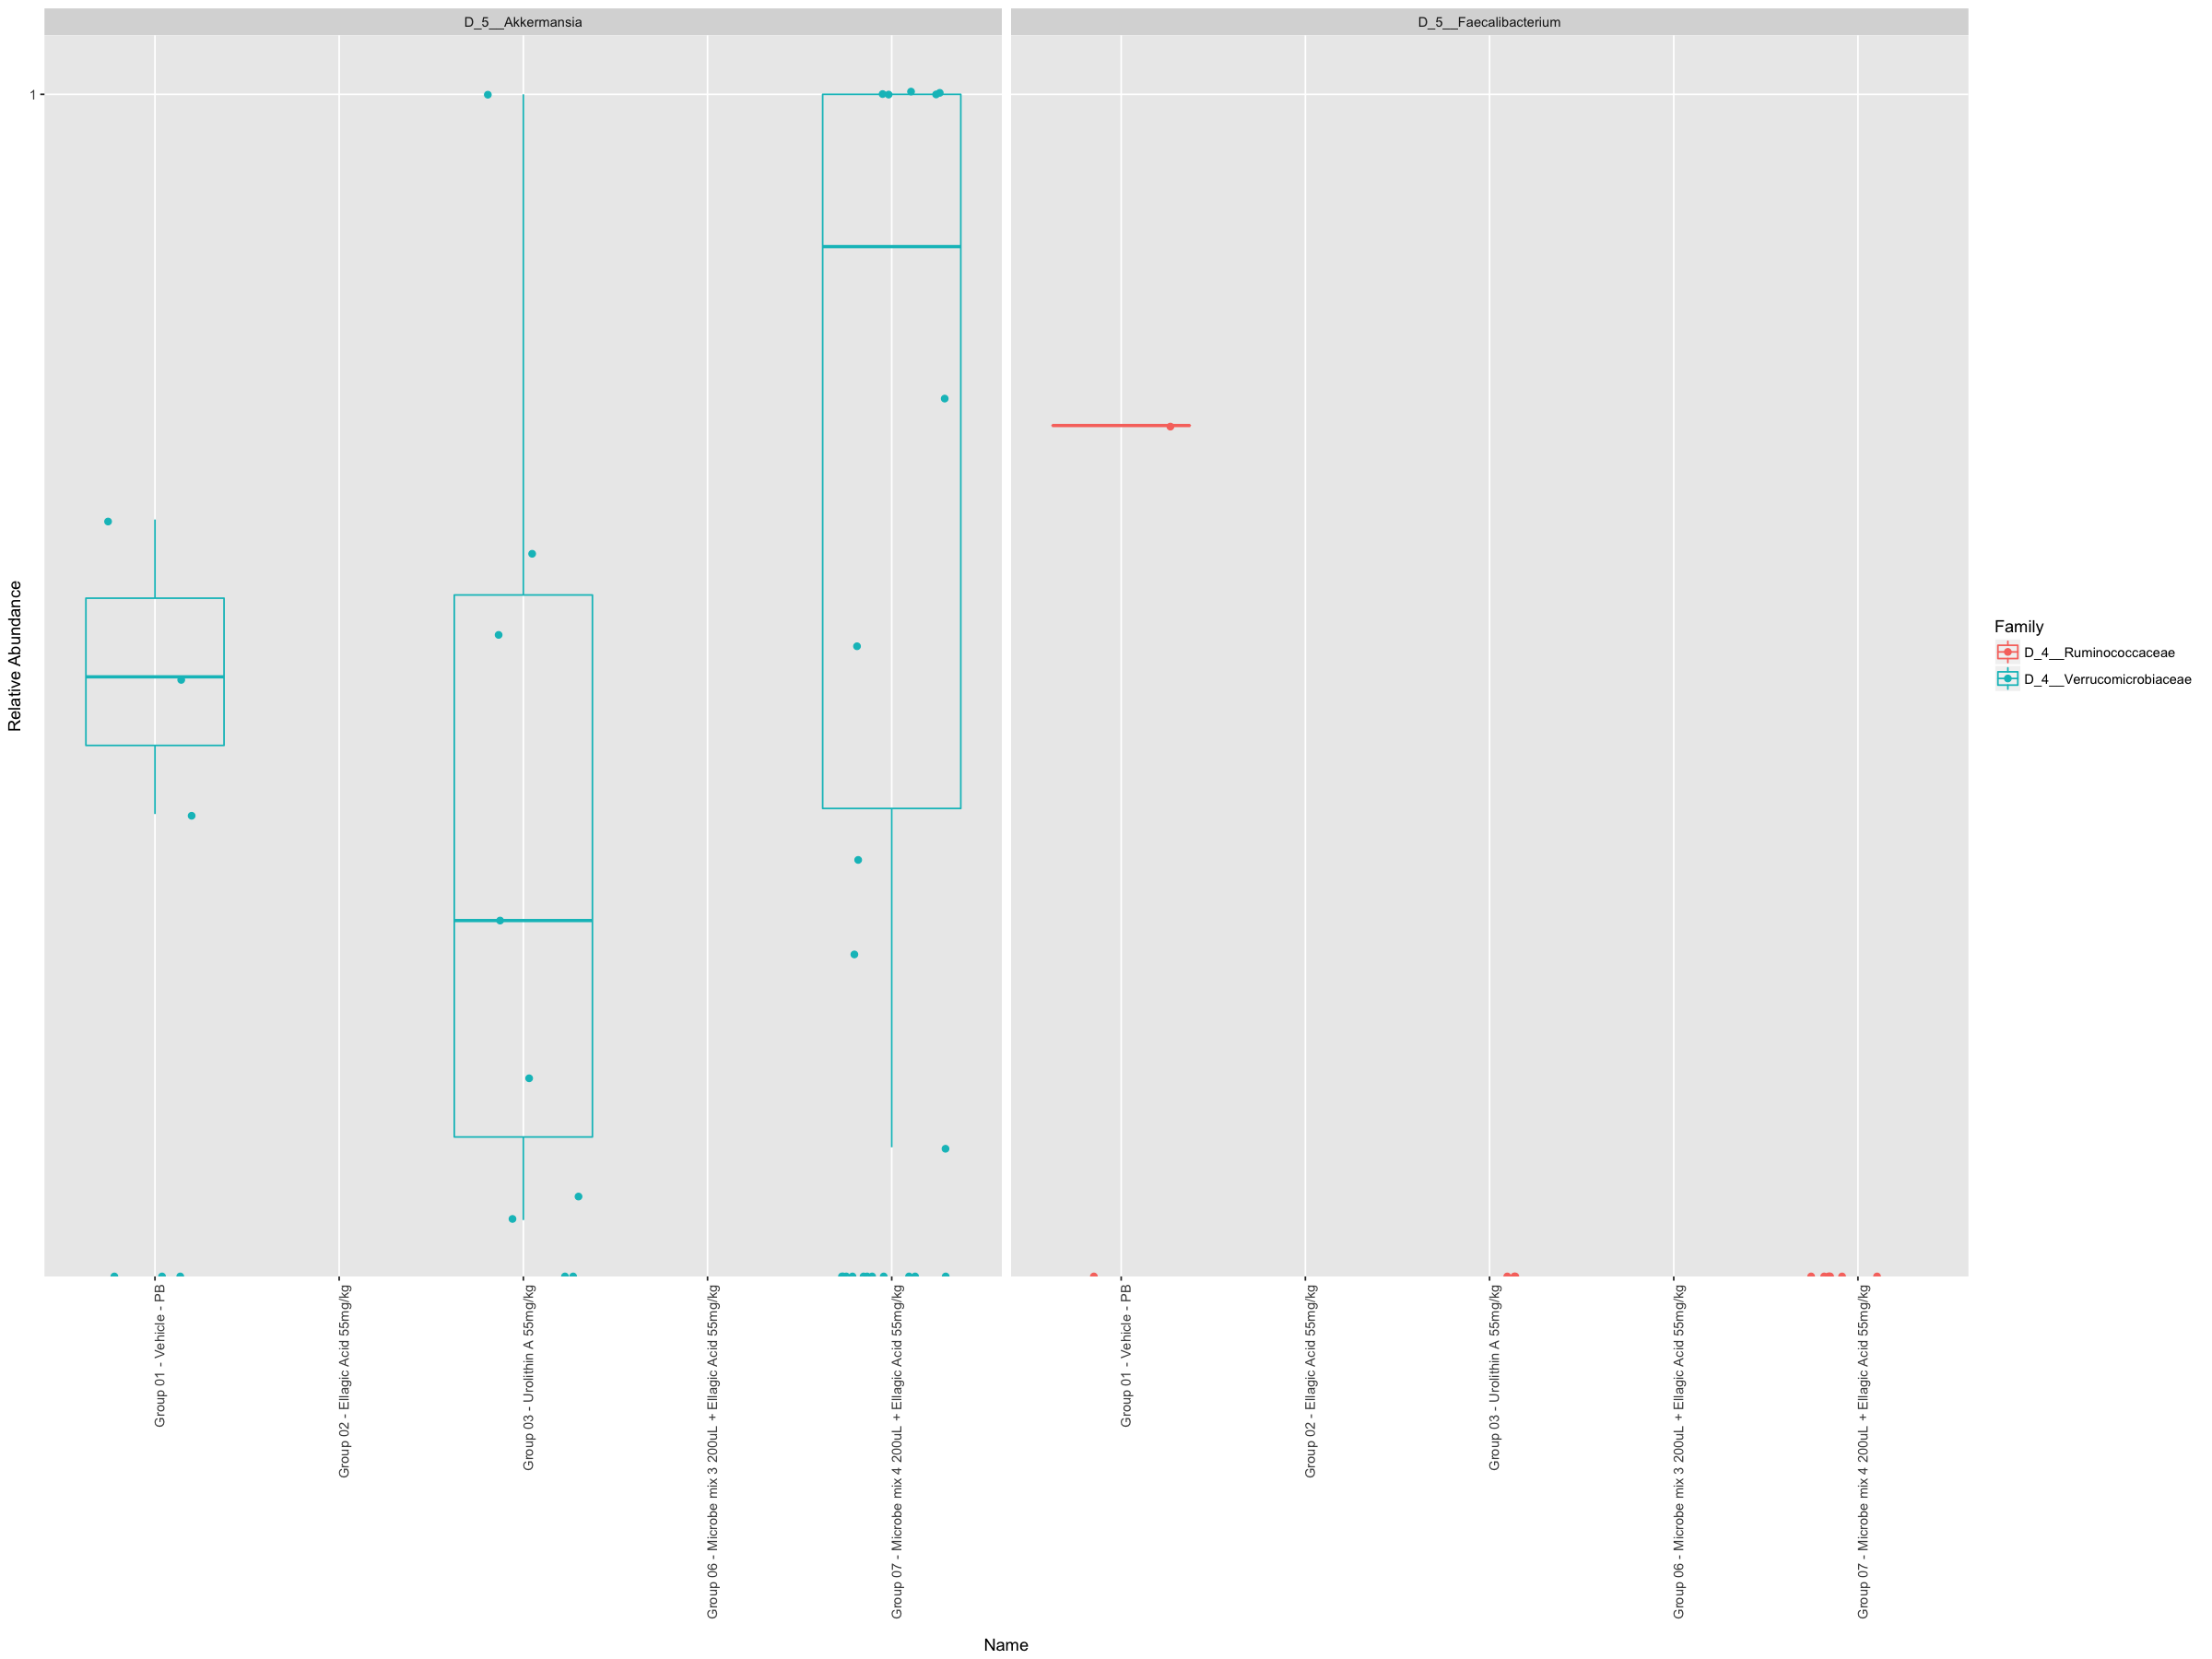

In [465]:
group12367rarefyna1pt2=subset_taxa(group12367rarefyna1, Genus =='D_5__Eggerthella'|Genus=='D_5__Akkermansia'|Genus=='D_5__Faecalibacterium'|
                                Genus=='D_5__Ruminococcus')
plot_randomforest(group12367rarefyna1pt2,grouping_column='Name', Color='Family', Facet='Genus')




In [ ]:

mphyseq = psmelt(group12367rarefyna1pt2)
#subset variables that passed p values
#mphyseq<- mphyseq[mphyseq$OTU %in% lsvs,]
#mphyseq$tax <- paste(mphyseq$OTU,mphyseq$Phylum,mphyseq$Class,mphyseq$Order,mphyseq$Family,mphyseq$Genus,mphyseq$Species)

options(repr.plot.width=20, repr.plot.height=15)
p = ggplot(data = mphyseq,  mapping = aes_string(x = grouping_column, y = "Abundance",
                                 color = Color, fill = Color)) +
    geom_boxplot(fill = NA) +
    geom_point(size = 1.5, alpha = 1,
                position = position_jitter(width = 0.3)) +
   facet_wrap(facets = Facet) + ylab('Relative Abundance') +
   scale_y_log10()+theme(axis.text.x = element_text(angle = 90, hjust = 1))